### TFG MES - Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de mes a mes (21 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN #Redes Recurrentes
from keras.layers import LSTM
from keras.layers import GRU
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testMes.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testMes.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testMes.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testMes.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



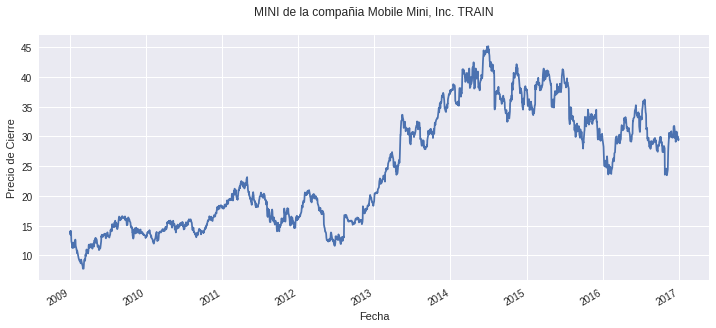

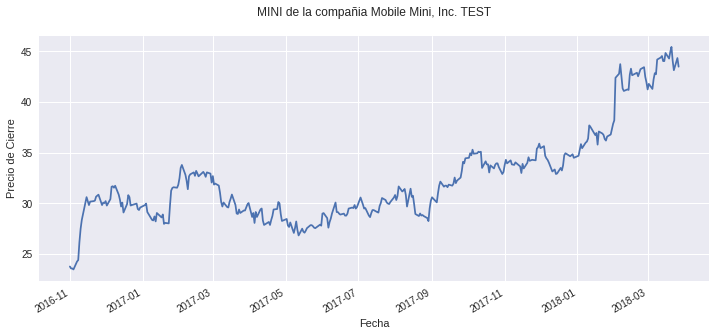

In [6]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 4
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [7]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [8]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo MINI de la compañia Mobile Mini, Inc.


In [9]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [17]:
modelRNN42 = Sequential()
modelRNN42.add(SimpleRNN(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelRNN42.add(SimpleRNN(2,activation="relu"))
modelRNN42.add(Dense(1)) 
modelRNN42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN42.summary()
history_RNN42 = modelRNN42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 21, 4)             32        
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 698.3767 - porcentaje_margen: 0.0000e+00 - val_loss: 714.9983 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 760us/step - loss: 695.8060 - porcentaje_margen: 0.0000e+00 - val_loss: 712.8308 - val_porcentaje_margen

Epoch 88/1500
1314/1314 [==============================] - 1s 686us/step - loss: 535.3728 - porcentaje_margen: 0.0000e+00 - val_loss: 550.6514 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
1314/1314 [==============================] - 1s 649us/step - loss: 533.6784 - porcentaje_margen: 0.0000e+00 - val_loss: 548.9370 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
1314/1314 [==============================] - 1s 751us/step - loss: 532.0049 - porcentaje_margen: 0.0000e+00 - val_loss: 547.2509 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
1314/1314 [==============================] - 1s 686us/step - loss: 530.3395 - porcentaje_margen: 0.0000e+00 - val_loss: 545.5679 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
1314/1314 [==============================] - 1s 700us/step - loss: 528.6654 - porcentaje_margen: 0.0000e+00 - val_loss: 543.8689 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
1314/1314 [==============================] - 1s 674us/step - loss: 526.9867 - porcentaje_ma

1314/1314 [==============================] - 1s 685us/step - loss: 396.9673 - porcentaje_margen: 0.0000e+00 - val_loss: 410.3870 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
1314/1314 [==============================] - 1s 664us/step - loss: 395.5756 - porcentaje_margen: 0.0000e+00 - val_loss: 408.9680 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
1314/1314 [==============================] - 1s 711us/step - loss: 394.2008 - porcentaje_margen: 0.0000e+00 - val_loss: 407.5723 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
1314/1314 [==============================] - 1s 618us/step - loss: 392.8102 - porcentaje_margen: 0.0000e+00 - val_loss: 406.1690 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
1314/1314 [==============================] - 1s 705us/step - loss: 391.4456 - porcentaje_margen: 0.0000e+00 - val_loss: 404.7796 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
1314/1314 [==============================] - 1s 708us/step - loss: 390.0702 - porcentaje_margen: 0.0

Epoch 225/1500
1314/1314 [==============================] - 1s 658us/step - loss: 335.5981 - porcentaje_margen: 0.0015 - val_loss: 348.0443 - val_porcentaje_margen: 0.0030
Epoch 226/1500
1314/1314 [==============================] - 1s 630us/step - loss: 334.3714 - porcentaje_margen: 0.0015 - val_loss: 346.8020 - val_porcentaje_margen: 0.0030
Epoch 227/1500
1314/1314 [==============================] - 1s 644us/step - loss: 333.1388 - porcentaje_margen: 0.0015 - val_loss: 345.5348 - val_porcentaje_margen: 0.0030
Epoch 228/1500
1314/1314 [==============================] - 1s 665us/step - loss: 331.9160 - porcentaje_margen: 0.0015 - val_loss: 344.3233 - val_porcentaje_margen: 0.0030
Epoch 229/1500
1314/1314 [==============================] - 1s 658us/step - loss: 330.7098 - porcentaje_margen: 0.0022 - val_loss: 343.0812 - val_porcentaje_margen: 0.0030
Epoch 230/1500
1314/1314 [==============================] - 1s 680us/step - loss: 329.4937 - porcentaje_margen: 0.0022 - val_loss: 341.8381 

Epoch 320/1500
1314/1314 [==============================] - 1s 636us/step - loss: 233.5854 - porcentaje_margen: 0.0543 - val_loss: 244.1064 - val_porcentaje_margen: 0.0491
Epoch 321/1500
1314/1314 [==============================] - 1s 646us/step - loss: 232.6838 - porcentaje_margen: 0.0603 - val_loss: 243.1890 - val_porcentaje_margen: 0.0476
Epoch 322/1500
1314/1314 [==============================] - 1s 593us/step - loss: 231.7881 - porcentaje_margen: 0.0640 - val_loss: 242.2762 - val_porcentaje_margen: 0.0536
Epoch 323/1500
1314/1314 [==============================] - 1s 643us/step - loss: 230.8887 - porcentaje_margen: 0.0662 - val_loss: 241.3619 - val_porcentaje_margen: 0.0536
Epoch 324/1500
1314/1314 [==============================] - 1s 680us/step - loss: 229.9964 - porcentaje_margen: 0.0766 - val_loss: 240.4373 - val_porcentaje_margen: 0.0580
Epoch 325/1500
1314/1314 [==============================] - 1s 687us/step - loss: 229.1035 - porcentaje_margen: 0.0677 - val_loss: 239.5421 

Epoch 415/1500
1314/1314 [==============================] - 1s 686us/step - loss: 160.7730 - porcentaje_margen: 0.1146 - val_loss: 169.4117 - val_porcentaje_margen: 0.0952
Epoch 416/1500
1314/1314 [==============================] - 1s 694us/step - loss: 160.1376 - porcentaje_margen: 0.1250 - val_loss: 168.7689 - val_porcentaje_margen: 0.0938
Epoch 417/1500
1314/1314 [==============================] - 1s 691us/step - loss: 159.5240 - porcentaje_margen: 0.1213 - val_loss: 168.1298 - val_porcentaje_margen: 0.0923
Epoch 418/1500
1314/1314 [==============================] - 1s 677us/step - loss: 158.9223 - porcentaje_margen: 0.1086 - val_loss: 167.5189 - val_porcentaje_margen: 0.0908
Epoch 419/1500
1314/1314 [==============================] - 1s 644us/step - loss: 158.3223 - porcentaje_margen: 0.1198 - val_loss: 166.8946 - val_porcentaje_margen: 0.0908
Epoch 420/1500
1314/1314 [==============================] - 1s 595us/step - loss: 157.7175 - porcentaje_margen: 0.1071 - val_loss: 166.2724 

Epoch 510/1500
1314/1314 [==============================] - 1s 655us/step - loss: 115.7577 - porcentaje_margen: 0.0766 - val_loss: 122.6457 - val_porcentaje_margen: 0.0711
Epoch 511/1500
1314/1314 [==============================] - 1s 689us/step - loss: 115.4263 - porcentaje_margen: 0.0774 - val_loss: 122.2923 - val_porcentaje_margen: 0.0711
Epoch 512/1500
1314/1314 [==============================] - 1s 611us/step - loss: 115.0993 - porcentaje_margen: 0.0774 - val_loss: 121.9511 - val_porcentaje_margen: 0.0681
Epoch 513/1500
1314/1314 [==============================] - 1s 659us/step - loss: 114.7775 - porcentaje_margen: 0.0766 - val_loss: 121.6077 - val_porcentaje_margen: 0.0681
Epoch 514/1500
1314/1314 [==============================] - 1s 705us/step - loss: 114.4591 - porcentaje_margen: 0.0766 - val_loss: 121.2761 - val_porcentaje_margen: 0.0681
Epoch 515/1500
1314/1314 [==============================] - 1s 700us/step - loss: 114.1449 - porcentaje_margen: 0.0766 - val_loss: 120.9452 

Epoch 605/1500
1314/1314 [==============================] - 1s 672us/step - loss: 95.5553 - porcentaje_margen: 0.0290 - val_loss: 100.9397 - val_porcentaje_margen: 0.0223
Epoch 606/1500
1314/1314 [==============================] - 1s 667us/step - loss: 95.4481 - porcentaje_margen: 0.0298 - val_loss: 100.8192 - val_porcentaje_margen: 0.0238
Epoch 607/1500
1314/1314 [==============================] - 1s 639us/step - loss: 95.3478 - porcentaje_margen: 0.0298 - val_loss: 100.7158 - val_porcentaje_margen: 0.0223
Epoch 608/1500
1314/1314 [==============================] - 1s 664us/step - loss: 95.2503 - porcentaje_margen: 0.0298 - val_loss: 100.5873 - val_porcentaje_margen: 0.0223
Epoch 609/1500
1314/1314 [==============================] - 1s 646us/step - loss: 95.1438 - porcentaje_margen: 0.0298 - val_loss: 100.4781 - val_porcentaje_margen: 0.0223
Epoch 610/1500
1314/1314 [==============================] - 1s 651us/step - loss: 95.0455 - porcentaje_margen: 0.0298 - val_loss: 100.3677 - val_

1314/1314 [==============================] - 1s 708us/step - loss: 91.4152 - porcentaje_margen: 0.0365 - val_loss: 95.9252 - val_porcentaje_margen: 0.0208
Epoch 702/1500
1314/1314 [==============================] - 1s 678us/step - loss: 91.4099 - porcentaje_margen: 0.0372 - val_loss: 95.9153 - val_porcentaje_margen: 0.0208
Epoch 703/1500
1314/1314 [==============================] - 1s 663us/step - loss: 91.4012 - porcentaje_margen: 0.0372 - val_loss: 95.9005 - val_porcentaje_margen: 0.0208
Epoch 704/1500
1314/1314 [==============================] - 1s 620us/step - loss: 91.3928 - porcentaje_margen: 0.0379 - val_loss: 95.8899 - val_porcentaje_margen: 0.0208
Epoch 705/1500
1314/1314 [==============================] - 1s 639us/step - loss: 91.3821 - porcentaje_margen: 0.0379 - val_loss: 95.8739 - val_porcentaje_margen: 0.0208
Epoch 706/1500
1314/1314 [==============================] - 1s 703us/step - loss: 91.3776 - porcentaje_margen: 0.0379 - val_loss: 95.8578 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 1s 657us/step - loss: 91.2280 - porcentaje_margen: 0.0387 - val_loss: 95.5212 - val_porcentaje_margen: 0.0336
Epoch 798/1500
1314/1314 [==============================] - 1s 656us/step - loss: 91.2287 - porcentaje_margen: 0.0387 - val_loss: 95.5226 - val_porcentaje_margen: 0.0336
Epoch 799/1500
1314/1314 [==============================] - 1s 650us/step - loss: 91.2300 - porcentaje_margen: 0.0387 - val_loss: 95.5212 - val_porcentaje_margen: 0.0336
Epoch 800/1500
1314/1314 [==============================] - 1s 647us/step - loss: 91.2288 - porcentaje_margen: 0.0387 - val_loss: 95.5214 - val_porcentaje_margen: 0.0336
Epoch 801/1500
1314/1314 [==============================] - 1s 679us/step - loss: 91.2290 - porcentaje_margen: 0.0387 - val_loss: 95.5238 - val_porcentaje_margen: 0.0309
Epoch 802/1500
1314/1314 [==============================] - 1s 664us/step - loss: 91.2289 - porcentaje_margen: 0.0499 - val_loss: 95.5247 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 1s 730us/step - loss: 91.2278 - porcentaje_margen: 0.0387 - val_loss: 95.5122 - val_porcentaje_margen: 0.0336
Epoch 894/1500
1314/1314 [==============================] - 1s 679us/step - loss: 91.2276 - porcentaje_margen: 0.0387 - val_loss: 95.5106 - val_porcentaje_margen: 0.0336
Epoch 895/1500
1314/1314 [==============================] - 1s 671us/step - loss: 91.2281 - porcentaje_margen: 0.0387 - val_loss: 95.5087 - val_porcentaje_margen: 0.0336
Epoch 896/1500
1314/1314 [==============================] - 1s 723us/step - loss: 91.2272 - porcentaje_margen: 0.0387 - val_loss: 95.5105 - val_porcentaje_margen: 0.0336
Epoch 897/1500
1314/1314 [==============================] - 1s 758us/step - loss: 91.2276 - porcentaje_margen: 0.0387 - val_loss: 95.5073 - val_porcentaje_margen: 0.0351
Epoch 898/1500
1314/1314 [==============================] - 1s 679us/step - loss: 91.2280 - porcentaje_margen: 0.0387 - val_loss: 95.5052 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 1s 687us/step - loss: 91.2286 - porcentaje_margen: 0.0387 - val_loss: 95.5184 - val_porcentaje_margen: 0.0336
Epoch 990/1500
1314/1314 [==============================] - 1s 671us/step - loss: 91.2293 - porcentaje_margen: 0.0387 - val_loss: 95.5187 - val_porcentaje_margen: 0.0336
Epoch 991/1500
1314/1314 [==============================] - 1s 649us/step - loss: 91.2294 - porcentaje_margen: 0.0387 - val_loss: 95.5154 - val_porcentaje_margen: 0.0336
Epoch 992/1500
1314/1314 [==============================] - 1s 654us/step - loss: 91.2280 - porcentaje_margen: 0.0387 - val_loss: 95.5137 - val_porcentaje_margen: 0.0336
Epoch 993/1500
1314/1314 [==============================] - 1s 667us/step - loss: 91.2278 - porcentaje_margen: 0.0387 - val_loss: 95.5123 - val_porcentaje_margen: 0.0336
Epoch 994/1500
1314/1314 [==============================] - 1s 690us/step - loss: 91.2282 - porcentaje_margen: 0.0387 - val_loss: 95.5109 - val_porcentaje_margen: 0.

1314/1314 [==============================] - 1s 688us/step - loss: 91.2284 - porcentaje_margen: 0.0387 - val_loss: 95.4953 - val_porcentaje_margen: 0.0351
Epoch 1038/1500
1314/1314 [==============================] - 1s 730us/step - loss: 91.2287 - porcentaje_margen: 0.0387 - val_loss: 95.4952 - val_porcentaje_margen: 0.0351
Epoch 1039/1500
1314/1314 [==============================] - 1s 713us/step - loss: 91.2282 - porcentaje_margen: 0.0387 - val_loss: 95.4930 - val_porcentaje_margen: 0.0365
Epoch 1040/1500
1314/1314 [==============================] - 1s 716us/step - loss: 91.2284 - porcentaje_margen: 0.0387 - val_loss: 95.4970 - val_porcentaje_margen: 0.0351
Epoch 1041/1500
1314/1314 [==============================] - 1s 682us/step - loss: 91.2281 - porcentaje_margen: 0.0387 - val_loss: 95.4978 - val_porcentaje_margen: 0.0351
Epoch 1042/1500
1314/1314 [==============================] - 1s 715us/step - loss: 91.2269 - porcentaje_margen: 0.0499 - val_loss: 95.5014 - val_porcentaje_marge

1314/1314 [==============================] - 1s 647us/step - loss: 91.2285 - porcentaje_margen: 0.0387 - val_loss: 95.5201 - val_porcentaje_margen: 0.0336
Epoch 1086/1500
1314/1314 [==============================] - 1s 637us/step - loss: 91.2287 - porcentaje_margen: 0.0387 - val_loss: 95.5177 - val_porcentaje_margen: 0.0336
Epoch 1087/1500
1314/1314 [==============================] - 1s 667us/step - loss: 91.2292 - porcentaje_margen: 0.0387 - val_loss: 95.5190 - val_porcentaje_margen: 0.0336
Epoch 1088/1500
1314/1314 [==============================] - 1s 632us/step - loss: 91.2292 - porcentaje_margen: 0.0387 - val_loss: 95.5140 - val_porcentaje_margen: 0.0336
Epoch 1089/1500
1314/1314 [==============================] - 1s 663us/step - loss: 91.2273 - porcentaje_margen: 0.0387 - val_loss: 95.5167 - val_porcentaje_margen: 0.0336
Epoch 1090/1500
1314/1314 [==============================] - 1s 699us/step - loss: 91.2290 - porcentaje_margen: 0.0387 - val_loss: 95.5193 - val_porcentaje_marge

1314/1314 [==============================] - 1s 664us/step - loss: 91.2294 - porcentaje_margen: 0.0387 - val_loss: 95.5182 - val_porcentaje_margen: 0.0336
Epoch 1134/1500
1314/1314 [==============================] - 1s 683us/step - loss: 91.2288 - porcentaje_margen: 0.0387 - val_loss: 95.5151 - val_porcentaje_margen: 0.0336
Epoch 1135/1500
1314/1314 [==============================] - 1s 614us/step - loss: 91.2282 - porcentaje_margen: 0.0387 - val_loss: 95.5137 - val_porcentaje_margen: 0.0336
Epoch 1136/1500
1314/1314 [==============================] - 1s 603us/step - loss: 91.2282 - porcentaje_margen: 0.0387 - val_loss: 95.5131 - val_porcentaje_margen: 0.0336
Epoch 1137/1500
1314/1314 [==============================] - 1s 641us/step - loss: 91.2279 - porcentaje_margen: 0.0387 - val_loss: 95.5135 - val_porcentaje_margen: 0.0336
Epoch 1138/1500
1314/1314 [==============================] - 1s 690us/step - loss: 91.2281 - porcentaje_margen: 0.0387 - val_loss: 95.5132 - val_porcentaje_marge

1314/1314 [==============================] - 1s 684us/step - loss: 91.2303 - porcentaje_margen: 0.0387 - val_loss: 95.5063 - val_porcentaje_margen: 0.0351
Epoch 1182/1500
1314/1314 [==============================] - 1s 655us/step - loss: 91.2277 - porcentaje_margen: 0.0387 - val_loss: 95.5095 - val_porcentaje_margen: 0.0336
Epoch 1183/1500
1314/1314 [==============================] - 1s 624us/step - loss: 91.2277 - porcentaje_margen: 0.0387 - val_loss: 95.5083 - val_porcentaje_margen: 0.0351
Epoch 1184/1500
1314/1314 [==============================] - 1s 692us/step - loss: 91.2278 - porcentaje_margen: 0.0387 - val_loss: 95.5074 - val_porcentaje_margen: 0.0351
Epoch 1185/1500
1314/1314 [==============================] - 1s 596us/step - loss: 91.2275 - porcentaje_margen: 0.0387 - val_loss: 95.5065 - val_porcentaje_margen: 0.0351
Epoch 1186/1500
1314/1314 [==============================] - 1s 612us/step - loss: 91.2275 - porcentaje_margen: 0.0387 - val_loss: 95.5057 - val_porcentaje_marge

1314/1314 [==============================] - 1s 679us/step - loss: 91.2277 - porcentaje_margen: 0.0387 - val_loss: 95.4999 - val_porcentaje_margen: 0.0351
Epoch 1230/1500
1314/1314 [==============================] - 1s 652us/step - loss: 91.2274 - porcentaje_margen: 0.0394 - val_loss: 95.5006 - val_porcentaje_margen: 0.0351
Epoch 1231/1500
1314/1314 [==============================] - 1s 676us/step - loss: 91.2273 - porcentaje_margen: 0.0506 - val_loss: 95.4985 - val_porcentaje_margen: 0.0351
Epoch 1232/1500
1314/1314 [==============================] - 1s 652us/step - loss: 91.2275 - porcentaje_margen: 0.0394 - val_loss: 95.5004 - val_porcentaje_margen: 0.0351
Epoch 1233/1500
1314/1314 [==============================] - 1s 663us/step - loss: 91.2281 - porcentaje_margen: 0.0387 - val_loss: 95.5028 - val_porcentaje_margen: 0.0351
Epoch 1234/1500
1314/1314 [==============================] - 1s 667us/step - loss: 91.2274 - porcentaje_margen: 0.0387 - val_loss: 95.5025 - val_porcentaje_marge

1314/1314 [==============================] - 1s 711us/step - loss: 91.2291 - porcentaje_margen: 0.0387 - val_loss: 95.5127 - val_porcentaje_margen: 0.0336
Epoch 1278/1500
1314/1314 [==============================] - 1s 658us/step - loss: 91.2275 - porcentaje_margen: 0.0387 - val_loss: 95.5097 - val_porcentaje_margen: 0.0336
Epoch 1279/1500
1314/1314 [==============================] - 1s 641us/step - loss: 91.2278 - porcentaje_margen: 0.0387 - val_loss: 95.5083 - val_porcentaje_margen: 0.0351
Epoch 1280/1500
1314/1314 [==============================] - 1s 705us/step - loss: 91.2274 - porcentaje_margen: 0.0499 - val_loss: 95.5077 - val_porcentaje_margen: 0.0351
Epoch 1281/1500
1314/1314 [==============================] - 1s 627us/step - loss: 91.2282 - porcentaje_margen: 0.0387 - val_loss: 95.5067 - val_porcentaje_margen: 0.0351
Epoch 1282/1500
1314/1314 [==============================] - 1s 657us/step - loss: 91.2274 - porcentaje_margen: 0.0387 - val_loss: 95.5071 - val_porcentaje_marge

1314/1314 [==============================] - 1s 660us/step - loss: 91.2282 - porcentaje_margen: 0.0499 - val_loss: 95.5044 - val_porcentaje_margen: 0.0351
Epoch 1326/1500
1314/1314 [==============================] - 1s 663us/step - loss: 91.2272 - porcentaje_margen: 0.0387 - val_loss: 95.5050 - val_porcentaje_margen: 0.0351
Epoch 1327/1500
1314/1314 [==============================] - 1s 708us/step - loss: 91.2275 - porcentaje_margen: 0.0387 - val_loss: 95.5061 - val_porcentaje_margen: 0.0351
Epoch 1328/1500
1314/1314 [==============================] - 1s 678us/step - loss: 91.2281 - porcentaje_margen: 0.0387 - val_loss: 95.5038 - val_porcentaje_margen: 0.0351
Epoch 1329/1500
1314/1314 [==============================] - 1s 684us/step - loss: 91.2290 - porcentaje_margen: 0.0387 - val_loss: 95.5039 - val_porcentaje_margen: 0.0351
Epoch 1330/1500
1314/1314 [==============================] - 1s 636us/step - loss: 91.2266 - porcentaje_margen: 0.0387 - val_loss: 95.5061 - val_porcentaje_marge

1314/1314 [==============================] - 1s 613us/step - loss: 91.2278 - porcentaje_margen: 0.0394 - val_loss: 95.4994 - val_porcentaje_margen: 0.0351
Epoch 1374/1500
1314/1314 [==============================] - 1s 595us/step - loss: 91.2273 - porcentaje_margen: 0.0394 - val_loss: 95.5003 - val_porcentaje_margen: 0.0351
Epoch 1375/1500
1314/1314 [==============================] - 1s 665us/step - loss: 91.2270 - porcentaje_margen: 0.0394 - val_loss: 95.5017 - val_porcentaje_margen: 0.0351
Epoch 1376/1500
1314/1314 [==============================] - 1s 642us/step - loss: 91.2274 - porcentaje_margen: 0.0394 - val_loss: 95.5008 - val_porcentaje_margen: 0.0351
Epoch 1377/1500
1314/1314 [==============================] - 1s 674us/step - loss: 91.2276 - porcentaje_margen: 0.0387 - val_loss: 95.5018 - val_porcentaje_margen: 0.0351
Epoch 1378/1500
1314/1314 [==============================] - 1s 612us/step - loss: 91.2280 - porcentaje_margen: 0.0387 - val_loss: 95.5020 - val_porcentaje_marge

1314/1314 [==============================] - 1s 637us/step - loss: 91.2276 - porcentaje_margen: 0.0394 - val_loss: 95.5003 - val_porcentaje_margen: 0.0351
Epoch 1422/1500
1314/1314 [==============================] - 1s 681us/step - loss: 91.2272 - porcentaje_margen: 0.0394 - val_loss: 95.5031 - val_porcentaje_margen: 0.0351
Epoch 1423/1500
1314/1314 [==============================] - 1s 663us/step - loss: 91.2268 - porcentaje_margen: 0.0394 - val_loss: 95.5002 - val_porcentaje_margen: 0.0351
Epoch 1424/1500
1314/1314 [==============================] - 1s 637us/step - loss: 91.2271 - porcentaje_margen: 0.0394 - val_loss: 95.5024 - val_porcentaje_margen: 0.0351
Epoch 1425/1500
1314/1314 [==============================] - 1s 677us/step - loss: 91.2274 - porcentaje_margen: 0.0394 - val_loss: 95.5003 - val_porcentaje_margen: 0.0351
Epoch 1426/1500
1314/1314 [==============================] - 1s 676us/step - loss: 91.2279 - porcentaje_margen: 0.0394 - val_loss: 95.5005 - val_porcentaje_marge

1314/1314 [==============================] - 1s 643us/step - loss: 91.2300 - porcentaje_margen: 0.0387 - val_loss: 95.5111 - val_porcentaje_margen: 0.0336
Epoch 1470/1500
1314/1314 [==============================] - 1s 673us/step - loss: 91.2276 - porcentaje_margen: 0.0387 - val_loss: 95.5098 - val_porcentaje_margen: 0.0336
Epoch 1471/1500
1314/1314 [==============================] - 1s 660us/step - loss: 91.2282 - porcentaje_margen: 0.0387 - val_loss: 95.5106 - val_porcentaje_margen: 0.0336
Epoch 1472/1500
1314/1314 [==============================] - 1s 626us/step - loss: 91.2273 - porcentaje_margen: 0.0610 - val_loss: 95.5099 - val_porcentaje_margen: 0.0336
Epoch 1473/1500
1314/1314 [==============================] - 1s 617us/step - loss: 91.2278 - porcentaje_margen: 0.0387 - val_loss: 95.5098 - val_porcentaje_margen: 0.0336
Epoch 1474/1500
1314/1314 [==============================] - 1s 646us/step - loss: 91.2281 - porcentaje_margen: 0.0387 - val_loss: 95.5108 - val_porcentaje_marge

In [10]:
modelRNN84 = Sequential()
modelRNN84.add(SimpleRNN(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelRNN84.add(SimpleRNN(4,activation="relu"))
modelRNN84.add(Dense(1)) 
modelRNN84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN84.summary()
history_RNN84 = modelRNN84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 21, 8)             96        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 29ms/step - loss: 707.7153 - porcentaje_margen: 0.0000e+00 - val_loss: 691.9240 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 24ms/step - loss: 703.0228 - porcentaje_margen: 0.0000e+00 - val_loss: 685.4119 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [======================

42/42 [==============================] - 1s 19ms/step - loss: 2.1703 - porcentaje_margen: 0.6577 - val_loss: 2.3874 - val_porcentaje_margen: 0.6425
Epoch 47/1500
42/42 [==============================] - 1s 21ms/step - loss: 2.1256 - porcentaje_margen: 0.6570 - val_loss: 2.2796 - val_porcentaje_margen: 0.6858
Epoch 48/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.0966 - porcentaje_margen: 0.6734 - val_loss: 2.3356 - val_porcentaje_margen: 0.6541
Epoch 49/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.0558 - porcentaje_margen: 0.6637 - val_loss: 2.3196 - val_porcentaje_margen: 0.6680
Epoch 50/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.1027 - porcentaje_margen: 0.6696 - val_loss: 2.2241 - val_porcentaje_margen: 0.6951
Epoch 51/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0504 - porcentaje_margen: 0.6600 - val_loss: 2.2621 - val_porcentaje_margen: 0.6749
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.4585 - porcentaje_margen: 0.7448 - val_loss: 1.6232 - val_porcentaje_margen: 0.7368
Epoch 98/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.5066 - porcentaje_margen: 0.7240 - val_loss: 1.5280 - val_porcentaje_margen: 0.7599
Epoch 99/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.5982 - porcentaje_margen: 0.7180 - val_loss: 1.6545 - val_porcentaje_margen: 0.7219
Epoch 100/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.4288 - porcentaje_margen: 0.7351 - val_loss: 1.5567 - val_porcentaje_margen: 0.7313
Epoch 101/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.4323 - porcentaje_margen: 0.7247 - val_loss: 1.5238 - val_porcentaje_margen: 0.7402
Epoch 102/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.4430 - porcentaje_margen: 0.7299 - val_loss: 1.5428 - val_porcentaje_margen: 0.7528
Epoch 103/1500
42/42 [===

42/42 [==============================] - 1s 16ms/step - loss: 1.4106 - porcentaje_margen: 0.7470 - val_loss: 1.3534 - val_porcentaje_margen: 0.7670
Epoch 148/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.3414 - porcentaje_margen: 0.7403 - val_loss: 1.3245 - val_porcentaje_margen: 0.7603
Epoch 149/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.2529 - porcentaje_margen: 0.7686 - val_loss: 1.3943 - val_porcentaje_margen: 0.7566
Epoch 150/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.2654 - porcentaje_margen: 0.7626 - val_loss: 1.4335 - val_porcentaje_margen: 0.7432
Epoch 151/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.2719 - porcentaje_margen: 0.7582 - val_loss: 1.3172 - val_porcentaje_margen: 0.7603
Epoch 152/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.2920 - porcentaje_margen: 0.7388 - val_loss: 1.4143 - val_porcentaje_margen: 0.7528
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 1.1860 - porcentaje_margen: 0.7812 - val_loss: 1.4371 - val_porcentaje_margen: 0.7358
Epoch 198/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.3030 - porcentaje_margen: 0.7746 - val_loss: 1.2406 - val_porcentaje_margen: 0.7826
Epoch 199/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.1649 - porcentaje_margen: 0.7760 - val_loss: 1.2772 - val_porcentaje_margen: 0.7855
Epoch 200/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.1746 - porcentaje_margen: 0.7924 - val_loss: 1.2507 - val_porcentaje_margen: 0.7841
Epoch 201/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.1793 - porcentaje_margen: 0.7746 - val_loss: 1.2266 - val_porcentaje_margen: 0.7700
Epoch 202/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.1536 - porcentaje_margen: 0.7909 - val_loss: 1.2094 - val_porcentaje_margen: 0.7837
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 1.1010 - porcentaje_margen: 0.8051 - val_loss: 1.1499 - val_porcentaje_margen: 0.7960
Epoch 248/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.0738 - porcentaje_margen: 0.8065 - val_loss: 1.1637 - val_porcentaje_margen: 0.7789
Epoch 249/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.0887 - porcentaje_margen: 0.8132 - val_loss: 1.1371 - val_porcentaje_margen: 0.7956
Epoch 250/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.1755 - porcentaje_margen: 0.7820 - val_loss: 1.1523 - val_porcentaje_margen: 0.7864
Epoch 251/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.1254 - porcentaje_margen: 0.7909 - val_loss: 1.1302 - val_porcentaje_margen: 0.7927
Epoch 252/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.0770 - porcentaje_margen: 0.8103 - val_loss: 1.2108 - val_porcentaje_margen: 0.7945
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 1.0454 - porcentaje_margen: 0.8222 - val_loss: 1.0886 - val_porcentaje_margen: 0.8105
Epoch 298/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.0335 - porcentaje_margen: 0.8103 - val_loss: 1.0693 - val_porcentaje_margen: 0.8105
Epoch 299/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.0329 - porcentaje_margen: 0.8132 - val_loss: 1.0718 - val_porcentaje_margen: 0.7941
Epoch 300/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.0688 - porcentaje_margen: 0.8080 - val_loss: 1.0850 - val_porcentaje_margen: 0.8150
Epoch 301/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.0088 - porcentaje_margen: 0.8237 - val_loss: 1.0573 - val_porcentaje_margen: 0.8105
Epoch 302/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.0279 - porcentaje_margen: 0.8132 - val_loss: 1.0789 - val_porcentaje_margen: 0.7953
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 0.9756 - porcentaje_margen: 0.8229 - val_loss: 1.0210 - val_porcentaje_margen: 0.8016
Epoch 348/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9999 - porcentaje_margen: 0.8348 - val_loss: 1.0116 - val_porcentaje_margen: 0.8135
Epoch 349/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9614 - porcentaje_margen: 0.8214 - val_loss: 1.0460 - val_porcentaje_margen: 0.7983
Epoch 350/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.0163 - porcentaje_margen: 0.8185 - val_loss: 1.0649 - val_porcentaje_margen: 0.7983
Epoch 351/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9649 - porcentaje_margen: 0.8341 - val_loss: 1.0193 - val_porcentaje_margen: 0.8239
Epoch 352/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9619 - porcentaje_margen: 0.8356 - val_loss: 1.0460 - val_porcentaje_margen: 0.7998
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 0.9407 - porcentaje_margen: 0.8244 - val_loss: 1.0139 - val_porcentaje_margen: 0.8105
Epoch 398/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9743 - porcentaje_margen: 0.8199 - val_loss: 1.0170 - val_porcentaje_margen: 0.8061
Epoch 399/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9431 - porcentaje_margen: 0.8326 - val_loss: 0.9980 - val_porcentaje_margen: 0.8046
Epoch 400/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9510 - porcentaje_margen: 0.8170 - val_loss: 1.0128 - val_porcentaje_margen: 0.8046
Epoch 401/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9573 - porcentaje_margen: 0.8296 - val_loss: 1.0233 - val_porcentaje_margen: 0.8075
Epoch 402/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9696 - porcentaje_margen: 0.8118 - val_loss: 0.9958 - val_porcentaje_margen: 0.8135
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 0.9910 - porcentaje_margen: 0.8237 - val_loss: 0.9868 - val_porcentaje_margen: 0.8105
Epoch 448/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9451 - porcentaje_margen: 0.8266 - val_loss: 1.0849 - val_porcentaje_margen: 0.7864
Epoch 449/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9654 - porcentaje_margen: 0.8140 - val_loss: 1.0697 - val_porcentaje_margen: 0.7908
Epoch 450/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.0725 - porcentaje_margen: 0.8043 - val_loss: 1.0275 - val_porcentaje_margen: 0.8090
Epoch 451/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9483 - porcentaje_margen: 0.8304 - val_loss: 0.9914 - val_porcentaje_margen: 0.8087
Epoch 452/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9419 - porcentaje_margen: 0.8199 - val_loss: 1.0257 - val_porcentaje_margen: 0.8075
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 0.9398 - porcentaje_margen: 0.8371 - val_loss: 1.0307 - val_porcentaje_margen: 0.8079
Epoch 498/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9226 - porcentaje_margen: 0.8438 - val_loss: 0.9961 - val_porcentaje_margen: 0.8135
Epoch 499/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9269 - porcentaje_margen: 0.8311 - val_loss: 0.9837 - val_porcentaje_margen: 0.8135
Epoch 500/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.9209 - porcentaje_margen: 0.8348 - val_loss: 1.1126 - val_porcentaje_margen: 0.7778
Epoch 501/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9696 - porcentaje_margen: 0.8296 - val_loss: 0.9764 - val_porcentaje_margen: 0.8105
Epoch 502/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9308 - porcentaje_margen: 0.8341 - val_loss: 1.0914 - val_porcentaje_margen: 0.7908
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 1.0138 - porcentaje_margen: 0.8237 - val_loss: 0.9882 - val_porcentaje_margen: 0.8150
Epoch 548/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.9247 - porcentaje_margen: 0.8363 - val_loss: 0.9691 - val_porcentaje_margen: 0.8194
Epoch 549/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9107 - porcentaje_margen: 0.8467 - val_loss: 0.9670 - val_porcentaje_margen: 0.8135
Epoch 550/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9136 - porcentaje_margen: 0.8363 - val_loss: 0.9691 - val_porcentaje_margen: 0.8165
Epoch 551/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9096 - porcentaje_margen: 0.8385 - val_loss: 0.9727 - val_porcentaje_margen: 0.8191
Epoch 552/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9356 - porcentaje_margen: 0.8393 - val_loss: 1.0224 - val_porcentaje_margen: 0.7953
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.9163 - porcentaje_margen: 0.8452 - val_loss: 1.3008 - val_porcentaje_margen: 0.7650
Epoch 598/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.0575 - porcentaje_margen: 0.8118 - val_loss: 1.0067 - val_porcentaje_margen: 0.7983
Epoch 599/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9203 - porcentaje_margen: 0.8415 - val_loss: 0.9844 - val_porcentaje_margen: 0.8042
Epoch 600/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.9021 - porcentaje_margen: 0.8490 - val_loss: 1.0012 - val_porcentaje_margen: 0.8042
Epoch 601/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9110 - porcentaje_margen: 0.8534 - val_loss: 1.0576 - val_porcentaje_margen: 0.7923
Epoch 602/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9114 - porcentaje_margen: 0.8445 - val_loss: 0.9766 - val_porcentaje_margen: 0.8057
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 0.9131 - porcentaje_margen: 0.8438 - val_loss: 0.9584 - val_porcentaje_margen: 0.8191
Epoch 648/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.9354 - porcentaje_margen: 0.8214 - val_loss: 0.9651 - val_porcentaje_margen: 0.8176
Epoch 649/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9067 - porcentaje_margen: 0.8318 - val_loss: 0.9597 - val_porcentaje_margen: 0.8146
Epoch 650/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.9184 - porcentaje_margen: 0.8482 - val_loss: 0.9880 - val_porcentaje_margen: 0.8072
Epoch 651/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9008 - porcentaje_margen: 0.8445 - val_loss: 0.9983 - val_porcentaje_margen: 0.8198
Epoch 652/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.9558 - porcentaje_margen: 0.8341 - val_loss: 0.9904 - val_porcentaje_margen: 0.8239
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 0.8955 - porcentaje_margen: 0.8438 - val_loss: 0.9368 - val_porcentaje_margen: 0.8295
Epoch 698/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9085 - porcentaje_margen: 0.8363 - val_loss: 0.9693 - val_porcentaje_margen: 0.8117
Epoch 699/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8819 - porcentaje_margen: 0.8542 - val_loss: 0.9571 - val_porcentaje_margen: 0.8328
Epoch 700/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9960 - porcentaje_margen: 0.8341 - val_loss: 0.9361 - val_porcentaje_margen: 0.8266
Epoch 701/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9168 - porcentaje_margen: 0.8490 - val_loss: 0.9343 - val_porcentaje_margen: 0.8224
Epoch 702/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8940 - porcentaje_margen: 0.8452 - val_loss: 0.9480 - val_porcentaje_margen: 0.8280
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.9392 - porcentaje_margen: 0.8251 - val_loss: 1.0658 - val_porcentaje_margen: 0.8153
Epoch 748/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9186 - porcentaje_margen: 0.8378 - val_loss: 0.9285 - val_porcentaje_margen: 0.8254
Epoch 749/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9052 - porcentaje_margen: 0.8549 - val_loss: 0.9287 - val_porcentaje_margen: 0.8280
Epoch 750/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9468 - porcentaje_margen: 0.8415 - val_loss: 0.9302 - val_porcentaje_margen: 0.8310
Epoch 751/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8783 - porcentaje_margen: 0.8579 - val_loss: 0.9344 - val_porcentaje_margen: 0.8385
Epoch 752/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8952 - porcentaje_margen: 0.8452 - val_loss: 0.9649 - val_porcentaje_margen: 0.8317
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 0.8706 - porcentaje_margen: 0.8445 - val_loss: 0.9229 - val_porcentaje_margen: 0.8340
Epoch 798/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8991 - porcentaje_margen: 0.8341 - val_loss: 0.9192 - val_porcentaje_margen: 0.8280
Epoch 799/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8746 - porcentaje_margen: 0.8519 - val_loss: 1.0313 - val_porcentaje_margen: 0.8213
Epoch 800/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9325 - porcentaje_margen: 0.8296 - val_loss: 0.9532 - val_porcentaje_margen: 0.8087
Epoch 801/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.8862 - porcentaje_margen: 0.8445 - val_loss: 0.9219 - val_porcentaje_margen: 0.8340
Epoch 802/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8890 - porcentaje_margen: 0.8326 - val_loss: 0.9200 - val_porcentaje_margen: 0.8355
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 0.8670 - porcentaje_margen: 0.8519 - val_loss: 0.9397 - val_porcentaje_margen: 0.8132
Epoch 848/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8967 - porcentaje_margen: 0.8482 - val_loss: 0.9697 - val_porcentaje_margen: 0.8027
Epoch 849/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9281 - porcentaje_margen: 0.8430 - val_loss: 0.9144 - val_porcentaje_margen: 0.8325
Epoch 850/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8664 - porcentaje_margen: 0.8408 - val_loss: 0.9553 - val_porcentaje_margen: 0.8302
Epoch 851/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8925 - porcentaje_margen: 0.8467 - val_loss: 0.9461 - val_porcentaje_margen: 0.8317
Epoch 852/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9042 - porcentaje_margen: 0.8519 - val_loss: 0.9238 - val_porcentaje_margen: 0.8206
Epoch 853/1500
42/42 [===============

42/42 [==============================] - ETA: 0s - loss: 0.8661 - porcentaje_margen: 0.857 - 1s 15ms/step - loss: 0.8649 - porcentaje_margen: 0.8609 - val_loss: 0.9064 - val_porcentaje_margen: 0.8340
Epoch 898/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8644 - porcentaje_margen: 0.8594 - val_loss: 0.9055 - val_porcentaje_margen: 0.8310
Epoch 899/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8698 - porcentaje_margen: 0.8438 - val_loss: 0.9407 - val_porcentaje_margen: 0.8176
Epoch 900/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.9031 - porcentaje_margen: 0.8356 - val_loss: 0.9155 - val_porcentaje_margen: 0.8236
Epoch 901/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8865 - porcentaje_margen: 0.8571 - val_loss: 1.0654 - val_porcentaje_margen: 0.8138
Epoch 902/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8786 - porcentaje_margen: 0.8393 - val_loss: 0.9118 - val_porcentaje_

42/42 [==============================] - 1s 19ms/step - loss: 0.8524 - porcentaje_margen: 0.8646 - val_loss: 0.9239 - val_porcentaje_margen: 0.8191
Epoch 948/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8609 - porcentaje_margen: 0.8542 - val_loss: 0.9059 - val_porcentaje_margen: 0.8280
Epoch 949/1500
42/42 [==============================] - ETA: 0s - loss: 0.8715 - porcentaje_margen: 0.855 - 1s 17ms/step - loss: 0.8715 - porcentaje_margen: 0.8557 - val_loss: 0.8971 - val_porcentaje_margen: 0.8399
Epoch 950/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8566 - porcentaje_margen: 0.8527 - val_loss: 0.8957 - val_porcentaje_margen: 0.8310
Epoch 951/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9034 - porcentaje_margen: 0.8467 - val_loss: 0.9041 - val_porcentaje_margen: 0.8391
Epoch 952/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9086 - porcentaje_margen: 0.8504 - val_loss: 0.9174 - val_porcentaje_

42/42 [==============================] - 1s 16ms/step - loss: 0.8763 - porcentaje_margen: 0.8549 - val_loss: 0.8973 - val_porcentaje_margen: 0.8236
Epoch 998/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8498 - porcentaje_margen: 0.8579 - val_loss: 0.9464 - val_porcentaje_margen: 0.8332
Epoch 999/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8811 - porcentaje_margen: 0.8363 - val_loss: 0.8900 - val_porcentaje_margen: 0.8370
Epoch 1000/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8555 - porcentaje_margen: 0.8542 - val_loss: 0.9023 - val_porcentaje_margen: 0.8433
Epoch 1001/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8551 - porcentaje_margen: 0.8601 - val_loss: 0.9602 - val_porcentaje_margen: 0.7998
Epoch 1002/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8886 - porcentaje_margen: 0.8519 - val_loss: 0.8928 - val_porcentaje_margen: 0.8355
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 15ms/step - loss: 0.8718 - porcentaje_margen: 0.8609 - val_loss: 0.8833 - val_porcentaje_margen: 0.8433
Epoch 1048/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8460 - porcentaje_margen: 0.8646 - val_loss: 0.8888 - val_porcentaje_margen: 0.8403
Epoch 1049/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8413 - porcentaje_margen: 0.8430 - val_loss: 0.8938 - val_porcentaje_margen: 0.8295
Epoch 1050/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8719 - porcentaje_margen: 0.8497 - val_loss: 0.9534 - val_porcentaje_margen: 0.8027
Epoch 1051/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.9677 - porcentaje_margen: 0.8400 - val_loss: 0.9418 - val_porcentaje_margen: 0.8361
Epoch 1052/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8706 - porcentaje_margen: 0.8475 - val_loss: 0.9281 - val_porcentaje_margen: 0.8146
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 17ms/step - loss: 0.8463 - porcentaje_margen: 0.8527 - val_loss: 0.8954 - val_porcentaje_margen: 0.8236
Epoch 1098/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8577 - porcentaje_margen: 0.8385 - val_loss: 0.8801 - val_porcentaje_margen: 0.8385
Epoch 1099/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8716 - porcentaje_margen: 0.8467 - val_loss: 0.8783 - val_porcentaje_margen: 0.8459
Epoch 1100/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8420 - porcentaje_margen: 0.8616 - val_loss: 0.8932 - val_porcentaje_margen: 0.8462
Epoch 1101/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8496 - porcentaje_margen: 0.8638 - val_loss: 0.8966 - val_porcentaje_margen: 0.8447
Epoch 1102/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8770 - porcentaje_margen: 0.8527 - val_loss: 0.9187 - val_porcentaje_margen: 0.8117
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 15ms/step - loss: 0.8617 - porcentaje_margen: 0.8586 - val_loss: 0.9729 - val_porcentaje_margen: 0.7971
Epoch 1148/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8586 - porcentaje_margen: 0.8594 - val_loss: 0.9173 - val_porcentaje_margen: 0.8376
Epoch 1149/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8294 - porcentaje_margen: 0.8653 - val_loss: 0.8755 - val_porcentaje_margen: 0.8429
Epoch 1150/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8288 - porcentaje_margen: 0.8601 - val_loss: 0.8891 - val_porcentaje_margen: 0.8266
Epoch 1151/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8478 - porcentaje_margen: 0.8661 - val_loss: 0.8724 - val_porcentaje_margen: 0.8459
Epoch 1152/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8764 - porcentaje_margen: 0.8571 - val_loss: 0.8893 - val_porcentaje_margen: 0.8447
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 19ms/step - loss: 0.8959 - porcentaje_margen: 0.8467 - val_loss: 0.8859 - val_porcentaje_margen: 0.8507
Epoch 1198/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8560 - porcentaje_margen: 0.8557 - val_loss: 1.0462 - val_porcentaje_margen: 0.8112
Epoch 1199/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8767 - porcentaje_margen: 0.8385 - val_loss: 0.8749 - val_porcentaje_margen: 0.8492
Epoch 1200/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9611 - porcentaje_margen: 0.8281 - val_loss: 0.9885 - val_porcentaje_margen: 0.7953
Epoch 1201/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8499 - porcentaje_margen: 0.8690 - val_loss: 0.9279 - val_porcentaje_margen: 0.8117
Epoch 1202/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8446 - porcentaje_margen: 0.8504 - val_loss: 0.8818 - val_porcentaje_margen: 0.8280
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 19ms/step - loss: 0.8943 - porcentaje_margen: 0.8490 - val_loss: 0.9213 - val_porcentaje_margen: 0.8135
Epoch 1248/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8408 - porcentaje_margen: 0.8624 - val_loss: 0.8679 - val_porcentaje_margen: 0.8477
Epoch 1249/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8464 - porcentaje_margen: 0.8586 - val_loss: 0.9609 - val_porcentaje_margen: 0.8302
Epoch 1250/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8306 - porcentaje_margen: 0.8542 - val_loss: 0.8951 - val_porcentaje_margen: 0.8466
Epoch 1251/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8415 - porcentaje_margen: 0.8653 - val_loss: 0.8794 - val_porcentaje_margen: 0.8280
Epoch 1252/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8303 - porcentaje_margen: 0.8497 - val_loss: 0.9215 - val_porcentaje_margen: 0.8132
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 0.8766 - porcentaje_margen: 0.8475 - val_loss: 0.9709 - val_porcentaje_margen: 0.8228
Epoch 1298/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8583 - porcentaje_margen: 0.8564 - val_loss: 0.8912 - val_porcentaje_margen: 0.8522
Epoch 1299/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8251 - porcentaje_margen: 0.8624 - val_loss: 0.9373 - val_porcentaje_margen: 0.8090
Epoch 1300/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8350 - porcentaje_margen: 0.8594 - val_loss: 1.3864 - val_porcentaje_margen: 0.7090
Epoch 1301/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8693 - porcentaje_margen: 0.8594 - val_loss: 0.8650 - val_porcentaje_margen: 0.8403
Epoch 1302/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8138 - porcentaje_margen: 0.8728 - val_loss: 0.8739 - val_porcentaje_margen: 0.8295
Epoch 1303/1500
42/42 [=========

Epoch 1347/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8596 - porcentaje_margen: 0.8564 - val_loss: 0.8837 - val_porcentaje_margen: 0.8537
Epoch 1348/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8259 - porcentaje_margen: 0.8601 - val_loss: 0.9258 - val_porcentaje_margen: 0.8105
Epoch 1349/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8652 - porcentaje_margen: 0.8586 - val_loss: 0.8731 - val_porcentaje_margen: 0.8507
Epoch 1350/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8168 - porcentaje_margen: 0.8631 - val_loss: 0.8715 - val_porcentaje_margen: 0.8280
Epoch 1351/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8302 - porcentaje_margen: 0.8616 - val_loss: 0.9522 - val_porcentaje_margen: 0.8001
Epoch 1352/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8635 - porcentaje_margen: 0.8385 - val_loss: 0.9474 - val_porcentaje_margen: 0.8332
Epoch 1353/1500


Epoch 1397/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8170 - porcentaje_margen: 0.8631 - val_loss: 0.8883 - val_porcentaje_margen: 0.8522
Epoch 1398/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8518 - porcentaje_margen: 0.8490 - val_loss: 0.8818 - val_porcentaje_margen: 0.8566
Epoch 1399/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8469 - porcentaje_margen: 0.8534 - val_loss: 0.8560 - val_porcentaje_margen: 0.8414
Epoch 1400/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8122 - porcentaje_margen: 0.8646 - val_loss: 0.9602 - val_porcentaje_margen: 0.8231
Epoch 1401/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8643 - porcentaje_margen: 0.8504 - val_loss: 0.8864 - val_porcentaje_margen: 0.8522
Epoch 1402/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8533 - porcentaje_margen: 0.8378 - val_loss: 0.9288 - val_porcentaje_margen: 0.8046
Epoch 1403/1500


Epoch 1447/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8694 - porcentaje_margen: 0.8557 - val_loss: 0.8583 - val_porcentaje_margen: 0.8507
Epoch 1448/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8150 - porcentaje_margen: 0.8653 - val_loss: 0.9206 - val_porcentaje_margen: 0.8090
Epoch 1449/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8095 - porcentaje_margen: 0.8661 - val_loss: 0.8580 - val_porcentaje_margen: 0.8507
Epoch 1450/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8090 - porcentaje_margen: 0.8624 - val_loss: 0.8553 - val_porcentaje_margen: 0.8447
Epoch 1451/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.8093 - porcentaje_margen: 0.8713 - val_loss: 0.8613 - val_porcentaje_margen: 0.8388
Epoch 1452/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8336 - porcentaje_margen: 0.8668 - val_loss: 0.8634 - val_porcentaje_margen: 0.8507
Epoch 1453/1500


Epoch 1497/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8312 - porcentaje_margen: 0.8594 - val_loss: 0.8821 - val_porcentaje_margen: 0.8310
Epoch 1498/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8236 - porcentaje_margen: 0.8542 - val_loss: 0.8568 - val_porcentaje_margen: 0.8477
Epoch 1499/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.8274 - porcentaje_margen: 0.8490 - val_loss: 0.9131 - val_porcentaje_margen: 0.8105
Epoch 1500/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8084 - porcentaje_margen: 0.8653 - val_loss: 0.8535 - val_porcentaje_margen: 0.8418


In [11]:
modelRNN168 = Sequential()
modelRNN168.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN168.add(SimpleRNN(8,activation="relu"))
modelRNN168.add(Dense(1)) 
modelRNN168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN168.summary()
history_RNN168 = modelRNN168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 23ms/step - loss: 712.9139 - porcentaje_margen: 0.0000e+00 - val_loss: 693.6295 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 19ms/step - loss: 706.3682 - porcentaje_margen: 0.0000e+00 - val_loss: 691.5365 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

42/42 [==============================] - 1s 19ms/step - loss: 2.9598 - porcentaje_margen: 0.5625 - val_loss: 2.8871 - val_porcentaje_margen: 0.6037
Epoch 47/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.8520 - porcentaje_margen: 0.5722 - val_loss: 2.8284 - val_porcentaje_margen: 0.6085
Epoch 48/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.0424 - porcentaje_margen: 0.5647 - val_loss: 3.2067 - val_porcentaje_margen: 0.5703
Epoch 49/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.7986 - porcentaje_margen: 0.5923 - val_loss: 2.7289 - val_porcentaje_margen: 0.6290
Epoch 50/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.7379 - porcentaje_margen: 0.5915 - val_loss: 2.6817 - val_porcentaje_margen: 0.6219
Epoch 51/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.5703 - porcentaje_margen: 0.5871 - val_loss: 2.7202 - val_porcentaje_margen: 0.6169
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.6465 - porcentaje_margen: 0.7225 - val_loss: 2.1786 - val_porcentaje_margen: 0.6592
Epoch 98/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8161 - porcentaje_margen: 0.6853 - val_loss: 4.1135 - val_porcentaje_margen: 0.4320
Epoch 99/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.2943 - porcentaje_margen: 0.6310 - val_loss: 1.6792 - val_porcentaje_margen: 0.7110
Epoch 100/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.7888 - porcentaje_margen: 0.6920 - val_loss: 1.7343 - val_porcentaje_margen: 0.7156
Epoch 101/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.8249 - porcentaje_margen: 0.7121 - val_loss: 1.9511 - val_porcentaje_margen: 0.6784
Epoch 102/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.6117 - porcentaje_margen: 0.7024 - val_loss: 2.1830 - val_porcentaje_margen: 0.6539
Epoch 103/1500
42/42 [===

42/42 [==============================] - 1s 16ms/step - loss: 1.3791 - porcentaje_margen: 0.7433 - val_loss: 4.0037 - val_porcentaje_margen: 0.3695
Epoch 148/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.9833 - porcentaje_margen: 0.5476 - val_loss: 1.4756 - val_porcentaje_margen: 0.7323
Epoch 149/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.5746 - porcentaje_margen: 0.6920 - val_loss: 1.5739 - val_porcentaje_margen: 0.7442
Epoch 150/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.4382 - porcentaje_margen: 0.7225 - val_loss: 1.5957 - val_porcentaje_margen: 0.7141
Epoch 151/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.5964 - porcentaje_margen: 0.7091 - val_loss: 1.5608 - val_porcentaje_margen: 0.7472
Epoch 152/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.5344 - porcentaje_margen: 0.7314 - val_loss: 1.4266 - val_porcentaje_margen: 0.7573
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 1.2394 - porcentaje_margen: 0.7530 - val_loss: 1.2808 - val_porcentaje_margen: 0.7855
Epoch 198/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.3732 - porcentaje_margen: 0.7277 - val_loss: 1.2679 - val_porcentaje_margen: 0.7808
Epoch 199/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.2290 - porcentaje_margen: 0.7664 - val_loss: 1.7050 - val_porcentaje_margen: 0.7077
Epoch 200/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.9878 - porcentaje_margen: 0.6473 - val_loss: 1.2609 - val_porcentaje_margen: 0.7781
Epoch 201/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.6106 - porcentaje_margen: 0.6949 - val_loss: 2.7261 - val_porcentaje_margen: 0.4901
Epoch 202/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.5031 - porcentaje_margen: 0.7359 - val_loss: 1.4161 - val_porcentaje_margen: 0.7406
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 1.1478 - porcentaje_margen: 0.7805 - val_loss: 1.1157 - val_porcentaje_margen: 0.8001
Epoch 248/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.0950 - porcentaje_margen: 0.7857 - val_loss: 1.1217 - val_porcentaje_margen: 0.7927
Epoch 249/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.1605 - porcentaje_margen: 0.7790 - val_loss: 1.1711 - val_porcentaje_margen: 0.7703
Epoch 250/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.0899 - porcentaje_margen: 0.7991 - val_loss: 1.1911 - val_porcentaje_margen: 0.7688
Epoch 251/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.1436 - porcentaje_margen: 0.7917 - val_loss: 1.1054 - val_porcentaje_margen: 0.8016
Epoch 252/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.0864 - porcentaje_margen: 0.8110 - val_loss: 1.0920 - val_porcentaje_margen: 0.8031
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 1.0204 - porcentaje_margen: 0.8103 - val_loss: 1.3922 - val_porcentaje_margen: 0.7436
Epoch 298/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.0730 - porcentaje_margen: 0.8088 - val_loss: 1.1640 - val_porcentaje_margen: 0.7789
Epoch 299/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.0643 - porcentaje_margen: 0.8036 - val_loss: 1.1026 - val_porcentaje_margen: 0.7793
Epoch 300/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.1301 - porcentaje_margen: 0.7894 - val_loss: 1.0846 - val_porcentaje_margen: 0.7897
Epoch 301/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.1244 - porcentaje_margen: 0.7872 - val_loss: 1.0445 - val_porcentaje_margen: 0.8031
Epoch 302/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.0115 - porcentaje_margen: 0.8244 - val_loss: 1.0327 - val_porcentaje_margen: 0.8105
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 1.0395 - porcentaje_margen: 0.8013 - val_loss: 1.0352 - val_porcentaje_margen: 0.8135
Epoch 348/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.0307 - porcentaje_margen: 0.8162 - val_loss: 1.0164 - val_porcentaje_margen: 0.8165
Epoch 349/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.1587 - porcentaje_margen: 0.7939 - val_loss: 1.1715 - val_porcentaje_margen: 0.7930
Epoch 350/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.0886 - porcentaje_margen: 0.7805 - val_loss: 1.0111 - val_porcentaje_margen: 0.8135
Epoch 351/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9763 - porcentaje_margen: 0.8147 - val_loss: 1.0239 - val_porcentaje_margen: 0.7971
Epoch 352/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.0028 - porcentaje_margen: 0.7984 - val_loss: 1.7312 - val_porcentaje_margen: 0.6706
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 0.9417 - porcentaje_margen: 0.8110 - val_loss: 0.9932 - val_porcentaje_margen: 0.8194
Epoch 398/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.1287 - porcentaje_margen: 0.7939 - val_loss: 1.0527 - val_porcentaje_margen: 0.7908
Epoch 399/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.9164 - porcentaje_margen: 0.8065 - val_loss: 5.3511 - val_porcentaje_margen: 0.2024
Epoch 400/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.9244 - porcentaje_margen: 0.5774 - val_loss: 1.1898 - val_porcentaje_margen: 0.7971
Epoch 401/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.0549 - porcentaje_margen: 0.8095 - val_loss: 1.2745 - val_porcentaje_margen: 0.7462
Epoch 402/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.0095 - porcentaje_margen: 0.8006 - val_loss: 1.0083 - val_porcentaje_margen: 0.8075
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 0.9976 - porcentaje_margen: 0.8132 - val_loss: 1.0304 - val_porcentaje_margen: 0.8027
Epoch 448/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9734 - porcentaje_margen: 0.8095 - val_loss: 0.9817 - val_porcentaje_margen: 0.8150
Epoch 449/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9483 - porcentaje_margen: 0.8259 - val_loss: 0.9855 - val_porcentaje_margen: 0.8135
Epoch 450/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9500 - porcentaje_margen: 0.8192 - val_loss: 1.0951 - val_porcentaje_margen: 0.7923
Epoch 451/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9560 - porcentaje_margen: 0.8147 - val_loss: 1.0304 - val_porcentaje_margen: 0.8168
Epoch 452/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.9629 - porcentaje_margen: 0.8192 - val_loss: 1.0082 - val_porcentaje_margen: 0.8072
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.9599 - porcentaje_margen: 0.8289 - val_loss: 1.1762 - val_porcentaje_margen: 0.7760
Epoch 498/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9599 - porcentaje_margen: 0.8155 - val_loss: 0.9940 - val_porcentaje_margen: 0.8183
Epoch 499/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.9790 - porcentaje_margen: 0.8155 - val_loss: 1.1056 - val_porcentaje_margen: 0.8019
Epoch 500/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9904 - porcentaje_margen: 0.8222 - val_loss: 1.2669 - val_porcentaje_margen: 0.7521
Epoch 501/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9474 - porcentaje_margen: 0.8214 - val_loss: 1.0173 - val_porcentaje_margen: 0.8138
Epoch 502/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.0097 - porcentaje_margen: 0.7857 - val_loss: 1.0670 - val_porcentaje_margen: 0.8064
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 1.0651 - porcentaje_margen: 0.7716 - val_loss: 1.0753 - val_porcentaje_margen: 0.8075
Epoch 548/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9645 - porcentaje_margen: 0.8080 - val_loss: 0.9822 - val_porcentaje_margen: 0.8105
Epoch 549/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.0043 - porcentaje_margen: 0.8147 - val_loss: 0.9865 - val_porcentaje_margen: 0.8132
Epoch 550/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9343 - porcentaje_margen: 0.8341 - val_loss: 1.0266 - val_porcentaje_margen: 0.8123
Epoch 551/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9611 - porcentaje_margen: 0.8244 - val_loss: 0.9746 - val_porcentaje_margen: 0.8072
Epoch 552/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9291 - porcentaje_margen: 0.8214 - val_loss: 1.0076 - val_porcentaje_margen: 0.8153
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 0.9368 - porcentaje_margen: 0.8326 - val_loss: 0.9630 - val_porcentaje_margen: 0.8153
Epoch 598/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9089 - porcentaje_margen: 0.8229 - val_loss: 0.9665 - val_porcentaje_margen: 0.8094
Epoch 599/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9459 - porcentaje_margen: 0.8371 - val_loss: 1.4533 - val_porcentaje_margen: 0.7224
Epoch 600/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9944 - porcentaje_margen: 0.8088 - val_loss: 0.9570 - val_porcentaje_margen: 0.8105
Epoch 601/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.0624 - porcentaje_margen: 0.8058 - val_loss: 1.0118 - val_porcentaje_margen: 0.8168
Epoch 602/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.9895 - porcentaje_margen: 0.8140 - val_loss: 1.1764 - val_porcentaje_margen: 0.7784
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 0.9932 - porcentaje_margen: 0.8207 - val_loss: 1.2085 - val_porcentaje_margen: 0.7745
Epoch 648/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9151 - porcentaje_margen: 0.8251 - val_loss: 0.9813 - val_porcentaje_margen: 0.8057
Epoch 649/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9309 - porcentaje_margen: 0.8207 - val_loss: 0.9764 - val_porcentaje_margen: 0.8198
Epoch 650/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.8895 - porcentaje_margen: 0.8363 - val_loss: 0.9827 - val_porcentaje_margen: 0.8198
Epoch 651/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9268 - porcentaje_margen: 0.8244 - val_loss: 0.9876 - val_porcentaje_margen: 0.8102
Epoch 652/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9290 - porcentaje_margen: 0.8318 - val_loss: 0.9712 - val_porcentaje_margen: 0.8198
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.9103 - porcentaje_margen: 0.8348 - val_loss: 0.9985 - val_porcentaje_margen: 0.7968
Epoch 698/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9249 - porcentaje_margen: 0.8356 - val_loss: 1.1383 - val_porcentaje_margen: 0.7879
Epoch 699/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9158 - porcentaje_margen: 0.8318 - val_loss: 1.1833 - val_porcentaje_margen: 0.7774
Epoch 700/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9332 - porcentaje_margen: 0.8140 - val_loss: 0.9657 - val_porcentaje_margen: 0.8242
Epoch 701/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.0419 - porcentaje_margen: 0.7879 - val_loss: 1.1956 - val_porcentaje_margen: 0.7715
Epoch 702/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9253 - porcentaje_margen: 0.8207 - val_loss: 1.4480 - val_porcentaje_margen: 0.7269
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.8971 - porcentaje_margen: 0.8185 - val_loss: 1.2872 - val_porcentaje_margen: 0.7487
Epoch 748/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.0520 - porcentaje_margen: 0.8051 - val_loss: 1.2011 - val_porcentaje_margen: 0.7725
Epoch 749/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.0904 - porcentaje_margen: 0.8006 - val_loss: 0.9847 - val_porcentaje_margen: 0.8153
Epoch 750/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8769 - porcentaje_margen: 0.8423 - val_loss: 0.9519 - val_porcentaje_margen: 0.8120
Epoch 751/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9404 - porcentaje_margen: 0.8222 - val_loss: 1.0160 - val_porcentaje_margen: 0.8013
Epoch 752/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8947 - porcentaje_margen: 0.8385 - val_loss: 1.1069 - val_porcentaje_margen: 0.7859
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 1.0306 - porcentaje_margen: 0.7991 - val_loss: 0.9707 - val_porcentaje_margen: 0.8165
Epoch 798/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9092 - porcentaje_margen: 0.8207 - val_loss: 1.0213 - val_porcentaje_margen: 0.8094
Epoch 799/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9007 - porcentaje_margen: 0.8371 - val_loss: 1.0833 - val_porcentaje_margen: 0.7879
Epoch 800/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8977 - porcentaje_margen: 0.8296 - val_loss: 0.9581 - val_porcentaje_margen: 0.8224
Epoch 801/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9264 - porcentaje_margen: 0.8274 - val_loss: 0.9809 - val_porcentaje_margen: 0.8299
Epoch 802/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8833 - porcentaje_margen: 0.8348 - val_loss: 0.9635 - val_porcentaje_margen: 0.8132
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.8870 - porcentaje_margen: 0.8371 - val_loss: 1.0145 - val_porcentaje_margen: 0.8057
Epoch 848/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9060 - porcentaje_margen: 0.8393 - val_loss: 0.9801 - val_porcentaje_margen: 0.8132
Epoch 849/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9045 - porcentaje_margen: 0.8341 - val_loss: 1.0533 - val_porcentaje_margen: 0.8004
Epoch 850/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9246 - porcentaje_margen: 0.8140 - val_loss: 1.6653 - val_porcentaje_margen: 0.6675
Epoch 851/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.1247 - porcentaje_margen: 0.7865 - val_loss: 1.0433 - val_porcentaje_margen: 0.8019
Epoch 852/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9820 - porcentaje_margen: 0.8080 - val_loss: 0.9920 - val_porcentaje_margen: 0.8057
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 0.9032 - porcentaje_margen: 0.8378 - val_loss: 0.9750 - val_porcentaje_margen: 0.8072
Epoch 898/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8901 - porcentaje_margen: 0.8378 - val_loss: 0.9751 - val_porcentaje_margen: 0.8087
Epoch 899/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8823 - porcentaje_margen: 0.8482 - val_loss: 0.9891 - val_porcentaje_margen: 0.7998
Epoch 900/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9557 - porcentaje_margen: 0.8028 - val_loss: 1.0505 - val_porcentaje_margen: 0.8004
Epoch 901/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8860 - porcentaje_margen: 0.8438 - val_loss: 1.1995 - val_porcentaje_margen: 0.7665
Epoch 902/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9695 - porcentaje_margen: 0.8237 - val_loss: 1.1204 - val_porcentaje_margen: 0.7849
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 0.8752 - porcentaje_margen: 0.8385 - val_loss: 1.0251 - val_porcentaje_margen: 0.8120
Epoch 948/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9092 - porcentaje_margen: 0.8348 - val_loss: 0.9695 - val_porcentaje_margen: 0.8135
Epoch 949/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9002 - porcentaje_margen: 0.8385 - val_loss: 1.3025 - val_porcentaje_margen: 0.7492
Epoch 950/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9977 - porcentaje_margen: 0.7999 - val_loss: 0.9729 - val_porcentaje_margen: 0.8031
Epoch 951/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9345 - porcentaje_margen: 0.8229 - val_loss: 0.9752 - val_porcentaje_margen: 0.8087
Epoch 952/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9218 - porcentaje_margen: 0.8281 - val_loss: 1.0472 - val_porcentaje_margen: 0.8013
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 0.9447 - porcentaje_margen: 0.8088 - val_loss: 1.0132 - val_porcentaje_margen: 0.8027
Epoch 998/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.0618 - porcentaje_margen: 0.8103 - val_loss: 1.2017 - val_porcentaje_margen: 0.7606
Epoch 999/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9626 - porcentaje_margen: 0.8214 - val_loss: 0.9694 - val_porcentaje_margen: 0.8180
Epoch 1000/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8677 - porcentaje_margen: 0.8445 - val_loss: 1.1720 - val_porcentaje_margen: 0.7715
Epoch 1001/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9089 - porcentaje_margen: 0.8385 - val_loss: 0.9780 - val_porcentaje_margen: 0.8027
Epoch 1002/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9241 - porcentaje_margen: 0.8348 - val_loss: 1.3187 - val_porcentaje_margen: 0.7551
Epoch 1003/1500
42/42 [===========

Epoch 1047/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9595 - porcentaje_margen: 0.8430 - val_loss: 1.0462 - val_porcentaje_margen: 0.8019
Epoch 1048/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.9979 - porcentaje_margen: 0.8199 - val_loss: 1.5010 - val_porcentaje_margen: 0.6973
Epoch 1049/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9620 - porcentaje_margen: 0.8281 - val_loss: 0.9887 - val_porcentaje_margen: 0.8117
Epoch 1050/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8770 - porcentaje_margen: 0.8385 - val_loss: 0.9596 - val_porcentaje_margen: 0.8254
Epoch 1051/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8993 - porcentaje_margen: 0.8378 - val_loss: 1.0267 - val_porcentaje_margen: 0.8064
Epoch 1052/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9894 - porcentaje_margen: 0.8251 - val_loss: 1.0464 - val_porcentaje_margen: 0.7983
Epoch 1053/1500


Epoch 1097/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8949 - porcentaje_margen: 0.8289 - val_loss: 1.6933 - val_porcentaje_margen: 0.6647
Epoch 1098/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.0097 - porcentaje_margen: 0.8036 - val_loss: 0.9943 - val_porcentaje_margen: 0.8135
Epoch 1099/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9012 - porcentaje_margen: 0.8378 - val_loss: 0.9884 - val_porcentaje_margen: 0.8209
Epoch 1100/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9057 - porcentaje_margen: 0.8326 - val_loss: 0.9839 - val_porcentaje_margen: 0.8180
Epoch 1101/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8740 - porcentaje_margen: 0.8467 - val_loss: 0.9886 - val_porcentaje_margen: 0.8072
Epoch 1102/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9358 - porcentaje_margen: 0.8371 - val_loss: 0.9914 - val_porcentaje_margen: 0.8042
Epoch 1103/1500


Epoch 1147/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9098 - porcentaje_margen: 0.8229 - val_loss: 1.1748 - val_porcentaje_margen: 0.7789
Epoch 1148/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.0051 - porcentaje_margen: 0.7902 - val_loss: 1.0389 - val_porcentaje_margen: 0.7998
Epoch 1149/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.0441 - porcentaje_margen: 0.8073 - val_loss: 0.9771 - val_porcentaje_margen: 0.8165
Epoch 1150/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8777 - porcentaje_margen: 0.8460 - val_loss: 1.1787 - val_porcentaje_margen: 0.7650
Epoch 1151/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9410 - porcentaje_margen: 0.8251 - val_loss: 0.9715 - val_porcentaje_margen: 0.8239
Epoch 1152/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8716 - porcentaje_margen: 0.8452 - val_loss: 0.9732 - val_porcentaje_margen: 0.8209
Epoch 1153/1500


Epoch 1197/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9817 - porcentaje_margen: 0.8162 - val_loss: 1.0099 - val_porcentaje_margen: 0.8165
Epoch 1198/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8752 - porcentaje_margen: 0.8251 - val_loss: 0.9559 - val_porcentaje_margen: 0.8239
Epoch 1199/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.9033 - porcentaje_margen: 0.8438 - val_loss: 0.9753 - val_porcentaje_margen: 0.8117
Epoch 1200/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.8909 - porcentaje_margen: 0.8378 - val_loss: 1.1938 - val_porcentaje_margen: 0.7774
Epoch 1201/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8695 - porcentaje_margen: 0.8341 - val_loss: 1.2170 - val_porcentaje_margen: 0.7760
Epoch 1202/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8867 - porcentaje_margen: 0.8445 - val_loss: 0.9580 - val_porcentaje_margen: 0.8135
Epoch 1203/1500


Epoch 1247/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8986 - porcentaje_margen: 0.8452 - val_loss: 1.5908 - val_porcentaje_margen: 0.6930
Epoch 1248/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9689 - porcentaje_margen: 0.8281 - val_loss: 0.9679 - val_porcentaje_margen: 0.8269
Epoch 1249/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.0076 - porcentaje_margen: 0.8013 - val_loss: 0.9737 - val_porcentaje_margen: 0.8150
Epoch 1250/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8743 - porcentaje_margen: 0.8400 - val_loss: 0.9900 - val_porcentaje_margen: 0.8209
Epoch 1251/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8800 - porcentaje_margen: 0.8423 - val_loss: 0.9623 - val_porcentaje_margen: 0.8180
Epoch 1252/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8590 - porcentaje_margen: 0.8482 - val_loss: 0.9621 - val_porcentaje_margen: 0.8165
Epoch 1253/1500


Epoch 1297/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9597 - porcentaje_margen: 0.8199 - val_loss: 1.1424 - val_porcentaje_margen: 0.7650
Epoch 1298/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9561 - porcentaje_margen: 0.8177 - val_loss: 1.1145 - val_porcentaje_margen: 0.7912
Epoch 1299/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9419 - porcentaje_margen: 0.8214 - val_loss: 0.9706 - val_porcentaje_margen: 0.8224
Epoch 1300/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8852 - porcentaje_margen: 0.8415 - val_loss: 0.9641 - val_porcentaje_margen: 0.8194
Epoch 1301/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9140 - porcentaje_margen: 0.8430 - val_loss: 1.1838 - val_porcentaje_margen: 0.7778
Epoch 1302/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9012 - porcentaje_margen: 0.8438 - val_loss: 1.0080 - val_porcentaje_margen: 0.8057
Epoch 1303/1500


Epoch 1347/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.0194 - porcentaje_margen: 0.8132 - val_loss: 0.9778 - val_porcentaje_margen: 0.8090
Epoch 1348/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9112 - porcentaje_margen: 0.8199 - val_loss: 0.9924 - val_porcentaje_margen: 0.8165
Epoch 1349/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9835 - porcentaje_margen: 0.8259 - val_loss: 0.9818 - val_porcentaje_margen: 0.8191
Epoch 1350/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9023 - porcentaje_margen: 0.8348 - val_loss: 1.0178 - val_porcentaje_margen: 0.8180
Epoch 1351/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.8596 - porcentaje_margen: 0.8527 - val_loss: 1.1453 - val_porcentaje_margen: 0.7822
Epoch 1352/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.9538 - porcentaje_margen: 0.8155 - val_loss: 1.1088 - val_porcentaje_margen: 0.7837
Epoch 1353/1500


Epoch 1397/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8930 - porcentaje_margen: 0.8296 - val_loss: 0.9526 - val_porcentaje_margen: 0.8165
Epoch 1398/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.9420 - porcentaje_margen: 0.8177 - val_loss: 1.1606 - val_porcentaje_margen: 0.7748
Epoch 1399/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8618 - porcentaje_margen: 0.8475 - val_loss: 0.9682 - val_porcentaje_margen: 0.8269
Epoch 1400/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8554 - porcentaje_margen: 0.8438 - val_loss: 0.9746 - val_porcentaje_margen: 0.8299
Epoch 1401/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9160 - porcentaje_margen: 0.8438 - val_loss: 1.0111 - val_porcentaje_margen: 0.8042
Epoch 1402/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.8717 - porcentaje_margen: 0.8400 - val_loss: 0.9582 - val_porcentaje_margen: 0.8150
Epoch 1403/1500


Epoch 1447/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9040 - porcentaje_margen: 0.8333 - val_loss: 1.0301 - val_porcentaje_margen: 0.8013
Epoch 1448/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8765 - porcentaje_margen: 0.8452 - val_loss: 1.0117 - val_porcentaje_margen: 0.7968
Epoch 1449/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.9615 - porcentaje_margen: 0.8237 - val_loss: 0.9852 - val_porcentaje_margen: 0.8165
Epoch 1450/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.8834 - porcentaje_margen: 0.8408 - val_loss: 1.1210 - val_porcentaje_margen: 0.7808
Epoch 1451/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8680 - porcentaje_margen: 0.8460 - val_loss: 0.9457 - val_porcentaje_margen: 0.8239
Epoch 1452/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.8597 - porcentaje_margen: 0.8363 - val_loss: 1.0865 - val_porcentaje_margen: 0.7822
Epoch 1453/1500


Epoch 1497/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9240 - porcentaje_margen: 0.8378 - val_loss: 0.9990 - val_porcentaje_margen: 0.8016
Epoch 1498/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9845 - porcentaje_margen: 0.8125 - val_loss: 0.9577 - val_porcentaje_margen: 0.8150
Epoch 1499/1500
42/42 [==============================] - 1s 18ms/step - loss: 0.8935 - porcentaje_margen: 0.8333 - val_loss: 0.9793 - val_porcentaje_margen: 0.8146
Epoch 1500/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.9125 - porcentaje_margen: 0.8274 - val_loss: 0.9573 - val_porcentaje_margen: 0.8194


In [20]:
modelRNN1684 = Sequential()
modelRNN1684.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN1684.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN1684.add(SimpleRNN(4,activation="relu"))
modelRNN1684.add(Dense(1)) 
modelRNN1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN1684.summary()
history_RNN1684 = modelRNN1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - loss: 667.6672 - porcentaje_margen: 0.0000e+00 - val_loss: 650.9785 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [=======

Epoch 45/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0767 - porcentaje_margen: 0.6652 - val_loss: 2.3545 - val_porcentaje_margen: 0.6205
Epoch 46/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1772 - porcentaje_margen: 0.6481 - val_loss: 2.3945 - val_porcentaje_margen: 0.6526
Epoch 47/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1405 - porcentaje_margen: 0.6436 - val_loss: 2.3217 - val_porcentaje_margen: 0.6250
Epoch 48/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.3652 - porcentaje_margen: 0.6161 - val_loss: 2.0602 - val_porcentaje_margen: 0.6672
Epoch 49/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1426 - porcentaje_margen: 0.6429 - val_loss: 2.0249 - val_porcentaje_margen: 0.6716
Epoch 50/1500
1314/1314 [==============================] - 1s 981us/step - loss: 2.0713 - porcentaje_margen: 0.6391 - val_loss: 2.1622 - val_porcentaje_margen: 0.6321
Epoch 51

1314/1314 [==============================] - 1s 1ms/step - loss: 1.3343 - porcentaje_margen: 0.7522 - val_loss: 1.3419 - val_porcentaje_margen: 0.7292
Epoch 144/1500
1314/1314 [==============================] - 1s 990us/step - loss: 1.3800 - porcentaje_margen: 0.7768 - val_loss: 2.0925 - val_porcentaje_margen: 0.6257
Epoch 145/1500
1314/1314 [==============================] - 1s 993us/step - loss: 1.5432 - porcentaje_margen: 0.7076 - val_loss: 1.4551 - val_porcentaje_margen: 0.7250
Epoch 146/1500
1314/1314 [==============================] - 1s 956us/step - loss: 1.3267 - porcentaje_margen: 0.7693 - val_loss: 1.2571 - val_porcentaje_margen: 0.7464
Epoch 147/1500
1314/1314 [==============================] - 1s 961us/step - loss: 1.2647 - porcentaje_margen: 0.7798 - val_loss: 1.2469 - val_porcentaje_margen: 0.7452
Epoch 148/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2863 - porcentaje_margen: 0.7790 - val_loss: 1.2481 - val_porcentaje_margen: 0.7538
Epoch 149/1

1314/1314 [==============================] - 2s 1ms/step - loss: 1.1145 - porcentaje_margen: 0.7932 - val_loss: 1.3819 - val_porcentaje_margen: 0.7604
Epoch 242/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2283 - porcentaje_margen: 0.7738 - val_loss: 1.0924 - val_porcentaje_margen: 0.7738
Epoch 243/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1173 - porcentaje_margen: 0.8065 - val_loss: 1.2613 - val_porcentaje_margen: 0.7664
Epoch 244/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0990 - porcentaje_margen: 0.7932 - val_loss: 1.3406 - val_porcentaje_margen: 0.7578
Epoch 245/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1120 - porcentaje_margen: 0.8065 - val_loss: 1.3753 - val_porcentaje_margen: 0.7432
Epoch 246/1500
1314/1314 [==============================] - 1s 993us/step - loss: 1.1822 - porcentaje_margen: 0.7894 - val_loss: 1.1095 - val_porcentaje_margen: 0.7556
Epoch 247/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 1.0123 - porcentaje_margen: 0.8229 - val_loss: 1.3247 - val_porcentaje_margen: 0.7262
Epoch 340/1500
1314/1314 [==============================] - 1s 981us/step - loss: 1.0717 - porcentaje_margen: 0.8088 - val_loss: 1.1215 - val_porcentaje_margen: 0.7692
Epoch 341/1500
1314/1314 [==============================] - 1s 999us/step - loss: 1.0713 - porcentaje_margen: 0.8177 - val_loss: 1.0216 - val_porcentaje_margen: 0.7746
Epoch 342/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0537 - porcentaje_margen: 0.8132 - val_loss: 1.0559 - val_porcentaje_margen: 0.7913
Epoch 343/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9978 - porcentaje_margen: 0.8363 - val_loss: 1.0446 - val_porcentaje_margen: 0.7702
Epoch 344/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0745 - porcentaje_margen: 0.7924 - val_loss: 1.2594 - val_porcentaje_margen: 0.7366
Epoch 345/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 0.9712 - porcentaje_margen: 0.8251 - val_loss: 0.9594 - val_porcentaje_margen: 0.7951
Epoch 438/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9839 - porcentaje_margen: 0.8348 - val_loss: 1.3836 - val_porcentaje_margen: 0.7283
Epoch 439/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.9794 - porcentaje_margen: 0.8259 - val_loss: 1.2311 - val_porcentaje_margen: 0.7515
Epoch 440/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2015 - porcentaje_margen: 0.7790 - val_loss: 0.9863 - val_porcentaje_margen: 0.7862
Epoch 441/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9799 - porcentaje_margen: 0.8192 - val_loss: 1.0197 - val_porcentaje_margen: 0.7854
Epoch 442/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9566 - porcentaje_margen: 0.8371 - val_loss: 0.9616 - val_porcentaje_margen: 0.7951
Epoch 443/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 0.9677 - porcentaje_margen: 0.8266 - val_loss: 0.9360 - val_porcentaje_margen: 0.7999
Epoch 536/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9459 - porcentaje_margen: 0.8423 - val_loss: 0.9289 - val_porcentaje_margen: 0.7999
Epoch 537/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9271 - porcentaje_margen: 0.8385 - val_loss: 0.9219 - val_porcentaje_margen: 0.8026
Epoch 538/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9493 - porcentaje_margen: 0.8356 - val_loss: 0.9288 - val_porcentaje_margen: 0.7984
Epoch 539/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0445 - porcentaje_margen: 0.8036 - val_loss: 1.0769 - val_porcentaje_margen: 0.7839
Epoch 540/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9426 - porcentaje_margen: 0.8363 - val_loss: 0.9129 - val_porcentaje_margen: 0.8115
Epoch 541/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.0480 - porcentaje_margen: 0.8095 - val_loss: 0.9334 - val_porcentaje_margen: 0.8145
Epoch 634/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8983 - porcentaje_margen: 0.8371 - val_loss: 0.9920 - val_porcentaje_margen: 0.7895
Epoch 635/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9289 - porcentaje_margen: 0.8363 - val_loss: 1.2211 - val_porcentaje_margen: 0.7693
Epoch 636/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9751 - porcentaje_margen: 0.8110 - val_loss: 0.9035 - val_porcentaje_margen: 0.8085
Epoch 637/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9515 - porcentaje_margen: 0.8393 - val_loss: 1.1349 - val_porcentaje_margen: 0.7741
Epoch 638/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0240 - porcentaje_margen: 0.8207 - val_loss: 0.9416 - val_porcentaje_margen: 0.7930
Epoch 639/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 0.8887 - porcentaje_margen: 0.8438 - val_loss: 0.9135 - val_porcentaje_margen: 0.8148
Epoch 732/1500
1314/1314 [==============================] - 1s 973us/step - loss: 0.9404 - porcentaje_margen: 0.8423 - val_loss: 1.1115 - val_porcentaje_margen: 0.7779
Epoch 733/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8986 - porcentaje_margen: 0.8207 - val_loss: 1.3437 - val_porcentaje_margen: 0.7503
Epoch 734/1500
1314/1314 [==============================] - 1s 967us/step - loss: 1.1069 - porcentaje_margen: 0.7984 - val_loss: 0.9261 - val_porcentaje_margen: 0.8104
Epoch 735/1500
1314/1314 [==============================] - 1s 994us/step - loss: 0.9011 - porcentaje_margen: 0.8497 - val_loss: 0.8849 - val_porcentaje_margen: 0.8127
Epoch 736/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8930 - porcentaje_margen: 0.8445 - val_loss: 1.0241 - val_porcentaje_margen: 0.7913
Epoch 737/150

1314/1314 [==============================] - 1s 1ms/step - loss: 0.8879 - porcentaje_margen: 0.8266 - val_loss: 0.8675 - val_porcentaje_margen: 0.8160
Epoch 830/1500
1314/1314 [==============================] - 1s 993us/step - loss: 0.8544 - porcentaje_margen: 0.8579 - val_loss: 0.8768 - val_porcentaje_margen: 0.8153
Epoch 831/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8677 - porcentaje_margen: 0.8467 - val_loss: 0.9949 - val_porcentaje_margen: 0.7870
Epoch 832/1500
1314/1314 [==============================] - 1s 995us/step - loss: 1.1203 - porcentaje_margen: 0.7716 - val_loss: 0.8858 - val_porcentaje_margen: 0.8216
Epoch 833/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8625 - porcentaje_margen: 0.8430 - val_loss: 0.9025 - val_porcentaje_margen: 0.8115
Epoch 834/1500
1314/1314 [==============================] - 1s 880us/step - loss: 0.8539 - porcentaje_margen: 0.8467 - val_loss: 0.8729 - val_porcentaje_margen: 0.8216
Epoch 835/150

1314/1314 [==============================] - 1s 1ms/step - loss: 0.9528 - porcentaje_margen: 0.8177 - val_loss: 0.9994 - val_porcentaje_margen: 0.8004
Epoch 928/1500
1314/1314 [==============================] - 1s 959us/step - loss: 0.9126 - porcentaje_margen: 0.8430 - val_loss: 0.9810 - val_porcentaje_margen: 0.8085
Epoch 929/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8843 - porcentaje_margen: 0.8519 - val_loss: 1.0990 - val_porcentaje_margen: 0.7877
Epoch 930/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8784 - porcentaje_margen: 0.8571 - val_loss: 0.8840 - val_porcentaje_margen: 0.8133
Epoch 931/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8159 - porcentaje_margen: 0.8705 - val_loss: 0.9283 - val_porcentaje_margen: 0.8089
Epoch 932/1500
1314/1314 [==============================] - 1s 960us/step - loss: 0.8289 - porcentaje_margen: 0.8653 - val_loss: 0.8879 - val_porcentaje_margen: 0.8150
Epoch 933/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 0.8157 - porcentaje_margen: 0.8534 - val_loss: 0.8384 - val_porcentaje_margen: 0.8115
Epoch 1026/1500
1314/1314 [==============================] - 1s 931us/step - loss: 0.8552 - porcentaje_margen: 0.8475 - val_loss: 0.8714 - val_porcentaje_margen: 0.8234
Epoch 1027/1500
1314/1314 [==============================] - 1s 991us/step - loss: 0.8196 - porcentaje_margen: 0.8720 - val_loss: 1.1660 - val_porcentaje_margen: 0.7705
Epoch 1028/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0293 - porcentaje_margen: 0.8147 - val_loss: 0.8464 - val_porcentaje_margen: 0.8148
Epoch 1029/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8052 - porcentaje_margen: 0.8676 - val_loss: 0.8953 - val_porcentaje_margen: 0.8004
Epoch 1030/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8261 - porcentaje_margen: 0.8609 - val_loss: 0.8818 - val_porcentaje_margen: 0.8094
Epoch 1031

Epoch 1074/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8319 - porcentaje_margen: 0.8683 - val_loss: 0.8095 - val_porcentaje_margen: 0.8343
Epoch 1075/1500
1314/1314 [==============================] - 1s 989us/step - loss: 0.8221 - porcentaje_margen: 0.8698 - val_loss: 0.8288 - val_porcentaje_margen: 0.8269
Epoch 1076/1500
1314/1314 [==============================] - 1s 976us/step - loss: 0.7996 - porcentaje_margen: 0.8586 - val_loss: 0.9567 - val_porcentaje_margen: 0.8148
Epoch 1077/1500
1314/1314 [==============================] - 1s 942us/step - loss: 0.9363 - porcentaje_margen: 0.8408 - val_loss: 1.0122 - val_porcentaje_margen: 0.8074
Epoch 1078/1500
1314/1314 [==============================] - 1s 916us/step - loss: 0.7932 - porcentaje_margen: 0.8787 - val_loss: 0.8285 - val_porcentaje_margen: 0.8142
Epoch 1079/1500
1314/1314 [==============================] - 1s 953us/step - loss: 0.7930 - porcentaje_margen: 0.8772 - val_loss: 0.8128 - val_porcentaje_mar

Epoch 1123/1500
1314/1314 [==============================] - 1s 945us/step - loss: 0.9415 - porcentaje_margen: 0.8438 - val_loss: 0.8370 - val_porcentaje_margen: 0.8355
Epoch 1124/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7929 - porcentaje_margen: 0.8810 - val_loss: 1.2185 - val_porcentaje_margen: 0.7884
Epoch 1125/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8015 - porcentaje_margen: 0.8609 - val_loss: 0.9364 - val_porcentaje_margen: 0.8163
Epoch 1126/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7891 - porcentaje_margen: 0.8765 - val_loss: 0.9831 - val_porcentaje_margen: 0.8089
Epoch 1127/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8106 - porcentaje_margen: 0.8534 - val_loss: 0.8729 - val_porcentaje_margen: 0.8151
Epoch 1128/1500
1314/1314 [==============================] - 1s 956us/step - loss: 0.8870 - porcentaje_margen: 0.8586 - val_loss: 0.9223 - val_porcentaje_margen: 0

Epoch 1172/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7755 - porcentaje_margen: 0.8780 - val_loss: 0.8253 - val_porcentaje_margen: 0.8275
Epoch 1173/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7821 - porcentaje_margen: 0.8750 - val_loss: 0.9529 - val_porcentaje_margen: 0.8208
Epoch 1174/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8266 - porcentaje_margen: 0.8668 - val_loss: 0.8008 - val_porcentaje_margen: 0.8385
Epoch 1175/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8055 - porcentaje_margen: 0.8527 - val_loss: 0.9095 - val_porcentaje_margen: 0.8031
Epoch 1176/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8503 - porcentaje_margen: 0.8624 - val_loss: 0.9121 - val_porcentaje_margen: 0.8294
Epoch 1177/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7849 - porcentaje_margen: 0.8728 - val_loss: 0.8165 - val_porcentaje_margen: 0.826

Epoch 1221/1500
1314/1314 [==============================] - 1s 982us/step - loss: 0.8112 - porcentaje_margen: 0.8743 - val_loss: 0.8179 - val_porcentaje_margen: 0.8310
Epoch 1222/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7800 - porcentaje_margen: 0.8772 - val_loss: 0.8147 - val_porcentaje_margen: 0.8385
Epoch 1223/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7711 - porcentaje_margen: 0.8810 - val_loss: 0.8390 - val_porcentaje_margen: 0.8272
Epoch 1224/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7836 - porcentaje_margen: 0.8832 - val_loss: 0.8513 - val_porcentaje_margen: 0.8266
Epoch 1225/1500
1314/1314 [==============================] - 1s 978us/step - loss: 0.8324 - porcentaje_margen: 0.8519 - val_loss: 0.7865 - val_porcentaje_margen: 0.8350
Epoch 1226/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7733 - porcentaje_margen: 0.8668 - val_loss: 0.7930 - val_porcentaje_margen: 0

Epoch 1270/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8291 - porcentaje_margen: 0.8690 - val_loss: 0.7917 - val_porcentaje_margen: 0.8373
Epoch 1271/1500
1314/1314 [==============================] - 1s 973us/step - loss: 0.7755 - porcentaje_margen: 0.8795 - val_loss: 0.8000 - val_porcentaje_margen: 0.8261
Epoch 1272/1500
1314/1314 [==============================] - 1s 999us/step - loss: 0.7653 - porcentaje_margen: 0.8743 - val_loss: 0.9055 - val_porcentaje_margen: 0.8075
Epoch 1273/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7858 - porcentaje_margen: 0.8765 - val_loss: 0.8892 - val_porcentaje_margen: 0.8234
Epoch 1274/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7841 - porcentaje_margen: 0.8720 - val_loss: 0.9580 - val_porcentaje_margen: 0.8181
Epoch 1275/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8027 - porcentaje_margen: 0.8609 - val_loss: 1.1730 - val_porcentaje_margen: 0

Epoch 1319/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8343 - porcentaje_margen: 0.8601 - val_loss: 0.7935 - val_porcentaje_margen: 0.8287
Epoch 1320/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7495 - porcentaje_margen: 0.8854 - val_loss: 0.9048 - val_porcentaje_margen: 0.8234
Epoch 1321/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7615 - porcentaje_margen: 0.8854 - val_loss: 0.8227 - val_porcentaje_margen: 0.8213
Epoch 1322/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7816 - porcentaje_margen: 0.8757 - val_loss: 0.8299 - val_porcentaje_margen: 0.8328
Epoch 1323/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7711 - porcentaje_margen: 0.8683 - val_loss: 0.8368 - val_porcentaje_margen: 0.8206
Epoch 1324/1500
1314/1314 [==============================] - 1s 994us/step - loss: 0.7823 - porcentaje_margen: 0.8743 - val_loss: 0.7853 - val_porcentaje_margen: 0.8

Epoch 1368/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7552 - porcentaje_margen: 0.8646 - val_loss: 0.8530 - val_porcentaje_margen: 0.8365
Epoch 1369/1500
1314/1314 [==============================] - 1s 984us/step - loss: 0.7572 - porcentaje_margen: 0.8780 - val_loss: 0.8249 - val_porcentaje_margen: 0.8061
Epoch 1370/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7474 - porcentaje_margen: 0.8802 - val_loss: 0.7948 - val_porcentaje_margen: 0.8406
Epoch 1371/1500
1314/1314 [==============================] - 1s 993us/step - loss: 0.7418 - porcentaje_margen: 0.8817 - val_loss: 0.9901 - val_porcentaje_margen: 0.8160
Epoch 1372/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7471 - porcentaje_margen: 0.8810 - val_loss: 0.9139 - val_porcentaje_margen: 0.8219
Epoch 1373/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7838 - porcentaje_margen: 0.8720 - val_loss: 0.8063 - val_porcentaje_margen: 0

Epoch 1417/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8141 - porcentaje_margen: 0.8676 - val_loss: 0.9245 - val_porcentaje_margen: 0.8013
Epoch 1418/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7735 - porcentaje_margen: 0.8765 - val_loss: 0.8202 - val_porcentaje_margen: 0.8239
Epoch 1419/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7433 - porcentaje_margen: 0.8802 - val_loss: 0.7957 - val_porcentaje_margen: 0.8433
Epoch 1420/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7467 - porcentaje_margen: 0.8891 - val_loss: 0.8032 - val_porcentaje_margen: 0.8361
Epoch 1421/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7622 - porcentaje_margen: 0.8765 - val_loss: 1.1900 - val_porcentaje_margen: 0.7851
Epoch 1422/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8078 - porcentaje_margen: 0.8772 - val_loss: 0.8685 - val_porcentaje_margen: 0.820

Epoch 1466/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7850 - porcentaje_margen: 0.8683 - val_loss: 0.9015 - val_porcentaje_margen: 0.8234
Epoch 1467/1500
1314/1314 [==============================] - 1s 942us/step - loss: 0.7397 - porcentaje_margen: 0.8824 - val_loss: 0.8102 - val_porcentaje_margen: 0.8325
Epoch 1468/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7189 - porcentaje_margen: 0.8683 - val_loss: 0.7987 - val_porcentaje_margen: 0.8299
Epoch 1469/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7841 - porcentaje_margen: 0.8683 - val_loss: 0.7832 - val_porcentaje_margen: 0.8477
Epoch 1470/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7345 - porcentaje_margen: 0.8854 - val_loss: 0.8883 - val_porcentaje_margen: 0.8175
Epoch 1471/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7579 - porcentaje_margen: 0.8735 - val_loss: 0.8315 - val_porcentaje_margen: 0.8

In [21]:
modelRNN16D84 = Sequential()
modelRNN16D84.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN16D84.add(Dropout(0.2))
modelRNN16D84.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN16D84.add(SimpleRNN(4,activation="relu"))
modelRNN16D84.add(Dense(1)) 
modelRNN16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN16D84.summary()
history_RNN16D84 = modelRNN16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

Epoch 94/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7736 - porcentaje_margen: 0.5759 - val_loss: 2.6329 - val_porcentaje_margen: 0.5711
Epoch 95/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.9846 - porcentaje_margen: 0.5476 - val_loss: 3.6051 - val_porcentaje_margen: 0.4628
Epoch 96/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.6295 - porcentaje_margen: 0.5499 - val_loss: 5.4603 - val_porcentaje_margen: 0.3433
Epoch 97/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7671 - porcentaje_margen: 0.5536 - val_loss: 2.8316 - val_porcentaje_margen: 0.5506
Epoch 98/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.0973 - porcentaje_margen: 0.5417 - val_loss: 3.0239 - val_porcentaje_margen: 0.5372
Epoch 99/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7748 - porcentaje_margen: 0.5990 - val_loss: 4.2602 - val_porcentaje_margen: 0.4028
Epoch 100/

1314/1314 [==============================] - 2s 1ms/step - loss: 2.0252 - porcentaje_margen: 0.6540 - val_loss: 2.2687 - val_porcentaje_margen: 0.6619
Epoch 193/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0540 - porcentaje_margen: 0.6518 - val_loss: 4.0510 - val_porcentaje_margen: 0.4679
Epoch 194/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.9414 - porcentaje_margen: 0.6920 - val_loss: 6.0698 - val_porcentaje_margen: 0.3228
Epoch 195/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1433 - porcentaje_margen: 0.6421 - val_loss: 3.9058 - val_porcentaje_margen: 0.4679
Epoch 196/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.3154 - porcentaje_margen: 0.6198 - val_loss: 3.2052 - val_porcentaje_margen: 0.5394
Epoch 197/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9554 - porcentaje_margen: 0.6577 - val_loss: 5.7969 - val_porcentaje_margen: 0.3436
Epoch 198/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.6487 - porcentaje_margen: 0.7091 - val_loss: 5.3952 - val_porcentaje_margen: 0.3745
Epoch 291/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.5385 - porcentaje_margen: 0.7165 - val_loss: 6.1898 - val_porcentaje_margen: 0.3112
Epoch 292/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.5235 - porcentaje_margen: 0.7381 - val_loss: 5.3671 - val_porcentaje_margen: 0.3849
Epoch 293/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.6140 - porcentaje_margen: 0.7381 - val_loss: 7.5654 - val_porcentaje_margen: 0.2404
Epoch 294/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7214 - porcentaje_margen: 0.6882 - val_loss: 7.6054 - val_porcentaje_margen: 0.2252
Epoch 295/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.6237 - porcentaje_margen: 0.6979 - val_loss: 4.3971 - val_porcentaje_margen: 0.4415
Epoch 296/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 1.7454 - porcentaje_margen: 0.6838 - val_loss: 6.0645 - val_porcentaje_margen: 0.3130
Epoch 389/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4104 - porcentaje_margen: 0.7344 - val_loss: 6.5535 - val_porcentaje_margen: 0.3067
Epoch 390/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3973 - porcentaje_margen: 0.7440 - val_loss: 9.2319 - val_porcentaje_margen: 0.1984
Epoch 391/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2786 - porcentaje_margen: 0.7656 - val_loss: 7.9494 - val_porcentaje_margen: 0.2282
Epoch 392/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2917 - porcentaje_margen: 0.7671 - val_loss: 5.8096 - val_porcentaje_margen: 0.3145
Epoch 393/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3999 - porcentaje_margen: 0.7522 - val_loss: 6.4118 - val_porcentaje_margen: 0.2832
Epoch 394/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 1.2302 - porcentaje_margen: 0.7634 - val_loss: 9.1297 - val_porcentaje_margen: 0.2118
Epoch 487/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1427 - porcentaje_margen: 0.7842 - val_loss: 9.3853 - val_porcentaje_margen: 0.2237
Epoch 488/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1966 - porcentaje_margen: 0.7701 - val_loss: 11.4258 - val_porcentaje_margen: 0.1571
Epoch 489/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2508 - porcentaje_margen: 0.7753 - val_loss: 11.8612 - val_porcentaje_margen: 0.1023
Epoch 490/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3400 - porcentaje_margen: 0.7321 - val_loss: 8.2921 - val_porcentaje_margen: 0.2576
Epoch 491/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2945 - porcentaje_margen: 0.7619 - val_loss: 12.2054 - val_porcentaje_margen: 0.1214
Epoch 492/1500
1

1314/1314 [==============================] - 1s 1ms/step - loss: 1.0701 - porcentaje_margen: 0.7969 - val_loss: 12.1131 - val_porcentaje_margen: 0.1276
Epoch 585/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1487 - porcentaje_margen: 0.7775 - val_loss: 11.4978 - val_porcentaje_margen: 0.1336
Epoch 586/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1746 - porcentaje_margen: 0.7500 - val_loss: 11.4242 - val_porcentaje_margen: 0.1452
Epoch 587/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.0886 - porcentaje_margen: 0.7753 - val_loss: 12.7679 - val_porcentaje_margen: 0.1303
Epoch 588/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0659 - porcentaje_margen: 0.7976 - val_loss: 9.5809 - val_porcentaje_margen: 0.2338
Epoch 589/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1377 - porcentaje_margen: 0.7731 - val_loss: 14.2535 - val_porcentaje_margen: 0.1023- loss: 1.1828 

Epoch 633/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0717 - porcentaje_margen: 0.7902 - val_loss: 13.7503 - val_porcentaje_margen: 0.1053
Epoch 634/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.0543 - porcentaje_margen: 0.7820 - val_loss: 14.7939 - val_porcentaje_margen: 0.0785
Epoch 635/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1558 - porcentaje_margen: 0.7649 - val_loss: 11.5715 - val_porcentaje_margen: 0.1657
Epoch 636/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0487 - porcentaje_margen: 0.7872 - val_loss: 9.7473 - val_porcentaje_margen: 0.1776
Epoch 637/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1162 - porcentaje_margen: 0.7865 - val_loss: 14.3532 - val_porcentaje_margen: 0.0946
Epoch 638/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.0334 - porcentaje_margen: 0.8073 - val_loss: 11.8584 - val_porcentaje_margen: 0.1348

1314/1314 [==============================] - 1s 1ms/step - loss: 1.0722 - porcentaje_margen: 0.7872 - val_loss: 8.1810 - val_porcentaje_margen: 0.2561
Epoch 683/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0376 - porcentaje_margen: 0.7872 - val_loss: 14.5396 - val_porcentaje_margen: 0.0890
Epoch 684/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0495 - porcentaje_margen: 0.7894 - val_loss: 10.6886 - val_porcentaje_margen: 0.1728
Epoch 685/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2162 - porcentaje_margen: 0.7701 - val_loss: 11.8704 - val_porcentaje_margen: 0.1377
Epoch 686/1500
1314/1314 [==============================] - 1s 963us/step - loss: 1.1134 - porcentaje_margen: 0.8036 - val_loss: 12.8672 - val_porcentaje_margen: 0.1273
Epoch 687/1500
1314/1314 [==============================] - 1s 914us/step - loss: 0.9850 - porcentaje_margen: 0.8192 - val_loss: 12.0102 - val_porcentaje_margen: 0.1318
Epoch 688/

1314/1314 [==============================] - 1s 1ms/step - loss: 0.9759 - porcentaje_margen: 0.7917 - val_loss: 14.0440 - val_porcentaje_margen: 0.1333
Epoch 781/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1403 - porcentaje_margen: 0.7768 - val_loss: 15.3481 - val_porcentaje_margen: 0.1050
Epoch 782/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0559 - porcentaje_margen: 0.7909 - val_loss: 13.0785 - val_porcentaje_margen: 0.1318
Epoch 783/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9665 - porcentaje_margen: 0.8222 - val_loss: 12.6563 - val_porcentaje_margen: 0.1333
Epoch 784/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9555 - porcentaje_margen: 0.8088 - val_loss: 14.4914 - val_porcentaje_margen: 0.1080
Epoch 785/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9984 - porcentaje_margen: 0.8140 - val_loss: 13.6505 - val_porcentaje_margen: 0.1229
Epoch 786/150

1314/1314 [==============================] - 1s 1ms/step - loss: 0.9517 - porcentaje_margen: 0.7976 - val_loss: 14.5386 - val_porcentaje_margen: 0.1199
Epoch 879/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9728 - porcentaje_margen: 0.8132 - val_loss: 15.3131 - val_porcentaje_margen: 0.0771
Epoch 880/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9427 - porcentaje_margen: 0.8095 - val_loss: 14.7692 - val_porcentaje_margen: 0.0919
Epoch 881/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9850 - porcentaje_margen: 0.7984 - val_loss: 13.1838 - val_porcentaje_margen: 0.1303
Epoch 882/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9816 - porcentaje_margen: 0.8051 - val_loss: 15.1956 - val_porcentaje_margen: 0.0934
Epoch 883/1500
1314/1314 [==============================] - 1s 989us/step - loss: 0.9674 - porcentaje_margen: 0.8207 - val_loss: 12.3780 - val_porcentaje_margen: 0.1217
Epoch 884/1

1314/1314 [==============================] - 1s 1ms/step - loss: 0.9500 - porcentaje_margen: 0.8132 - val_loss: 14.6765 - val_porcentaje_margen: 0.0934
Epoch 928/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9714 - porcentaje_margen: 0.8162 - val_loss: 17.8255 - val_porcentaje_margen: 0.0607
Epoch 929/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0082 - porcentaje_margen: 0.7999 - val_loss: 16.5380 - val_porcentaje_margen: 0.0830
Epoch 930/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9371 - porcentaje_margen: 0.8140 - val_loss: 14.6127 - val_porcentaje_margen: 0.1080
Epoch 931/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0002 - porcentaje_margen: 0.8080 - val_loss: 16.4656 - val_porcentaje_margen: 0.0771
Epoch 932/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9853 - porcentaje_margen: 0.8043 - val_loss: 13.3196 - val_porcentaje_margen: 0.1430
Epoch 933/150

Epoch 1025/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0043 - porcentaje_margen: 0.8006 - val_loss: 19.0283 - val_porcentaje_margen: 0.0681
Epoch 1026/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0018 - porcentaje_margen: 0.8199 - val_loss: 15.9743 - val_porcentaje_margen: 0.0860
Epoch 1027/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9233 - porcentaje_margen: 0.8229 - val_loss: 16.4791 - val_porcentaje_margen: 0.0934
Epoch 1028/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0159 - porcentaje_margen: 0.8125 - val_loss: 15.8490 - val_porcentaje_margen: 0.0904
Epoch 1029/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9194 - porcentaje_margen: 0.8274 - val_loss: 17.5055 - val_porcentaje_margen: 0.0741
Epoch 1030/1500
1314/1314 [==============================] - 1s 994us/step - loss: 0.9564 - porcentaje_margen: 0.8147 - val_loss: 15.2368 - val_porcentaje_marge

Epoch 1074/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8569 - porcentaje_margen: 0.8326 - val_loss: 13.8010 - val_porcentaje_margen: 0.1154
Epoch 1075/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8350 - porcentaje_margen: 0.8192 - val_loss: 16.9657 - val_porcentaje_margen: 0.0785
Epoch 1076/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9175 - porcentaje_margen: 0.8140 - val_loss: 16.0995 - val_porcentaje_margen: 0.1053
Epoch 1077/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8629 - porcentaje_margen: 0.8155 - val_loss: 16.7972 - val_porcentaje_margen: 0.0681
Epoch 1078/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9959 - porcentaje_margen: 0.8229 - val_loss: 17.0972 - val_porcentaje_margen: 0.0845
Epoch 1079/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0215 - porcentaje_margen: 0.7969 - val_loss: 13.7210 - val_porcentaje_margen:

Epoch 1171/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8875 - porcentaje_margen: 0.8125 - val_loss: 18.2335 - val_porcentaje_margen: 0.0741
Epoch 1172/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8891 - porcentaje_margen: 0.8244 - val_loss: 19.1193 - val_porcentaje_margen: 0.0592
Epoch 1173/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0061 - porcentaje_margen: 0.7842 - val_loss: 12.8303 - val_porcentaje_margen: 0.1273
Epoch 1174/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8615 - porcentaje_margen: 0.8251 - val_loss: 18.2338 - val_porcentaje_margen: 0.0637
Epoch 1175/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8931 - porcentaje_margen: 0.8162 - val_loss: 15.4773 - val_porcentaje_margen: 0.0964
Epoch 1176/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8555 - porcentaje_margen: 0.8251 - val_loss: 14.6092 - val_porcentaje_margen:

Epoch 1220/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8042 - porcentaje_margen: 0.8408 - val_loss: 18.8657 - val_porcentaje_margen: 0.0592
Epoch 1221/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9774 - porcentaje_margen: 0.8080 - val_loss: 15.9972 - val_porcentaje_margen: 0.0696
Epoch 1222/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8724 - porcentaje_margen: 0.8341 - val_loss: 16.3530 - val_porcentaje_margen: 0.0756
Epoch 1223/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8340 - porcentaje_margen: 0.8326 - val_loss: 16.9906 - val_porcentaje_margen: 0.0651
Epoch 1224/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8276 - porcentaje_margen: 0.8393 - val_loss: 14.1857 - val_porcentaje_margen: 0.1270
Epoch 1225/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8929 - porcentaje_margen: 0.8259 - val_loss: 14.5656 - val_porcentaje_margen:

Epoch 1269/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8092 - porcentaje_margen: 0.8326 - val_loss: 14.5562 - val_porcentaje_margen: 0.1035
Epoch 1270/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8742 - porcentaje_margen: 0.8281 - val_loss: 17.6295 - val_porcentaje_margen: 0.0916
Epoch 1271/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8567 - porcentaje_margen: 0.8393 - val_loss: 14.6907 - val_porcentaje_margen: 0.0946
Epoch 1272/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8252 - porcentaje_margen: 0.8259 - val_loss: 15.1107 - val_porcentaje_margen: 0.1047
Epoch 1273/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8362 - porcentaje_margen: 0.8363 - val_loss: 16.8377 - val_porcentaje_margen: 0.0845
Epoch 1274/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8411 - porcentaje_margen: 0.8415 - val_loss: 18.0569 - val_porcentaje_margen:

Epoch 1318/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9652 - porcentaje_margen: 0.8073 - val_loss: 16.4159 - val_porcentaje_margen: 0.0842
Epoch 1319/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9486 - porcentaje_margen: 0.8296 - val_loss: 16.7323 - val_porcentaje_margen: 0.0771
Epoch 1320/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8865 - porcentaje_margen: 0.8348 - val_loss: 18.0888 - val_porcentaje_margen: 0.0756
Epoch 1321/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1287 - porcentaje_margen: 0.7731 - val_loss: 24.8456 - val_porcentaje_margen: 0.0074
Epoch 1322/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3817 - porcentaje_margen: 0.7321 - val_loss: 13.9464 - val_porcentaje_margen: 0.1225
Epoch 1323/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9362 - porcentaje_margen: 0.8296 - val_loss: 15.1062 - val_porcentaje_margen:

Epoch 1415/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8475 - porcentaje_margen: 0.8304 - val_loss: 15.6920 - val_porcentaje_margen: 0.1062
Epoch 1416/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8167 - porcentaje_margen: 0.8452 - val_loss: 16.5573 - val_porcentaje_margen: 0.0637
Epoch 1417/1500
1314/1314 [==============================] - 1s 994us/step - loss: 0.8055 - porcentaje_margen: 0.8452 - val_loss: 14.4775 - val_porcentaje_margen: 0.0990
Epoch 1418/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8428 - porcentaje_margen: 0.8430 - val_loss: 18.0420 - val_porcentaje_margen: 0.0562
Epoch 1419/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8969 - porcentaje_margen: 0.8259 - val_loss: 14.2826 - val_porcentaje_margen: 0.0931
Epoch 1420/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9207 - porcentaje_margen: 0.8222 - val_loss: 15.3357 - val_porcentaje_marge

Epoch 1464/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9175 - porcentaje_margen: 0.8065 - val_loss: 17.7655 - val_porcentaje_margen: 0.0532
Epoch 1465/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8701 - porcentaje_margen: 0.8266 - val_loss: 17.0286 - val_porcentaje_margen: 0.0782
Epoch 1466/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8294 - porcentaje_margen: 0.8266 - val_loss: 15.0096 - val_porcentaje_margen: 0.0946
Epoch 1467/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8482 - porcentaje_margen: 0.8311 - val_loss: 18.5713 - val_porcentaje_margen: 0.0577
Epoch 1468/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8341 - porcentaje_margen: 0.8423 - val_loss: 14.1275 - val_porcentaje_margen: 0.1121
Epoch 1469/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8429 - porcentaje_margen: 0.8199 - val_loss: 12.4013 - val_porcentaje_margen:

In [22]:
modelRNN10D54 = Sequential()
modelRNN10D54.add(SimpleRNN(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelRNN10D54.add(Dropout(0.2))
modelRNN10D54.add(SimpleRNN(5,activation="relu",return_sequences=True))
modelRNN10D54.add(SimpleRNN(4,activation="relu"))
modelRNN10D54.add(Dense(1)) 
modelRNN10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN10D54.summary()
history_RNN10D54 = modelRNN10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 21, 10)            140       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 21, 5)             80        
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 4)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

Epoch 94/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.2140 - porcentaje_margen: 0.4427 - val_loss: 3.7142 - val_porcentaje_margen: 0.4929
Epoch 95/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.7008 - porcentaje_margen: 0.4710 - val_loss: 4.8548 - val_porcentaje_margen: 0.4602
Epoch 96/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.5389 - porcentaje_margen: 0.4725 - val_loss: 4.0180 - val_porcentaje_margen: 0.4977
Epoch 97/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.5596 - porcentaje_margen: 0.4635 - val_loss: 3.5836 - val_porcentaje_margen: 0.5007
Epoch 98/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.3911 - porcentaje_margen: 0.4621 - val_loss: 3.7610 - val_porcentaje_margen: 0.4732
Epoch 99/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.5398 - porcentaje_margen: 0.4985 - val_loss: 3.8577 - val_porcentaje_margen: 0.4840
Epoch 100/

1314/1314 [==============================] - 1s 1ms/step - loss: 3.1911 - porcentaje_margen: 0.5699 - val_loss: 7.1448 - val_porcentaje_margen: 0.3390
Epoch 193/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.2181 - porcentaje_margen: 0.5543 - val_loss: 5.5995 - val_porcentaje_margen: 0.4178
Epoch 194/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.2510 - porcentaje_margen: 0.5729 - val_loss: 6.5849 - val_porcentaje_margen: 0.3553
Epoch 195/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.1403 - porcentaje_margen: 0.5647 - val_loss: 6.7786 - val_porcentaje_margen: 0.3679
Epoch 196/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.1180 - porcentaje_margen: 0.5759 - val_loss: 5.1529 - val_porcentaje_margen: 0.4468
Epoch 197/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.2882 - porcentaje_margen: 0.5387 - val_loss: 4.7105 - val_porcentaje_margen: 0.4869
Epoch 198/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 2.7486 - porcentaje_margen: 0.5826 - val_loss: 7.8780 - val_porcentaje_margen: 0.3054
Epoch 291/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.0094 - porcentaje_margen: 0.5744 - val_loss: 6.9346 - val_porcentaje_margen: 0.3485
Epoch 292/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6946 - porcentaje_margen: 0.5930 - val_loss: 7.7421 - val_porcentaje_margen: 0.3009
Epoch 293/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.1089 - porcentaje_margen: 0.5811 - val_loss: 9.1144 - val_porcentaje_margen: 0.2465
Epoch 294/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.9771 - porcentaje_margen: 0.5446 - val_loss: 7.4298 - val_porcentaje_margen: 0.3173
Epoch 295/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8371 - porcentaje_margen: 0.5766 - val_loss: 11.9337 - val_porcentaje_margen: 0.2674
Epoch 296/1500
131

1314/1314 [==============================] - 1s 1ms/step - loss: 2.2577 - porcentaje_margen: 0.6235 - val_loss: 11.6051 - val_porcentaje_margen: 0.2230
Epoch 389/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.3235 - porcentaje_margen: 0.6369 - val_loss: 11.4547 - val_porcentaje_margen: 0.1835
Epoch 390/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1389 - porcentaje_margen: 0.6481 - val_loss: 8.6697 - val_porcentaje_margen: 0.2712
Epoch 391/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1735 - porcentaje_margen: 0.6265 - val_loss: 13.8666 - val_porcentaje_margen: 0.1713
Epoch 392/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.3129 - porcentaje_margen: 0.6265 - val_loss: 8.2530 - val_porcentaje_margen: 0.2774
Epoch 393/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1478 - porcentaje_margen: 0.6488 - val_loss: 9.7060 - val_porcentaje_margen: 0.2897
Epoch 394/1500
1

1314/1314 [==============================] - 2s 1ms/step - loss: 1.8283 - porcentaje_margen: 0.6808 - val_loss: 12.9037 - val_porcentaje_margen: 0.1336
Epoch 487/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8495 - porcentaje_margen: 0.6711 - val_loss: 16.3488 - val_porcentaje_margen: 0.0919
Epoch 488/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.8802 - porcentaje_margen: 0.6801 - val_loss: 17.0324 - val_porcentaje_margen: 0.0934
Epoch 489/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7388 - porcentaje_margen: 0.7173 - val_loss: 14.7456 - val_porcentaje_margen: 0.0964
Epoch 490/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7057 - porcentaje_margen: 0.6957 - val_loss: 16.2465 - val_porcentaje_margen: 0.0830
Epoch 491/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7688 - porcentaje_margen: 0.6979 - val_loss: 15.6477 - val_porcentaje_margen: 0.1023
Epoch 492/150

1314/1314 [==============================] - 1s 996us/step - loss: 1.6515 - porcentaje_margen: 0.7173 - val_loss: 13.9754 - val_porcentaje_margen: 0.0756
Epoch 585/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6360 - porcentaje_margen: 0.7262 - val_loss: 19.6277 - val_porcentaje_margen: 0.0294
Epoch 586/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4999 - porcentaje_margen: 0.7463 - val_loss: 20.8996 - val_porcentaje_margen: 0.0384
Epoch 587/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5436 - porcentaje_margen: 0.7247 - val_loss: 19.9069 - val_porcentaje_margen: 0.0324
Epoch 588/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.5591 - porcentaje_margen: 0.7106 - val_loss: 20.9054 - val_porcentaje_margen: 0.0339
Epoch 589/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4402 - porcentaje_margen: 0.7113 - val_loss: 16.9451 - val_porcentaje_margen: 0.0369
Epoch 590/1

1314/1314 [==============================] - 1s 1ms/step - loss: 1.3943 - porcentaje_margen: 0.7537 - val_loss: 23.0132 - val_porcentaje_margen: 0.0160
Epoch 683/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4127 - porcentaje_margen: 0.7433 - val_loss: 23.4034 - val_porcentaje_margen: 0.0160
Epoch 684/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4115 - porcentaje_margen: 0.7411 - val_loss: 21.2340 - val_porcentaje_margen: 0.0119
Epoch 685/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.5926 - porcentaje_margen: 0.7262 - val_loss: 24.0012 - val_porcentaje_margen: 0.0104
Epoch 686/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4182 - porcentaje_margen: 0.7619 - val_loss: 21.5784 - val_porcentaje_margen: 0.0160
Epoch 687/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3996 - porcentaje_margen: 0.7493 - val_loss: 20.7110 - val_porcentaje_margen: 0.0190
Epoch 688/150

1314/1314 [==============================] - 1s 1ms/step - loss: 1.4137 - porcentaje_margen: 0.7351 - val_loss: 17.6687 - val_porcentaje_margen: 0.0309
Epoch 732/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4085 - porcentaje_margen: 0.7411 - val_loss: 21.5525 - val_porcentaje_margen: 0.0089
Epoch 733/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2615 - porcentaje_margen: 0.7515 - val_loss: 24.6576 - val_porcentaje_margen: 0.0060
Epoch 734/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3817 - porcentaje_margen: 0.7537 - val_loss: 23.2426 - val_porcentaje_margen: 0.0089
Epoch 735/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3196 - porcentaje_margen: 0.7433 - val_loss: 13.2032 - val_porcentaje_margen: 0.1181
Epoch 736/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9208 - porcentaje_margen: 0.6823 - val_loss: 25.3688 - val_porcentaje_margen: 0.0015
Epoch 737/150

Epoch 780/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3449 - porcentaje_margen: 0.7649 - val_loss: 24.4496 - val_porcentaje_margen: 0.0060
Epoch 781/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2923 - porcentaje_margen: 0.7597 - val_loss: 19.8998 - val_porcentaje_margen: 0.0160
Epoch 782/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2610 - porcentaje_margen: 0.7597 - val_loss: 28.1749 - val_porcentaje_margen: 0.0015
Epoch 783/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6914 - porcentaje_margen: 0.6964 - val_loss: 24.6255 - val_porcentaje_margen: 0.0030
Epoch 784/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4637 - porcentaje_margen: 0.7076 - val_loss: 26.0875 - val_porcentaje_margen: 0.0030
Epoch 785/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3091 - porcentaje_margen: 0.7619 - val_loss: 23.9400 - val_porcentaje_margen: 0.003

Epoch 829/1500
1314/1314 [==============================] - 1s 996us/step - loss: 1.1518 - porcentaje_margen: 0.7597 - val_loss: 21.6442 - val_porcentaje_margen: 0.0045
Epoch 830/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1987 - porcentaje_margen: 0.7716 - val_loss: 22.8461 - val_porcentaje_margen: 0.0104
Epoch 831/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2009 - porcentaje_margen: 0.7597 - val_loss: 23.5168 - val_porcentaje_margen: 0.0045
Epoch 832/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2552 - porcentaje_margen: 0.7626 - val_loss: 20.4260 - val_porcentaje_margen: 0.0160
Epoch 833/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2639 - porcentaje_margen: 0.7493 - val_loss: 20.4355 - val_porcentaje_margen: 0.0104
Epoch 834/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2848 - porcentaje_margen: 0.7574 - val_loss: 26.2103 - val_porcentaje_margen: 0.0

Epoch 878/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2853 - porcentaje_margen: 0.7574 - val_loss: 21.3325 - val_porcentaje_margen: 0.0119
Epoch 879/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3087 - porcentaje_margen: 0.7626 - val_loss: 23.6552 - val_porcentaje_margen: 0.0089
Epoch 880/1500
1314/1314 [==============================] - 1s 997us/step - loss: 1.2719 - porcentaje_margen: 0.7768 - val_loss: 24.4940 - val_porcentaje_margen: 0.0030
Epoch 881/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1700 - porcentaje_margen: 0.7716 - val_loss: 19.8402 - val_porcentaje_margen: 0.0104
Epoch 882/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2437 - porcentaje_margen: 0.7753 - val_loss: 23.3642 - val_porcentaje_margen: 0.0074
Epoch 883/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.2511 - porcentaje_margen: 0.7530 - val_loss: 24.7310 - val_porcentaje_margen: 0.0

Epoch 927/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2198 - porcentaje_margen: 0.7924 - val_loss: 22.5762 - val_porcentaje_margen: 0.0074
Epoch 928/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2318 - porcentaje_margen: 0.7641 - val_loss: 22.6128 - val_porcentaje_margen: 0.0074
Epoch 929/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2377 - porcentaje_margen: 0.7574 - val_loss: 24.9480 - val_porcentaje_margen: 0.0030
Epoch 930/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1655 - porcentaje_margen: 0.7775 - val_loss: 18.9033 - val_porcentaje_margen: 0.0131
Epoch 931/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6313 - porcentaje_margen: 0.7091 - val_loss: 16.9658 - val_porcentaje_margen: 0.0265
Epoch 932/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.3216 - porcentaje_margen: 0.7470 - val_loss: 30.0621 - val_porcentaje_margen: 0.000

Epoch 976/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2653 - porcentaje_margen: 0.7723 - val_loss: 21.9227 - val_porcentaje_margen: 0.0104
Epoch 977/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1311 - porcentaje_margen: 0.7783 - val_loss: 16.7043 - val_porcentaje_margen: 0.0205
Epoch 978/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9914 - porcentaje_margen: 0.6972 - val_loss: 22.2590 - val_porcentaje_margen: 0.0045
Epoch 979/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2012 - porcentaje_margen: 0.7656 - val_loss: 22.4792 - val_porcentaje_margen: 0.0074
Epoch 980/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1601 - porcentaje_margen: 0.7604 - val_loss: 26.8051 - val_porcentaje_margen: 0.0030
Epoch 981/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2512 - porcentaje_margen: 0.7507 - val_loss: 25.0302 - val_porcentaje_margen: 0.006

Epoch 1025/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2648 - porcentaje_margen: 0.7604 - val_loss: 25.6162 - val_porcentaje_margen: 0.0015
Epoch 1026/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2047 - porcentaje_margen: 0.7850 - val_loss: 26.4937 - val_porcentaje_margen: 0.0015
Epoch 1027/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1728 - porcentaje_margen: 0.7679 - val_loss: 21.4218 - val_porcentaje_margen: 0.0104
Epoch 1028/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2688 - porcentaje_margen: 0.7552 - val_loss: 23.3607 - val_porcentaje_margen: 0.0030
Epoch 1029/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1274 - porcentaje_margen: 0.7805 - val_loss: 21.5034 - val_porcentaje_margen: 0.0104
Epoch 1030/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0765 - porcentaje_margen: 0.8013 - val_loss: 22.0991 - val_porcentaje_margen:

Epoch 1074/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2270 - porcentaje_margen: 0.7768 - val_loss: 26.8438 - val_porcentaje_margen: 0.0045
Epoch 1075/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2095 - porcentaje_margen: 0.7932 - val_loss: 21.8769 - val_porcentaje_margen: 0.0045
Epoch 1076/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1971 - porcentaje_margen: 0.7641 - val_loss: 28.4433 - val_porcentaje_margen: 0.0000e+00
Epoch 1077/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4787 - porcentaje_margen: 0.7165 - val_loss: 24.3551 - val_porcentaje_margen: 0.0030
Epoch 1078/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1347 - porcentaje_margen: 0.8073 - val_loss: 23.4551 - val_porcentaje_margen: 0.0060
Epoch 1079/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2092 - porcentaje_margen: 0.7902 - val_loss: 26.4404 - val_porcentaje_mar

1314/1314 [==============================] - 1s 1ms/step - loss: 1.1327 - porcentaje_margen: 0.7879 - val_loss: 22.4352 - val_porcentaje_margen: 0.0045
Epoch 1171/1500
1314/1314 [==============================] - 1s 966us/step - loss: 1.0949 - porcentaje_margen: 0.7790 - val_loss: 21.1959 - val_porcentaje_margen: 0.0104
Epoch 1172/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2283 - porcentaje_margen: 0.7656 - val_loss: 27.7055 - val_porcentaje_margen: 0.0000e+00
Epoch 1173/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2047 - porcentaje_margen: 0.7760 - val_loss: 21.5224 - val_porcentaje_margen: 0.0074
Epoch 1174/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1563 - porcentaje_margen: 0.7820 - val_loss: 29.3844 - val_porcentaje_margen: 0.0000e+00
Epoch 1175/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0886 - porcentaje_margen: 0.8013 - val_loss: 25.6943 - val_porcentaje_margen: 0.001

1314/1314 [==============================] - 1s 972us/step - loss: 1.1049 - porcentaje_margen: 0.7991 - val_loss: 23.3757 - val_porcentaje_margen: 0.0060
Epoch 1267/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0753 - porcentaje_margen: 0.8185 - val_loss: 24.0466 - val_porcentaje_margen: 0.0060
Epoch 1268/1500
1314/1314 [==============================] - 1s 993us/step - loss: 1.0827 - porcentaje_margen: 0.7939 - val_loss: 24.0109 - val_porcentaje_margen: 0.0045
Epoch 1269/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1070 - porcentaje_margen: 0.7746 - val_loss: 17.4001 - val_porcentaje_margen: 0.0146
Epoch 1270/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1265 - porcentaje_margen: 0.8043 - val_loss: 21.4966 - val_porcentaje_margen: 0.0060
Epoch 1271/1500
1314/1314 [==============================] - 1s 997us/step - loss: 1.0954 - porcentaje_margen: 0.7879 - val_loss: 23.8189 - val_porcentaje_margen: 0.0074
Ep

1314/1314 [==============================] - 1s 984us/step - loss: 1.2041 - porcentaje_margen: 0.7820 - val_loss: 26.1861 - val_porcentaje_margen: 0.0015
Epoch 1363/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0477 - porcentaje_margen: 0.8058 - val_loss: 24.4124 - val_porcentaje_margen: 0.0074
Epoch 1364/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0834 - porcentaje_margen: 0.7999 - val_loss: 23.9257 - val_porcentaje_margen: 0.0030
Epoch 1365/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0560 - porcentaje_margen: 0.8118 - val_loss: 24.6087 - val_porcentaje_margen: 0.0060
Epoch 1366/1500
1314/1314 [==============================] - 1s 989us/step - loss: 1.1613 - porcentaje_margen: 0.7812 - val_loss: 22.1440 - val_porcentaje_margen: 0.0074
Epoch 1367/1500
1314/1314 [==============================] - 1s 960us/step - loss: 1.0993 - porcentaje_margen: 0.7902 - val_loss: 28.4588 - val_porcentaje_margen: 0.0000e+0

1314/1314 [==============================] - 1s 1ms/step - loss: 1.1036 - porcentaje_margen: 0.7708 - val_loss: 21.6295 - val_porcentaje_margen: 0.0060
Epoch 1459/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1697 - porcentaje_margen: 0.7827 - val_loss: 25.9589 - val_porcentaje_margen: 0.0015
Epoch 1460/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2525 - porcentaje_margen: 0.7693 - val_loss: 25.7644 - val_porcentaje_margen: 0.0015
Epoch 1461/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1104 - porcentaje_margen: 0.8013 - val_loss: 26.0920 - val_porcentaje_margen: 0.0015
Epoch 1462/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0259 - porcentaje_margen: 0.8162 - val_loss: 24.0557 - val_porcentaje_margen: 0.0045
Epoch 1463/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1409 - porcentaje_margen: 0.8073 - val_loss: 27.4095 - val_porcentaje_margen: 0.0000e+00
Epoc

#### Recojo todas las opciones de SimpleRNN

In [30]:
modelGRU42 = Sequential()
modelGRU42.add(GRU(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelGRU42.add(GRU(2,activation="relu"))
modelGRU42.add(Dense(1)) 
modelGRU42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU42.summary()
history_GRU42 = modelGRU42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 21, 4)             108       
_________________________________________________________________
gru_7 (GRU)                  (None, 2)                 48        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 3         
Total params: 159
Trainable params: 159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 51ms/step - loss: 703.6259 - porcentaje_margen: 0.0000e+00 - val_loss: 703.1895 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 39ms/step - loss: 701.5151 - porcentaje_margen: 0.0000e+00 - val_loss: 701.1241 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [===================

Epoch 44/1500
42/42 [==============================] - 1s 34ms/step - loss: 619.0532 - porcentaje_margen: 0.0000e+00 - val_loss: 618.9293 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
42/42 [==============================] - 1s 35ms/step - loss: 617.1711 - porcentaje_margen: 0.0000e+00 - val_loss: 617.0624 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
42/42 [==============================] - 1s 34ms/step - loss: 615.3016 - porcentaje_margen: 0.0000e+00 - val_loss: 615.1914 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
42/42 [==============================] - 1s 33ms/step - loss: 613.4360 - porcentaje_margen: 0.0000e+00 - val_loss: 613.3472 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
42/42 [==============================] - 2s 36ms/step - loss: 611.5850 - porcentaje_margen: 0.0000e+00 - val_loss: 611.4908 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
42/42 [==============================] - 1s 34ms/step - loss: 609.7249 - porcentaje_margen: 0.0000e+00 - val_loss: 6

Epoch 138/1500
42/42 [==============================] - 1s 33ms/step - loss: 459.7172 - porcentaje_margen: 0.0000e+00 - val_loss: 460.1455 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
42/42 [==============================] - 1s 32ms/step - loss: 458.1931 - porcentaje_margen: 0.0000e+00 - val_loss: 458.6446 - val_porcentaje_margen: 0.0000e+00
Epoch 140/1500
42/42 [==============================] - 1s 34ms/step - loss: 456.6832 - porcentaje_margen: 0.0000e+00 - val_loss: 457.1305 - val_porcentaje_margen: 0.0000e+00
Epoch 141/1500
42/42 [==============================] - 1s 35ms/step - loss: 455.1702 - porcentaje_margen: 0.0000e+00 - val_loss: 455.6235 - val_porcentaje_margen: 0.0000e+00
Epoch 142/1500
42/42 [==============================] - 2s 37ms/step - loss: 453.6554 - porcentaje_margen: 0.0000e+00 - val_loss: 454.1078 - val_porcentaje_margen: 0.0000e+00
Epoch 143/1500
42/42 [==============================] - 1s 35ms/step - loss: 452.1328 - porcentaje_margen: 0.0000e+00 - val_l

Epoch 185/1500
42/42 [==============================] - 1s 34ms/step - loss: 391.5701 - porcentaje_margen: 7.4405e-04 - val_loss: 392.2659 - val_porcentaje_margen: 0.0015
Epoch 186/1500
42/42 [==============================] - 1s 35ms/step - loss: 390.1953 - porcentaje_margen: 7.4405e-04 - val_loss: 390.9073 - val_porcentaje_margen: 0.0030
Epoch 187/1500
42/42 [==============================] - 1s 33ms/step - loss: 388.8400 - porcentaje_margen: 7.4405e-04 - val_loss: 389.5665 - val_porcentaje_margen: 0.0030
Epoch 188/1500
42/42 [==============================] - 1s 34ms/step - loss: 387.4844 - porcentaje_margen: 7.4405e-04 - val_loss: 388.2159 - val_porcentaje_margen: 0.0030
Epoch 189/1500
42/42 [==============================] - 1s 35ms/step - loss: 386.1363 - porcentaje_margen: 7.4405e-04 - val_loss: 386.8627 - val_porcentaje_margen: 0.0030
Epoch 190/1500
42/42 [==============================] - 1s 33ms/step - loss: 384.7682 - porcentaje_margen: 7.4405e-04 - val_loss: 385.5032 - val_

42/42 [==============================] - 1s 34ms/step - loss: 274.1719 - porcentaje_margen: 0.0112 - val_loss: 275.4225 - val_porcentaje_margen: 0.0238
Epoch 283/1500
42/42 [==============================] - 1s 34ms/step - loss: 273.1165 - porcentaje_margen: 0.0126 - val_loss: 274.3689 - val_porcentaje_margen: 0.0238
Epoch 284/1500
42/42 [==============================] - 1s 36ms/step - loss: 272.0661 - porcentaje_margen: 0.0141 - val_loss: 273.3325 - val_porcentaje_margen: 0.0238
Epoch 285/1500
42/42 [==============================] - 1s 33ms/step - loss: 271.0392 - porcentaje_margen: 0.0156 - val_loss: 272.3004 - val_porcentaje_margen: 0.0268
Epoch 286/1500
42/42 [==============================] - 1s 34ms/step - loss: 269.9968 - porcentaje_margen: 0.0164 - val_loss: 271.2717 - val_porcentaje_margen: 0.0298
Epoch 287/1500
42/42 [==============================] - 1s 35ms/step - loss: 268.9568 - porcentaje_margen: 0.0164 - val_loss: 270.2305 - val_porcentaje_margen: 0.0283
Epoch 288/150

Epoch 331/1500
42/42 [==============================] - 1s 35ms/step - loss: 226.5590 - porcentaje_margen: 0.0729 - val_loss: 228.0809 - val_porcentaje_margen: 0.0681
Epoch 332/1500
42/42 [==============================] - 1s 34ms/step - loss: 225.6662 - porcentaje_margen: 0.0751 - val_loss: 227.1815 - val_porcentaje_margen: 0.0696
Epoch 333/1500
42/42 [==============================] - 1s 34ms/step - loss: 224.7746 - porcentaje_margen: 0.0744 - val_loss: 226.3081 - val_porcentaje_margen: 0.0756
Epoch 334/1500
42/42 [==============================] - 1s 32ms/step - loss: 223.8870 - porcentaje_margen: 0.0759 - val_loss: 225.4226 - val_porcentaje_margen: 0.0785
Epoch 335/1500
42/42 [==============================] - 1s 34ms/step - loss: 223.0022 - porcentaje_margen: 0.0789 - val_loss: 224.5435 - val_porcentaje_margen: 0.0800
Epoch 336/1500
42/42 [==============================] - 1s 34ms/step - loss: 222.1159 - porcentaje_margen: 0.0804 - val_loss: 223.6725 - val_porcentaje_margen: 0.080

42/42 [==============================] - 1s 34ms/step - loss: 186.6923 - porcentaje_margen: 0.1205 - val_loss: 188.4846 - val_porcentaje_margen: 0.0994
Epoch 381/1500
42/42 [==============================] - 1s 34ms/step - loss: 185.9741 - porcentaje_margen: 0.1265 - val_loss: 187.7621 - val_porcentaje_margen: 0.1023
Epoch 382/1500
42/42 [==============================] - 1s 35ms/step - loss: 185.2588 - porcentaje_margen: 0.1153 - val_loss: 187.0512 - val_porcentaje_margen: 0.1023
Epoch 383/1500
42/42 [==============================] - 1s 35ms/step - loss: 184.5273 - porcentaje_margen: 0.1146 - val_loss: 186.3322 - val_porcentaje_margen: 0.1083
Epoch 384/1500
42/42 [==============================] - 1s 35ms/step - loss: 183.7908 - porcentaje_margen: 0.1124 - val_loss: 185.5967 - val_porcentaje_margen: 0.1128
Epoch 385/1500
42/42 [==============================] - 1s 35ms/step - loss: 183.0760 - porcentaje_margen: 0.1138 - val_loss: 184.8720 - val_porcentaje_margen: 0.1187
Epoch 386/150

42/42 [==============================] - 1s 35ms/step - loss: 129.6202 - porcentaje_margen: 0.0818 - val_loss: 131.9198 - val_porcentaje_margen: 0.0637
Epoch 479/1500
42/42 [==============================] - 1s 34ms/step - loss: 129.1870 - porcentaje_margen: 0.0692 - val_loss: 131.4788 - val_porcentaje_margen: 0.0681
Epoch 480/1500
42/42 [==============================] - 1s 35ms/step - loss: 128.7641 - porcentaje_margen: 0.0699 - val_loss: 131.0717 - val_porcentaje_margen: 0.0681
Epoch 481/1500
42/42 [==============================] - 1s 34ms/step - loss: 128.3412 - porcentaje_margen: 0.0707 - val_loss: 130.6523 - val_porcentaje_margen: 0.0696
Epoch 482/1500
42/42 [==============================] - 1s 33ms/step - loss: 127.9114 - porcentaje_margen: 0.0737 - val_loss: 130.2110 - val_porcentaje_margen: 0.0666
Epoch 483/1500
42/42 [==============================] - 1s 36ms/step - loss: 127.4961 - porcentaje_margen: 0.0848 - val_loss: 129.8155 - val_porcentaje_margen: 0.0651
Epoch 484/150

42/42 [==============================] - 1s 34ms/step - loss: 100.3153 - porcentaje_margen: 0.0283 - val_loss: 103.0658 - val_porcentaje_margen: 0.0309
Epoch 577/1500
42/42 [==============================] - 1s 34ms/step - loss: 100.1567 - porcentaje_margen: 0.0283 - val_loss: 102.9115 - val_porcentaje_margen: 0.0309
Epoch 578/1500
42/42 [==============================] - 1s 34ms/step - loss: 99.9869 - porcentaje_margen: 0.0290 - val_loss: 102.7424 - val_porcentaje_margen: 0.0309
Epoch 579/1500
42/42 [==============================] - 1s 36ms/step - loss: 99.8085 - porcentaje_margen: 0.0275 - val_loss: 102.5746 - val_porcentaje_margen: 0.0324
Epoch 580/1500
42/42 [==============================] - 1s 36ms/step - loss: 99.6539 - porcentaje_margen: 0.0275 - val_loss: 102.4130 - val_porcentaje_margen: 0.0309
Epoch 581/1500
42/42 [==============================] - 1s 34ms/step - loss: 99.4870 - porcentaje_margen: 0.0268 - val_loss: 102.2550 - val_porcentaje_margen: 0.0309
Epoch 582/1500
42

Epoch 675/1500
42/42 [==============================] - 1s 34ms/step - loss: 92.1780 - porcentaje_margen: 0.0461 - val_loss: 95.2147 - val_porcentaje_margen: 0.0250
Epoch 676/1500
42/42 [==============================] - 1s 34ms/step - loss: 92.1574 - porcentaje_margen: 0.0357 - val_loss: 95.2016 - val_porcentaje_margen: 0.0250
Epoch 677/1500
42/42 [==============================] - 1s 34ms/step - loss: 92.1409 - porcentaje_margen: 0.0357 - val_loss: 95.1816 - val_porcentaje_margen: 0.0250
Epoch 678/1500
42/42 [==============================] - 1s 33ms/step - loss: 92.1193 - porcentaje_margen: 0.0365 - val_loss: 95.1585 - val_porcentaje_margen: 0.0250
Epoch 679/1500
42/42 [==============================] - 1s 35ms/step - loss: 92.0927 - porcentaje_margen: 0.0365 - val_loss: 95.1414 - val_porcentaje_margen: 0.0250
Epoch 680/1500
42/42 [==============================] - 1s 35ms/step - loss: 92.0756 - porcentaje_margen: 0.0365 - val_loss: 95.1232 - val_porcentaje_margen: 0.0250
Epoch 681/

Epoch 774/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6151 - porcentaje_margen: 0.0402 - val_loss: 94.7289 - val_porcentaje_margen: 0.0309
Epoch 775/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6145 - porcentaje_margen: 0.0402 - val_loss: 94.7287 - val_porcentaje_margen: 0.0309
Epoch 776/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6147 - porcentaje_margen: 0.0394 - val_loss: 94.7276 - val_porcentaje_margen: 0.0324
Epoch 777/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6129 - porcentaje_margen: 0.0394 - val_loss: 94.7275 - val_porcentaje_margen: 0.0324
Epoch 778/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6142 - porcentaje_margen: 0.0394 - val_loss: 94.7279 - val_porcentaje_margen: 0.0324
Epoch 779/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6137 - porcentaje_margen: 0.0394 - val_loss: 94.7283 - val_porcentaje_margen: 0.0324
Epoch 780/

Epoch 824/1500
42/42 [==============================] - 1s 36ms/step - loss: 91.6068 - porcentaje_margen: 0.0402 - val_loss: 94.7248 - val_porcentaje_margen: 0.0324
Epoch 825/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6074 - porcentaje_margen: 0.0402 - val_loss: 94.7249 - val_porcentaje_margen: 0.0324
Epoch 826/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6062 - porcentaje_margen: 0.0402 - val_loss: 94.7250 - val_porcentaje_margen: 0.0324
Epoch 827/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6088 - porcentaje_margen: 0.0402 - val_loss: 94.7251 - val_porcentaje_margen: 0.0324
Epoch 828/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6065 - porcentaje_margen: 0.0513 - val_loss: 94.7248 - val_porcentaje_margen: 0.0324
Epoch 829/1500
42/42 [==============================] - 1s 36ms/step - loss: 91.6054 - porcentaje_margen: 0.0402 - val_loss: 94.7247 - val_porcentaje_margen: 0.0324
Epoch 830/

Epoch 923/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6019 - porcentaje_margen: 0.0409 - val_loss: 94.7253 - val_porcentaje_margen: 0.0309
Epoch 924/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6023 - porcentaje_margen: 0.0409 - val_loss: 94.7253 - val_porcentaje_margen: 0.0309
Epoch 925/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6023 - porcentaje_margen: 0.0409 - val_loss: 94.7253 - val_porcentaje_margen: 0.0309
Epoch 926/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6044 - porcentaje_margen: 0.0409 - val_loss: 94.7251 - val_porcentaje_margen: 0.0309
Epoch 927/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6015 - porcentaje_margen: 0.0409 - val_loss: 94.7255 - val_porcentaje_margen: 0.0309
Epoch 928/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6027 - porcentaje_margen: 0.0409 - val_loss: 94.7257 - val_porcentaje_margen: 0.0309
Epoch 929/

Epoch 973/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6025 - porcentaje_margen: 0.0394 - val_loss: 94.7286 - val_porcentaje_margen: 0.0294
Epoch 974/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6019 - porcentaje_margen: 0.0394 - val_loss: 94.7288 - val_porcentaje_margen: 0.0294
Epoch 975/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6032 - porcentaje_margen: 0.0394 - val_loss: 94.7286 - val_porcentaje_margen: 0.0294
Epoch 976/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6028 - porcentaje_margen: 0.0394 - val_loss: 94.7295 - val_porcentaje_margen: 0.0294
Epoch 977/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6025 - porcentaje_margen: 0.0394 - val_loss: 94.7287 - val_porcentaje_margen: 0.0294
Epoch 978/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6016 - porcentaje_margen: 0.0394 - val_loss: 94.7285 - val_porcentaje_margen: 0.0294
Epoch 979/

42/42 [==============================] - 1s 34ms/step - loss: 91.6020 - porcentaje_margen: 0.0394 - val_loss: 94.7266 - val_porcentaje_margen: 0.0294
Epoch 1072/1500
42/42 [==============================] - 1s 36ms/step - loss: 91.6018 - porcentaje_margen: 0.0394 - val_loss: 94.7267 - val_porcentaje_margen: 0.0294
Epoch 1073/1500
42/42 [==============================] - 1s 32ms/step - loss: 91.6017 - porcentaje_margen: 0.0394 - val_loss: 94.7265 - val_porcentaje_margen: 0.0294
Epoch 1074/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6030 - porcentaje_margen: 0.0394 - val_loss: 94.7270 - val_porcentaje_margen: 0.0294
Epoch 1075/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6033 - porcentaje_margen: 0.0394 - val_loss: 94.7265 - val_porcentaje_margen: 0.0294
Epoch 1076/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6022 - porcentaje_margen: 0.0394 - val_loss: 94.7265 - val_porcentaje_margen: 0.0294
Epoch 1077/1500
42/4

42/42 [==============================] - 1s 33ms/step - loss: 91.6014 - porcentaje_margen: 0.0394 - val_loss: 94.7269 - val_porcentaje_margen: 0.0294
Epoch 1170/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6012 - porcentaje_margen: 0.0394 - val_loss: 94.7265 - val_porcentaje_margen: 0.0294
Epoch 1171/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6014 - porcentaje_margen: 0.0394 - val_loss: 94.7269 - val_porcentaje_margen: 0.0294
Epoch 1172/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6021 - porcentaje_margen: 0.0394 - val_loss: 94.7265 - val_porcentaje_margen: 0.0294
Epoch 1173/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6015 - porcentaje_margen: 0.0394 - val_loss: 94.7264 - val_porcentaje_margen: 0.0294
Epoch 1174/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6020 - porcentaje_margen: 0.0394 - val_loss: 94.7266 - val_porcentaje_margen: 0.0294
Epoch 1175/1500
42/4

42/42 [==============================] - 2s 36ms/step - loss: 91.6012 - porcentaje_margen: 0.0394 - val_loss: 94.7280 - val_porcentaje_margen: 0.0294
Epoch 1268/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6019 - porcentaje_margen: 0.0506 - val_loss: 94.7278 - val_porcentaje_margen: 0.0294
Epoch 1269/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6025 - porcentaje_margen: 0.0394 - val_loss: 94.7282 - val_porcentaje_margen: 0.0294
Epoch 1270/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6021 - porcentaje_margen: 0.0394 - val_loss: 94.7281 - val_porcentaje_margen: 0.0294
Epoch 1271/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6049 - porcentaje_margen: 0.0394 - val_loss: 94.7279 - val_porcentaje_margen: 0.0294
Epoch 1272/1500
42/42 [==============================] - 1s 33ms/step - loss: 91.6024 - porcentaje_margen: 0.0394 - val_loss: 94.7282 - val_porcentaje_margen: 0.0294
Epoch 1273/1500
42/4

42/42 [==============================] - 1s 34ms/step - loss: 91.6026 - porcentaje_margen: 0.0394 - val_loss: 94.7273 - val_porcentaje_margen: 0.0294
Epoch 1366/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6022 - porcentaje_margen: 0.0394 - val_loss: 94.7268 - val_porcentaje_margen: 0.0294
Epoch 1367/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6015 - porcentaje_margen: 0.0394 - val_loss: 94.7269 - val_porcentaje_margen: 0.0294
Epoch 1368/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6017 - porcentaje_margen: 0.0394 - val_loss: 94.7267 - val_porcentaje_margen: 0.0294
Epoch 1369/1500
42/42 [==============================] - 1s 36ms/step - loss: 91.6024 - porcentaje_margen: 0.0394 - val_loss: 94.7270 - val_porcentaje_margen: 0.0294
Epoch 1370/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6018 - porcentaje_margen: 0.0394 - val_loss: 94.7270 - val_porcentaje_margen: 0.0294
Epoch 1371/1500
42/4

42/42 [==============================] - 1s 33ms/step - loss: 91.6012 - porcentaje_margen: 0.0394 - val_loss: 94.7280 - val_porcentaje_margen: 0.0294
Epoch 1464/1500
42/42 [==============================] - 2s 36ms/step - loss: 91.6014 - porcentaje_margen: 0.0394 - val_loss: 94.7276 - val_porcentaje_margen: 0.0294
Epoch 1465/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6012 - porcentaje_margen: 0.0394 - val_loss: 94.7272 - val_porcentaje_margen: 0.0294
Epoch 1466/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6021 - porcentaje_margen: 0.0506 - val_loss: 94.7277 - val_porcentaje_margen: 0.0294
Epoch 1467/1500
42/42 [==============================] - 1s 34ms/step - loss: 91.6017 - porcentaje_margen: 0.0394 - val_loss: 94.7274 - val_porcentaje_margen: 0.0294
Epoch 1468/1500
42/42 [==============================] - 1s 35ms/step - loss: 91.6017 - porcentaje_margen: 0.0506 - val_loss: 94.7274 - val_porcentaje_margen: 0.0294
Epoch 1469/1500
42/4

In [31]:
modelGRU84 = Sequential()
modelGRU84.add(GRU(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelGRU84.add(GRU(4,activation="relu"))
modelGRU84.add(Dense(1)) 
modelGRU84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU84.summary()
history_GRU84 = modelGRU84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 21, 8)             312       
_________________________________________________________________
gru_9 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 485
Trainable params: 485
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 51ms/step - loss: 695.1447 - porcentaje_margen: 0.0000e+00 - val_loss: 686.4141 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 39ms/step - loss: 677.0692 - porcentaje_margen: 0.0000e+00 - val_loss: 665.5479 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [===================

Epoch 47/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.6179 - porcentaje_margen: 0.5938 - val_loss: 3.4072 - val_porcentaje_margen: 0.5693
Epoch 48/1500
42/42 [==============================] - 2s 36ms/step - loss: 3.2520 - porcentaje_margen: 0.5365 - val_loss: 3.1309 - val_porcentaje_margen: 0.5637
Epoch 49/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.6072 - porcentaje_margen: 0.5722 - val_loss: 2.8171 - val_porcentaje_margen: 0.5964
Epoch 50/1500
42/42 [==============================] - 1s 36ms/step - loss: 2.6476 - porcentaje_margen: 0.5885 - val_loss: 4.3762 - val_porcentaje_margen: 0.4175
Epoch 51/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.8634 - porcentaje_margen: 0.5588 - val_loss: 2.6558 - val_porcentaje_margen: 0.6229
Epoch 52/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.5380 - porcentaje_margen: 0.5878 - val_loss: 3.5642 - val_porcentaje_margen: 0.5354
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 35ms/step - loss: 1.3390 - porcentaje_margen: 0.7403 - val_loss: 1.4276 - val_porcentaje_margen: 0.7502
Epoch 148/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.3896 - porcentaje_margen: 0.7225 - val_loss: 2.5378 - val_porcentaje_margen: 0.5306
Epoch 149/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.4350 - porcentaje_margen: 0.7210 - val_loss: 1.4484 - val_porcentaje_margen: 0.7465
Epoch 150/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.3389 - porcentaje_margen: 0.7411 - val_loss: 1.8749 - val_porcentaje_margen: 0.6597
Epoch 151/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.3685 - porcentaje_margen: 0.7433 - val_loss: 1.4598 - val_porcentaje_margen: 0.7540
Epoch 152/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.3753 - porcentaje_margen: 0.7254 - val_loss: 2.2996 - val_porcentaje_margen: 0.5838
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 1.0590 - porcentaje_margen: 0.7857 - val_loss: 1.1209 - val_porcentaje_margen: 0.8042
Epoch 248/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.0858 - porcentaje_margen: 0.7812 - val_loss: 1.1313 - val_porcentaje_margen: 0.7953
Epoch 249/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.1005 - porcentaje_margen: 0.7865 - val_loss: 1.1212 - val_porcentaje_margen: 0.7938
Epoch 250/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.1430 - porcentaje_margen: 0.7708 - val_loss: 1.1131 - val_porcentaje_margen: 0.8057
Epoch 251/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.0666 - porcentaje_margen: 0.7850 - val_loss: 1.3299 - val_porcentaje_margen: 0.7555
Epoch 252/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.1243 - porcentaje_margen: 0.7760 - val_loss: 1.1043 - val_porcentaje_margen: 0.7994
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 1.1630 - porcentaje_margen: 0.7634 - val_loss: 1.0600 - val_porcentaje_margen: 0.8158
Epoch 348/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.9680 - porcentaje_margen: 0.8125 - val_loss: 1.1649 - val_porcentaje_margen: 0.7994
Epoch 349/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.0188 - porcentaje_margen: 0.7850 - val_loss: 0.9969 - val_porcentaje_margen: 0.8188
Epoch 350/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.0237 - porcentaje_margen: 0.7865 - val_loss: 1.1733 - val_porcentaje_margen: 0.7923
Epoch 351/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9575 - porcentaje_margen: 0.8043 - val_loss: 1.8606 - val_porcentaje_margen: 0.6921
Epoch 352/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.1470 - porcentaje_margen: 0.7589 - val_loss: 1.0761 - val_porcentaje_margen: 0.8113
Epoch 353/1500
42/42 [===============

Epoch 397/1500
42/42 [==============================] - 5s 117ms/step - loss: 1.0452 - porcentaje_margen: 0.7932 - val_loss: 0.9687 - val_porcentaje_margen: 0.8352entaje_margen: 0.80 - ETA: 0s - loss: 1.0452 - porcentaje_margen: 0.793
Epoch 398/1500
42/42 [==============================] - 5s 123ms/step - loss: 0.9363 - porcentaje_margen: 0.8170 - val_loss: 1.1965 - val_porcentaje_margen: 0.7834
Epoch 399/1500
42/42 [==============================] - 5s 112ms/step - loss: 1.0392 - porcentaje_margen: 0.7984 - val_loss: 1.1619 - val_porcentaje_margen: 0.7846
Epoch 400/1500
42/42 [==============================] - 5s 113ms/step - loss: 0.9099 - porcentaje_margen: 0.8274 - val_loss: 0.9711 - val_porcentaje_margen: 0.8203 loss: 0.9303 - porcentaje_margen: - ETA: 0s - loss: 0.9097 - porcentaje_margen: 0.8 - ETA: 0s - loss: 0.9193 - porcentaje_margen: 
Epoch 401/1500
42/42 [==============================] - 5s 113ms/step - loss: 0.9270 - porcentaje_margen: 0.8125 - val_loss: 1.1088 - val_porc

42/42 [==============================] - 1s 35ms/step - loss: 0.9665 - porcentaje_margen: 0.8237 - val_loss: 0.9614 - val_porcentaje_margen: 0.8467
Epoch 494/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.9021 - porcentaje_margen: 0.8251 - val_loss: 1.3731 - val_porcentaje_margen: 0.7525
Epoch 495/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.0276 - porcentaje_margen: 0.7991 - val_loss: 1.4300 - val_porcentaje_margen: 0.7525
Epoch 496/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.1233 - porcentaje_margen: 0.7693 - val_loss: 0.9502 - val_porcentaje_margen: 0.8452
Epoch 497/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9664 - porcentaje_margen: 0.8132 - val_loss: 0.9818 - val_porcentaje_margen: 0.8363
Epoch 498/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9748 - porcentaje_margen: 0.8162 - val_loss: 0.9994 - val_porcentaje_margen: 0.8438
Epoch 499/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.9174 - porcentaje_margen: 0.8199 - val_loss: 0.9807 - val_porcentaje_margen: 0.8348
Epoch 594/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8668 - porcentaje_margen: 0.8244 - val_loss: 0.9846 - val_porcentaje_margen: 0.8438
Epoch 595/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9321 - porcentaje_margen: 0.8021 - val_loss: 1.1032 - val_porcentaje_margen: 0.8143
Epoch 596/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9077 - porcentaje_margen: 0.8229 - val_loss: 0.9954 - val_porcentaje_margen: 0.8292
Epoch 597/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.9023 - porcentaje_margen: 0.8177 - val_loss: 1.1503 - val_porcentaje_margen: 0.7905
Epoch 598/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9967 - porcentaje_margen: 0.7991 - val_loss: 1.0696 - val_porcentaje_margen: 0.8024
Epoch 599/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8677 - porcentaje_margen: 0.8348 - val_loss: 0.9522 - val_porcentaje_margen: 0.8515
Epoch 694/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8865 - porcentaje_margen: 0.8199 - val_loss: 1.0723 - val_porcentaje_margen: 0.8188
Epoch 695/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9703 - porcentaje_margen: 0.8065 - val_loss: 1.0320 - val_porcentaje_margen: 0.8348
Epoch 696/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8818 - porcentaje_margen: 0.8371 - val_loss: 0.9856 - val_porcentaje_margen: 0.8277
Epoch 697/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9047 - porcentaje_margen: 0.7999 - val_loss: 0.9735 - val_porcentaje_margen: 0.8337
Epoch 698/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9717 - porcentaje_margen: 0.7954 - val_loss: 1.0810 - val_porcentaje_margen: 0.8188
Epoch 699/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8515 - porcentaje_margen: 0.8452 - val_loss: 1.0392 - val_porcentaje_margen: 0.8143
Epoch 744/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8943 - porcentaje_margen: 0.8333 - val_loss: 0.9930 - val_porcentaje_margen: 0.8262
Epoch 745/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8795 - porcentaje_margen: 0.8289 - val_loss: 0.9409 - val_porcentaje_margen: 0.8438
Epoch 746/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8873 - porcentaje_margen: 0.8080 - val_loss: 1.0143 - val_porcentaje_margen: 0.8277
Epoch 747/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8567 - porcentaje_margen: 0.8251 - val_loss: 0.9998 - val_porcentaje_margen: 0.8203
Epoch 748/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8598 - porcentaje_margen: 0.8393 - val_loss: 1.0794 - val_porcentaje_margen: 0.8113
Epoch 749/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.9660 - porcentaje_margen: 0.8110 - val_loss: 0.9645 - val_porcentaje_margen: 0.8482
Epoch 844/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8612 - porcentaje_margen: 0.8259 - val_loss: 0.9513 - val_porcentaje_margen: 0.8557
Epoch 845/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8480 - porcentaje_margen: 0.8452 - val_loss: 1.0660 - val_porcentaje_margen: 0.8009
Epoch 846/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8586 - porcentaje_margen: 0.8400 - val_loss: 0.9553 - val_porcentaje_margen: 0.8441
Epoch 847/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8539 - porcentaje_margen: 0.8400 - val_loss: 0.9708 - val_porcentaje_margen: 0.8426
Epoch 848/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8705 - porcentaje_margen: 0.8274 - val_loss: 1.1603 - val_porcentaje_margen: 0.7920
Epoch 849/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.8558 - porcentaje_margen: 0.8371 - val_loss: 0.9315 - val_porcentaje_margen: 0.8482
Epoch 944/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8626 - porcentaje_margen: 0.8385 - val_loss: 1.0697 - val_porcentaje_margen: 0.8292
Epoch 945/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8765 - porcentaje_margen: 0.8341 - val_loss: 1.0631 - val_porcentaje_margen: 0.8132
Epoch 946/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9323 - porcentaje_margen: 0.8095 - val_loss: 0.9467 - val_porcentaje_margen: 0.8482
Epoch 947/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8386 - porcentaje_margen: 0.8304 - val_loss: 1.0063 - val_porcentaje_margen: 0.8277
Epoch 948/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8274 - porcentaje_margen: 0.8452 - val_loss: 0.9791 - val_porcentaje_margen: 0.8497
Epoch 949/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.8398 - porcentaje_margen: 0.8415 - val_loss: 1.1575 - val_porcentaje_margen: 0.7994
Epoch 1044/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8568 - porcentaje_margen: 0.8385 - val_loss: 0.9373 - val_porcentaje_margen: 0.8497
Epoch 1045/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8839 - porcentaje_margen: 0.8244 - val_loss: 1.0228 - val_porcentaje_margen: 0.8322
Epoch 1046/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9070 - porcentaje_margen: 0.8318 - val_loss: 0.9247 - val_porcentaje_margen: 0.8601
Epoch 1047/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8355 - porcentaje_margen: 0.8423 - val_loss: 0.9267 - val_porcentaje_margen: 0.8452
Epoch 1048/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8599 - porcentaje_margen: 0.8296 - val_loss: 0.9321 - val_porcentaje_margen: 0.8512
Epoch 1049/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.9130 - porcentaje_margen: 0.8103 - val_loss: 0.9338 - val_porcentaje_margen: 0.8452
Epoch 1094/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8326 - porcentaje_margen: 0.8415 - val_loss: 0.9690 - val_porcentaje_margen: 0.8426
Epoch 1095/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8708 - porcentaje_margen: 0.8296 - val_loss: 1.0448 - val_porcentaje_margen: 0.8232
Epoch 1096/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9698 - porcentaje_margen: 0.8103 - val_loss: 1.4419 - val_porcentaje_margen: 0.7328
Epoch 1097/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9525 - porcentaje_margen: 0.8326 - val_loss: 0.9433 - val_porcentaje_margen: 0.8527
Epoch 1098/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8375 - porcentaje_margen: 0.8237 - val_loss: 1.1385 - val_porcentaje_margen: 0.7920
Epoch 1099/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.8494 - porcentaje_margen: 0.8266 - val_loss: 0.9733 - val_porcentaje_margen: 0.8366
Epoch 1144/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8174 - porcentaje_margen: 0.8430 - val_loss: 0.9797 - val_porcentaje_margen: 0.8482
Epoch 1145/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8249 - porcentaje_margen: 0.8348 - val_loss: 0.9626 - val_porcentaje_margen: 0.8467
Epoch 1146/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8298 - porcentaje_margen: 0.8504 - val_loss: 1.0012 - val_porcentaje_margen: 0.8467
Epoch 1147/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8098 - porcentaje_margen: 0.8534 - val_loss: 1.0262 - val_porcentaje_margen: 0.8378
Epoch 1148/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8655 - porcentaje_margen: 0.8311 - val_loss: 1.0002 - val_porcentaje_margen: 0.8438
Epoch 1149/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.9231 - porcentaje_margen: 0.8266 - val_loss: 1.0146 - val_porcentaje_margen: 0.8438
Epoch 1194/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8840 - porcentaje_margen: 0.8185 - val_loss: 1.0703 - val_porcentaje_margen: 0.8146
Epoch 1195/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.0185 - porcentaje_margen: 0.8051 - val_loss: 1.1139 - val_porcentaje_margen: 0.8001
Epoch 1196/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8943 - porcentaje_margen: 0.8318 - val_loss: 0.9350 - val_porcentaje_margen: 0.8527
Epoch 1197/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8882 - porcentaje_margen: 0.8281 - val_loss: 1.0501 - val_porcentaje_margen: 0.8072
Epoch 1198/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8873 - porcentaje_margen: 0.8311 - val_loss: 1.4196 - val_porcentaje_margen: 0.7364
Epoch 1199/1500
42/42 [=========

42/42 [==============================] - 1s 32ms/step - loss: 0.8589 - porcentaje_margen: 0.8214 - val_loss: 0.9602 - val_porcentaje_margen: 0.8482
Epoch 1244/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8165 - porcentaje_margen: 0.8490 - val_loss: 1.2680 - val_porcentaje_margen: 0.7715
Epoch 1245/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8643 - porcentaje_margen: 0.8244 - val_loss: 1.2014 - val_porcentaje_margen: 0.7816
Epoch 1246/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8905 - porcentaje_margen: 0.8214 - val_loss: 1.2075 - val_porcentaje_margen: 0.8170
Epoch 1247/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8565 - porcentaje_margen: 0.8281 - val_loss: 0.9426 - val_porcentaje_margen: 0.8512
Epoch 1248/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8532 - porcentaje_margen: 0.8408 - val_loss: 1.0080 - val_porcentaje_margen: 0.8396
Epoch 1249/1500
42/42 [=========

42/42 [==============================] - 1s 33ms/step - loss: 0.8198 - porcentaje_margen: 0.8423 - val_loss: 0.9377 - val_porcentaje_margen: 0.8601
Epoch 1294/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8392 - porcentaje_margen: 0.8423 - val_loss: 0.9713 - val_porcentaje_margen: 0.8366
Epoch 1295/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7985 - porcentaje_margen: 0.8467 - val_loss: 0.9548 - val_porcentaje_margen: 0.8467
Epoch 1296/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8021 - porcentaje_margen: 0.8393 - val_loss: 0.9926 - val_porcentaje_margen: 0.8337
Epoch 1297/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8966 - porcentaje_margen: 0.8385 - val_loss: 1.0158 - val_porcentaje_margen: 0.8262
Epoch 1298/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9101 - porcentaje_margen: 0.8333 - val_loss: 1.0120 - val_porcentaje_margen: 0.8467
Epoch 1299/1500
42/42 [=========

42/42 [==============================] - 1s 33ms/step - loss: 0.9038 - porcentaje_margen: 0.8289 - val_loss: 1.0657 - val_porcentaje_margen: 0.8247
Epoch 1344/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8258 - porcentaje_margen: 0.8326 - val_loss: 0.9536 - val_porcentaje_margen: 0.8426
Epoch 1345/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8559 - porcentaje_margen: 0.8229 - val_loss: 0.9330 - val_porcentaje_margen: 0.8560
Epoch 1346/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8483 - porcentaje_margen: 0.8348 - val_loss: 0.9340 - val_porcentaje_margen: 0.8482
Epoch 1347/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0688 - porcentaje_margen: 0.7976 - val_loss: 0.9426 - val_porcentaje_margen: 0.8500
Epoch 1348/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8059 - porcentaje_margen: 0.8512 - val_loss: 0.9705 - val_porcentaje_margen: 0.8232
Epoch 1349/1500
42/42 [=========

42/42 [==============================] - 1s 33ms/step - loss: 0.7957 - porcentaje_margen: 0.8557 - val_loss: 0.9313 - val_porcentaje_margen: 0.8542
Epoch 1394/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7882 - porcentaje_margen: 0.8564 - val_loss: 1.0027 - val_porcentaje_margen: 0.8307
Epoch 1395/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8092 - porcentaje_margen: 0.8460 - val_loss: 0.9569 - val_porcentaje_margen: 0.8438
Epoch 1396/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8291 - porcentaje_margen: 0.8445 - val_loss: 0.9448 - val_porcentaje_margen: 0.8542
Epoch 1397/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8294 - porcentaje_margen: 0.8318 - val_loss: 0.9628 - val_porcentaje_margen: 0.8512
Epoch 1398/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8355 - porcentaje_margen: 0.8423 - val_loss: 1.0023 - val_porcentaje_margen: 0.8438
Epoch 1399/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.8280 - porcentaje_margen: 0.8549 - val_loss: 0.9862 - val_porcentaje_margen: 0.8366
Epoch 1444/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8533 - porcentaje_margen: 0.8482 - val_loss: 0.9222 - val_porcentaje_margen: 0.8590
Epoch 1445/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8214 - porcentaje_margen: 0.8371 - val_loss: 0.9288 - val_porcentaje_margen: 0.8456
Epoch 1446/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8037 - porcentaje_margen: 0.8430 - val_loss: 0.9541 - val_porcentaje_margen: 0.8482
Epoch 1447/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8038 - porcentaje_margen: 0.8452 - val_loss: 1.0564 - val_porcentaje_margen: 0.8247
Epoch 1448/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8535 - porcentaje_margen: 0.8304 - val_loss: 0.9576 - val_porcentaje_margen: 0.8542
Epoch 1449/1500
42/42 [=========

42/42 [==============================] - 1s 35ms/step - loss: 0.8668 - porcentaje_margen: 0.8378 - val_loss: 1.0925 - val_porcentaje_margen: 0.8203
Epoch 1494/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8245 - porcentaje_margen: 0.8482 - val_loss: 0.9668 - val_porcentaje_margen: 0.8438
Epoch 1495/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.8432 - porcentaje_margen: 0.8363 - val_loss: 1.0907 - val_porcentaje_margen: 0.8173
Epoch 1496/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8533 - porcentaje_margen: 0.8490 - val_loss: 0.9969 - val_porcentaje_margen: 0.8426
Epoch 1497/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8561 - porcentaje_margen: 0.8341 - val_loss: 1.0223 - val_porcentaje_margen: 0.8247
Epoch 1498/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8572 - porcentaje_margen: 0.8251 - val_loss: 0.9472 - val_porcentaje_margen: 0.8426
Epoch 1499/1500
42/42 [=========

In [12]:
modelGRU168 = Sequential()
modelGRU168.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU168.add(GRU(8,activation="relu"))
modelGRU168.add(Dense(1)) 
modelGRU168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU168.summary()
history_GRU168 = modelGRU168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 46ms/step - loss: 693.6378 - porcentaje_margen: 0.0000e+00 - val_loss: 666.4507 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 36ms/step - loss: 641.9356 - porcentaje_margen: 0.0000e+00 - val_loss: 530.5797 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [================

Epoch 47/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.3248 - porcentaje_margen: 0.6138 - val_loss: 2.5426 - val_porcentaje_margen: 0.6463
Epoch 48/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.4535 - porcentaje_margen: 0.6369 - val_loss: 2.4670 - val_porcentaje_margen: 0.6303
Epoch 49/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.3470 - porcentaje_margen: 0.6190 - val_loss: 2.4203 - val_porcentaje_margen: 0.6265
Epoch 50/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.3521 - porcentaje_margen: 0.6138 - val_loss: 2.4416 - val_porcentaje_margen: 0.6448
Epoch 51/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.2788 - porcentaje_margen: 0.6429 - val_loss: 2.5206 - val_porcentaje_margen: 0.5908
Epoch 52/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.3626 - porcentaje_margen: 0.6168 - val_loss: 2.3784 - val_porcentaje_margen: 0.6354
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 28ms/step - loss: 1.6797 - porcentaje_margen: 0.6942 - val_loss: 1.8721 - val_porcentaje_margen: 0.6933
Epoch 98/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6025 - porcentaje_margen: 0.7128 - val_loss: 1.8269 - val_porcentaje_margen: 0.7037
Epoch 99/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.7689 - porcentaje_margen: 0.6994 - val_loss: 2.0558 - val_porcentaje_margen: 0.6650
Epoch 100/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.6731 - porcentaje_margen: 0.6890 - val_loss: 1.8931 - val_porcentaje_margen: 0.6443
Epoch 101/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.6589 - porcentaje_margen: 0.7195 - val_loss: 1.6787 - val_porcentaje_margen: 0.7252
Epoch 102/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6818 - porcentaje_margen: 0.7024 - val_loss: 2.1924 - val_porcentaje_margen: 0.6665
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 32ms/step - loss: 1.3029 - porcentaje_margen: 0.7336 - val_loss: 1.1633 - val_porcentaje_margen: 0.7707
Epoch 148/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.1203 - porcentaje_margen: 0.8006 - val_loss: 1.3096 - val_porcentaje_margen: 0.7626
Epoch 149/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1940 - porcentaje_margen: 0.7604 - val_loss: 1.2956 - val_porcentaje_margen: 0.7655
Epoch 150/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0861 - porcentaje_margen: 0.7872 - val_loss: 1.1665 - val_porcentaje_margen: 0.7998
Epoch 151/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.1539 - porcentaje_margen: 0.7641 - val_loss: 1.1237 - val_porcentaje_margen: 0.7882
Epoch 152/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.1072 - porcentaje_margen: 0.7768 - val_loss: 1.3229 - val_porcentaje_margen: 0.7401
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 26ms/step - loss: 1.2910 - porcentaje_margen: 0.7374 - val_loss: 1.0444 - val_porcentaje_margen: 0.8117
Epoch 198/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.0154 - porcentaje_margen: 0.7946 - val_loss: 1.4858 - val_porcentaje_margen: 0.7143
Epoch 199/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0482 - porcentaje_margen: 0.7865 - val_loss: 1.3244 - val_porcentaje_margen: 0.7626
Epoch 200/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.0241 - porcentaje_margen: 0.7909 - val_loss: 1.6622 - val_porcentaje_margen: 0.6543
Epoch 201/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.2900 - porcentaje_margen: 0.7612 - val_loss: 1.0818 - val_porcentaje_margen: 0.8064
Epoch 202/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0513 - porcentaje_margen: 0.8058 - val_loss: 1.0542 - val_porcentaje_margen: 0.8117
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.9846 - porcentaje_margen: 0.7984 - val_loss: 0.9944 - val_porcentaje_margen: 0.8299
Epoch 248/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.9691 - porcentaje_margen: 0.8177 - val_loss: 1.1936 - val_porcentaje_margen: 0.7879
Epoch 249/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.9760 - porcentaje_margen: 0.8177 - val_loss: 1.0722 - val_porcentaje_margen: 0.7983
Epoch 250/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.0017 - porcentaje_margen: 0.8073 - val_loss: 1.2245 - val_porcentaje_margen: 0.7244
Epoch 251/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9610 - porcentaje_margen: 0.8304 - val_loss: 0.9965 - val_porcentaje_margen: 0.8135
Epoch 252/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.9449 - porcentaje_margen: 0.8251 - val_loss: 1.0989 - val_porcentaje_margen: 0.8108
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 1.0385 - porcentaje_margen: 0.7932 - val_loss: 1.2770 - val_porcentaje_margen: 0.7505
Epoch 298/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.1553 - porcentaje_margen: 0.7827 - val_loss: 1.3473 - val_porcentaje_margen: 0.7412
Epoch 299/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9803 - porcentaje_margen: 0.8155 - val_loss: 1.2308 - val_porcentaje_margen: 0.7745
Epoch 300/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.0090 - porcentaje_margen: 0.7984 - val_loss: 1.1891 - val_porcentaje_margen: 0.7829
Epoch 301/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.0691 - porcentaje_margen: 0.7842 - val_loss: 1.0604 - val_porcentaje_margen: 0.7968
Epoch 302/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9319 - porcentaje_margen: 0.8311 - val_loss: 1.0518 - val_porcentaje_margen: 0.7923
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 25ms/step - loss: 0.9443 - porcentaje_margen: 0.8304 - val_loss: 0.9782 - val_porcentaje_margen: 0.8251
Epoch 348/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9637 - porcentaje_margen: 0.8177 - val_loss: 1.0991 - val_porcentaje_margen: 0.7923
Epoch 349/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9604 - porcentaje_margen: 0.8088 - val_loss: 0.9827 - val_porcentaje_margen: 0.8191
Epoch 350/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.9211 - porcentaje_margen: 0.8155 - val_loss: 1.1116 - val_porcentaje_margen: 0.7894
Epoch 351/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9150 - porcentaje_margen: 0.8348 - val_loss: 0.9749 - val_porcentaje_margen: 0.8191
Epoch 352/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9317 - porcentaje_margen: 0.8125 - val_loss: 1.3019 - val_porcentaje_margen: 0.7445
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.8973 - porcentaje_margen: 0.8400 - val_loss: 0.9699 - val_porcentaje_margen: 0.8280
Epoch 398/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9453 - porcentaje_margen: 0.8266 - val_loss: 1.0047 - val_porcentaje_margen: 0.8224
Epoch 399/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9467 - porcentaje_margen: 0.8281 - val_loss: 0.9662 - val_porcentaje_margen: 0.8266
Epoch 400/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9009 - porcentaje_margen: 0.8333 - val_loss: 0.9799 - val_porcentaje_margen: 0.8221
Epoch 401/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9466 - porcentaje_margen: 0.8155 - val_loss: 1.0808 - val_porcentaje_margen: 0.7983
Epoch 402/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9039 - porcentaje_margen: 0.8274 - val_loss: 0.9918 - val_porcentaje_margen: 0.8373
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 0.8952 - porcentaje_margen: 0.8408 - val_loss: 1.0007 - val_porcentaje_margen: 0.8206
Epoch 448/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.0215 - porcentaje_margen: 0.8021 - val_loss: 0.9806 - val_porcentaje_margen: 0.8191
Epoch 449/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8997 - porcentaje_margen: 0.8281 - val_loss: 1.0527 - val_porcentaje_margen: 0.8013
Epoch 450/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8768 - porcentaje_margen: 0.8415 - val_loss: 0.9796 - val_porcentaje_margen: 0.8310
Epoch 451/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9027 - porcentaje_margen: 0.8356 - val_loss: 0.9825 - val_porcentaje_margen: 0.8254
Epoch 452/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9027 - porcentaje_margen: 0.8080 - val_loss: 0.9736 - val_porcentaje_margen: 0.8206
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 0.8959 - porcentaje_margen: 0.8281 - val_loss: 1.0697 - val_porcentaje_margen: 0.8087
Epoch 498/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.9244 - porcentaje_margen: 0.8251 - val_loss: 1.3077 - val_porcentaje_margen: 0.7431
Epoch 499/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.9995 - porcentaje_margen: 0.8103 - val_loss: 1.0294 - val_porcentaje_margen: 0.8194
Epoch 500/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9210 - porcentaje_margen: 0.8147 - val_loss: 0.9866 - val_porcentaje_margen: 0.8198
Epoch 501/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8915 - porcentaje_margen: 0.8378 - val_loss: 1.0845 - val_porcentaje_margen: 0.7968
Epoch 502/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.9750 - porcentaje_margen: 0.8021 - val_loss: 1.0191 - val_porcentaje_margen: 0.8042
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.9385 - porcentaje_margen: 0.8192 - val_loss: 0.9672 - val_porcentaje_margen: 0.8266
Epoch 548/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9369 - porcentaje_margen: 0.8088 - val_loss: 0.9593 - val_porcentaje_margen: 0.8280
Epoch 549/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.8805 - porcentaje_margen: 0.8385 - val_loss: 0.9614 - val_porcentaje_margen: 0.8325
Epoch 550/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8973 - porcentaje_margen: 0.8289 - val_loss: 1.2404 - val_porcentaje_margen: 0.7525
Epoch 551/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9306 - porcentaje_margen: 0.8296 - val_loss: 0.9567 - val_porcentaje_margen: 0.8295
Epoch 552/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8883 - porcentaje_margen: 0.8467 - val_loss: 0.9955 - val_porcentaje_margen: 0.8176
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.9016 - porcentaje_margen: 0.8289 - val_loss: 0.9507 - val_porcentaje_margen: 0.8325
Epoch 598/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8782 - porcentaje_margen: 0.8400 - val_loss: 0.9672 - val_porcentaje_margen: 0.8191
Epoch 599/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.9139 - porcentaje_margen: 0.8333 - val_loss: 0.9472 - val_porcentaje_margen: 0.8325
Epoch 600/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8901 - porcentaje_margen: 0.8281 - val_loss: 0.9869 - val_porcentaje_margen: 0.8221
Epoch 601/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9055 - porcentaje_margen: 0.8311 - val_loss: 1.0954 - val_porcentaje_margen: 0.7918
Epoch 602/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9422 - porcentaje_margen: 0.8095 - val_loss: 0.9797 - val_porcentaje_margen: 0.8228
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8977 - porcentaje_margen: 0.8400 - val_loss: 0.9442 - val_porcentaje_margen: 0.8284
Epoch 648/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8585 - porcentaje_margen: 0.8557 - val_loss: 0.9930 - val_porcentaje_margen: 0.8251
Epoch 649/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8867 - porcentaje_margen: 0.8371 - val_loss: 0.9781 - val_porcentaje_margen: 0.8280
Epoch 650/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8703 - porcentaje_margen: 0.8460 - val_loss: 1.2435 - val_porcentaje_margen: 0.7431
Epoch 651/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9323 - porcentaje_margen: 0.8348 - val_loss: 0.9542 - val_porcentaje_margen: 0.8269
Epoch 652/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8650 - porcentaje_margen: 0.8363 - val_loss: 0.9718 - val_porcentaje_margen: 0.8161
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.9753 - porcentaje_margen: 0.8110 - val_loss: 0.9266 - val_porcentaje_margen: 0.8370
Epoch 698/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8739 - porcentaje_margen: 0.8452 - val_loss: 0.9382 - val_porcentaje_margen: 0.8385
Epoch 699/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8847 - porcentaje_margen: 0.8467 - val_loss: 0.9892 - val_porcentaje_margen: 0.8201
Epoch 700/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8849 - porcentaje_margen: 0.8482 - val_loss: 0.9405 - val_porcentaje_margen: 0.8325
Epoch 701/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8693 - porcentaje_margen: 0.8475 - val_loss: 0.9894 - val_porcentaje_margen: 0.8206
Epoch 702/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8863 - porcentaje_margen: 0.8170 - val_loss: 1.1640 - val_porcentaje_margen: 0.7680
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.8463 - porcentaje_margen: 0.8519 - val_loss: 1.0044 - val_porcentaje_margen: 0.8117
Epoch 748/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9107 - porcentaje_margen: 0.8251 - val_loss: 0.9609 - val_porcentaje_margen: 0.8254
Epoch 749/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8897 - porcentaje_margen: 0.8244 - val_loss: 1.0368 - val_porcentaje_margen: 0.8087
Epoch 750/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.0125 - porcentaje_margen: 0.7961 - val_loss: 0.9727 - val_porcentaje_margen: 0.8161
Epoch 751/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8502 - porcentaje_margen: 0.8482 - val_loss: 0.9189 - val_porcentaje_margen: 0.8399
Epoch 752/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8523 - porcentaje_margen: 0.8408 - val_loss: 0.9517 - val_porcentaje_margen: 0.8102
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 26ms/step - loss: 0.8725 - porcentaje_margen: 0.8415 - val_loss: 0.9454 - val_porcentaje_margen: 0.8251
Epoch 798/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8375 - porcentaje_margen: 0.8519 - val_loss: 0.9565 - val_porcentaje_margen: 0.8153
Epoch 799/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8499 - porcentaje_margen: 0.8438 - val_loss: 0.9463 - val_porcentaje_margen: 0.8138
Epoch 800/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8719 - porcentaje_margen: 0.8229 - val_loss: 0.9209 - val_porcentaje_margen: 0.8310
Epoch 801/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8509 - porcentaje_margen: 0.8378 - val_loss: 0.9478 - val_porcentaje_margen: 0.8209
Epoch 802/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8325 - porcentaje_margen: 0.8512 - val_loss: 0.9437 - val_porcentaje_margen: 0.8325
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 26ms/step - loss: 0.9245 - porcentaje_margen: 0.8237 - val_loss: 1.0962 - val_porcentaje_margen: 0.7923
Epoch 848/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8876 - porcentaje_margen: 0.8266 - val_loss: 1.2454 - val_porcentaje_margen: 0.7569
Epoch 849/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.0064 - porcentaje_margen: 0.8043 - val_loss: 0.9104 - val_porcentaje_margen: 0.8340
Epoch 850/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.8696 - porcentaje_margen: 0.8378 - val_loss: 0.9480 - val_porcentaje_margen: 0.8385
Epoch 851/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8481 - porcentaje_margen: 0.8512 - val_loss: 0.9326 - val_porcentaje_margen: 0.8355
Epoch 852/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8317 - porcentaje_margen: 0.8497 - val_loss: 0.9329 - val_porcentaje_margen: 0.8198
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.8640 - porcentaje_margen: 0.8348 - val_loss: 0.9272 - val_porcentaje_margen: 0.8343
Epoch 898/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8795 - porcentaje_margen: 0.8304 - val_loss: 0.9594 - val_porcentaje_margen: 0.8266
Epoch 899/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.8508 - porcentaje_margen: 0.8371 - val_loss: 0.9022 - val_porcentaje_margen: 0.8414
Epoch 900/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8428 - porcentaje_margen: 0.8467 - val_loss: 0.9219 - val_porcentaje_margen: 0.8414
Epoch 901/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9352 - porcentaje_margen: 0.8251 - val_loss: 0.9147 - val_porcentaje_margen: 0.8355
Epoch 902/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8245 - porcentaje_margen: 0.8519 - val_loss: 0.9078 - val_porcentaje_margen: 0.8385
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.8217 - porcentaje_margen: 0.8482 - val_loss: 1.2605 - val_porcentaje_margen: 0.7685
Epoch 948/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8658 - porcentaje_margen: 0.8415 - val_loss: 0.9265 - val_porcentaje_margen: 0.8343
Epoch 949/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8819 - porcentaje_margen: 0.8296 - val_loss: 0.9327 - val_porcentaje_margen: 0.8299
Epoch 950/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8150 - porcentaje_margen: 0.8467 - val_loss: 0.8959 - val_porcentaje_margen: 0.8429
Epoch 951/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8312 - porcentaje_margen: 0.8571 - val_loss: 0.9099 - val_porcentaje_margen: 0.8355
Epoch 952/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8949 - porcentaje_margen: 0.8385 - val_loss: 0.9011 - val_porcentaje_margen: 0.8385
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 0.8275 - porcentaje_margen: 0.8460 - val_loss: 0.8859 - val_porcentaje_margen: 0.8433
Epoch 998/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8053 - porcentaje_margen: 0.8594 - val_loss: 0.9039 - val_porcentaje_margen: 0.8388
Epoch 999/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8555 - porcentaje_margen: 0.8244 - val_loss: 1.1655 - val_porcentaje_margen: 0.7555
Epoch 1000/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9682 - porcentaje_margen: 0.8132 - val_loss: 0.8857 - val_porcentaje_margen: 0.8433
Epoch 1001/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8228 - porcentaje_margen: 0.8415 - val_loss: 0.9830 - val_porcentaje_margen: 0.8079
Epoch 1002/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9325 - porcentaje_margen: 0.8185 - val_loss: 0.9675 - val_porcentaje_margen: 0.8191
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 30ms/step - loss: 0.8046 - porcentaje_margen: 0.8490 - val_loss: 1.0107 - val_porcentaje_margen: 0.8127
Epoch 1048/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9812 - porcentaje_margen: 0.8289 - val_loss: 0.9458 - val_porcentaje_margen: 0.8305
Epoch 1049/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8270 - porcentaje_margen: 0.8601 - val_loss: 0.9598 - val_porcentaje_margen: 0.8275
Epoch 1050/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8161 - porcentaje_margen: 0.8497 - val_loss: 1.0311 - val_porcentaje_margen: 0.7998
Epoch 1051/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8038 - porcentaje_margen: 0.8519 - val_loss: 0.8833 - val_porcentaje_margen: 0.8399
Epoch 1052/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8347 - porcentaje_margen: 0.8564 - val_loss: 0.9336 - val_porcentaje_margen: 0.8317
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 27ms/step - loss: 0.9300 - porcentaje_margen: 0.8132 - val_loss: 1.0984 - val_porcentaje_margen: 0.7731
Epoch 1098/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8829 - porcentaje_margen: 0.8229 - val_loss: 0.8782 - val_porcentaje_margen: 0.8370
Epoch 1099/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8499 - porcentaje_margen: 0.8430 - val_loss: 0.8782 - val_porcentaje_margen: 0.8399
Epoch 1100/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8102 - porcentaje_margen: 0.8482 - val_loss: 0.9546 - val_porcentaje_margen: 0.8057
Epoch 1101/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8105 - porcentaje_margen: 0.8571 - val_loss: 0.9734 - val_porcentaje_margen: 0.8221
Epoch 1102/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7858 - porcentaje_margen: 0.8638 - val_loss: 1.0029 - val_porcentaje_margen: 0.8082
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 28ms/step - loss: 0.8375 - porcentaje_margen: 0.8408 - val_loss: 0.9013 - val_porcentaje_margen: 0.8418
Epoch 1148/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9223 - porcentaje_margen: 0.8296 - val_loss: 0.8983 - val_porcentaje_margen: 0.8325
Epoch 1149/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.8340 - porcentaje_margen: 0.8467 - val_loss: 0.8710 - val_porcentaje_margen: 0.8459
Epoch 1150/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7982 - porcentaje_margen: 0.8653 - val_loss: 1.1140 - val_porcentaje_margen: 0.7748
Epoch 1151/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8491 - porcentaje_margen: 0.8467 - val_loss: 1.1054 - val_porcentaje_margen: 0.7897
Epoch 1152/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.8127 - porcentaje_margen: 0.8490 - val_loss: 1.0175 - val_porcentaje_margen: 0.8146
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 34ms/step - loss: 0.8202 - porcentaje_margen: 0.8512 - val_loss: 0.8604 - val_porcentaje_margen: 0.8399
Epoch 1198/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7683 - porcentaje_margen: 0.8690 - val_loss: 0.8640 - val_porcentaje_margen: 0.8444
Epoch 1199/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8015 - porcentaje_margen: 0.8571 - val_loss: 0.9412 - val_porcentaje_margen: 0.8175
Epoch 1200/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7802 - porcentaje_margen: 0.8757 - val_loss: 1.3520 - val_porcentaje_margen: 0.7153
Epoch 1201/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9405 - porcentaje_margen: 0.8103 - val_loss: 0.9404 - val_porcentaje_margen: 0.8176
Epoch 1202/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7673 - porcentaje_margen: 0.8534 - val_loss: 0.9638 - val_porcentaje_margen: 0.8302
Epoch 1203/1500
42/42 [=========

Epoch 1247/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8032 - porcentaje_margen: 0.8438 - val_loss: 0.9037 - val_porcentaje_margen: 0.8433
Epoch 1248/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7815 - porcentaje_margen: 0.8609 - val_loss: 0.8904 - val_porcentaje_margen: 0.8295
Epoch 1249/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7770 - porcentaje_margen: 0.8624 - val_loss: 0.8660 - val_porcentaje_margen: 0.8388
Epoch 1250/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.8978 - porcentaje_margen: 0.8378 - val_loss: 0.9320 - val_porcentaje_margen: 0.8231
Epoch 1251/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.8326 - porcentaje_margen: 0.8527 - val_loss: 0.9777 - val_porcentaje_margen: 0.8302
Epoch 1252/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7938 - porcentaje_margen: 0.8549 - val_loss: 0.9317 - val_porcentaje_margen: 0.8221
Epoch 1253/1500


Epoch 1297/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7947 - porcentaje_margen: 0.8571 - val_loss: 0.8922 - val_porcentaje_margen: 0.8403
Epoch 1298/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8331 - porcentaje_margen: 0.8504 - val_loss: 0.8781 - val_porcentaje_margen: 0.8388
Epoch 1299/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8221 - porcentaje_margen: 0.8445 - val_loss: 0.8640 - val_porcentaje_margen: 0.8355
Epoch 1300/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7830 - porcentaje_margen: 0.8467 - val_loss: 0.8470 - val_porcentaje_margen: 0.8492
Epoch 1301/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7947 - porcentaje_margen: 0.8527 - val_loss: 0.8584 - val_porcentaje_margen: 0.8447
Epoch 1302/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8245 - porcentaje_margen: 0.8631 - val_loss: 0.8845 - val_porcentaje_margen: 0.8492
Epoch 1303/1500


Epoch 1347/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7652 - porcentaje_margen: 0.8757 - val_loss: 0.8567 - val_porcentaje_margen: 0.8477
Epoch 1348/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7801 - porcentaje_margen: 0.8646 - val_loss: 0.8401 - val_porcentaje_margen: 0.8477
Epoch 1349/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7792 - porcentaje_margen: 0.8549 - val_loss: 0.8767 - val_porcentaje_margen: 0.8373
Epoch 1350/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7632 - porcentaje_margen: 0.8765 - val_loss: 0.8558 - val_porcentaje_margen: 0.8433
Epoch 1351/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7656 - porcentaje_margen: 0.8698 - val_loss: 0.9646 - val_porcentaje_margen: 0.8171
Epoch 1352/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7745 - porcentaje_margen: 0.8668 - val_loss: 0.8471 - val_porcentaje_margen: 0.8343
Epoch 1353/1500


Epoch 1397/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7782 - porcentaje_margen: 0.8743 - val_loss: 0.8377 - val_porcentaje_margen: 0.8459
Epoch 1398/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7784 - porcentaje_margen: 0.8690 - val_loss: 0.8746 - val_porcentaje_margen: 0.8254
Epoch 1399/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7730 - porcentaje_margen: 0.8765 - val_loss: 0.8308 - val_porcentaje_margen: 0.8519
Epoch 1400/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8104 - porcentaje_margen: 0.8452 - val_loss: 0.9327 - val_porcentaje_margen: 0.8257
Epoch 1401/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8058 - porcentaje_margen: 0.8490 - val_loss: 1.1389 - val_porcentaje_margen: 0.7525
Epoch 1402/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8143 - porcentaje_margen: 0.8609 - val_loss: 0.8574 - val_porcentaje_margen: 0.8376
Epoch 1403/1500


Epoch 1447/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7401 - porcentaje_margen: 0.8646 - val_loss: 0.8257 - val_porcentaje_margen: 0.8462
Epoch 1448/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.7616 - porcentaje_margen: 0.8795 - val_loss: 1.0132 - val_porcentaje_margen: 0.7877
Epoch 1449/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7851 - porcentaje_margen: 0.8676 - val_loss: 0.8159 - val_porcentaje_margen: 0.8566
Epoch 1450/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7992 - porcentaje_margen: 0.8713 - val_loss: 1.2682 - val_porcentaje_margen: 0.7715
Epoch 1451/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8882 - porcentaje_margen: 0.8378 - val_loss: 0.8249 - val_porcentaje_margen: 0.8611
Epoch 1452/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7693 - porcentaje_margen: 0.8817 - val_loss: 0.8093 - val_porcentaje_margen: 0.8566
Epoch 1453/1500


Epoch 1497/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7461 - porcentaje_margen: 0.8713 - val_loss: 0.8322 - val_porcentaje_margen: 0.8343
Epoch 1498/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7286 - porcentaje_margen: 0.8854 - val_loss: 0.8195 - val_porcentaje_margen: 0.8596
Epoch 1499/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7455 - porcentaje_margen: 0.8862 - val_loss: 0.8133 - val_porcentaje_margen: 0.8477
Epoch 1500/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.7863 - porcentaje_margen: 0.8690 - val_loss: 0.8180 - val_porcentaje_margen: 0.8566


In [13]:
modelGRU1684 = Sequential()
modelGRU1684.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU1684.add(GRU(8,activation="relu",return_sequences=True))
modelGRU1684.add(GRU(4,activation="relu"))
modelGRU1684.add(Dense(1)) 
modelGRU1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU1684.summary()
history_GRU1684 = modelGRU1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 21, 16)            1008      
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 51ms/step - loss: 705.0932 - porcentaje_margen: 0.0000e+00 - val_loss: 683.6898 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 38ms/step - loss: 67

42/42 [==============================] - 2s 38ms/step - loss: 1.8391 - porcentaje_margen: 0.6696 - val_loss: 1.7970 - val_porcentaje_margen: 0.6878
Epoch 47/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.7094 - porcentaje_margen: 0.6853 - val_loss: 1.9407 - val_porcentaje_margen: 0.6634
Epoch 48/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.9073 - porcentaje_margen: 0.6533 - val_loss: 1.8582 - val_porcentaje_margen: 0.6969
Epoch 49/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.6566 - porcentaje_margen: 0.6949 - val_loss: 1.7052 - val_porcentaje_margen: 0.7154
Epoch 50/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.6523 - porcentaje_margen: 0.6935 - val_loss: 1.8556 - val_porcentaje_margen: 0.6933
Epoch 51/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.6438 - porcentaje_margen: 0.7001 - val_loss: 1.6981 - val_porcentaje_margen: 0.7166
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.3231 - porcentaje_margen: 0.7307 - val_loss: 1.4983 - val_porcentaje_margen: 0.7312
Epoch 98/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.3834 - porcentaje_margen: 0.7188 - val_loss: 1.6780 - val_porcentaje_margen: 0.7260
Epoch 99/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.3544 - porcentaje_margen: 0.7381 - val_loss: 1.4766 - val_porcentaje_margen: 0.7371
Epoch 100/1500
42/42 [==============================] - 2s 41ms/step - loss: 1.4369 - porcentaje_margen: 0.7247 - val_loss: 1.4105 - val_porcentaje_margen: 0.7498
Epoch 101/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.3324 - porcentaje_margen: 0.7374 - val_loss: 1.5563 - val_porcentaje_margen: 0.7302
Epoch 102/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.3674 - porcentaje_margen: 0.7329 - val_loss: 1.3626 - val_porcentaje_margen: 0.7617
Epoch 103/1500
42/42 [===

42/42 [==============================] - 2s 39ms/step - loss: 1.1574 - porcentaje_margen: 0.7686 - val_loss: 1.5469 - val_porcentaje_margen: 0.7356
Epoch 148/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.2310 - porcentaje_margen: 0.7656 - val_loss: 1.4312 - val_porcentaje_margen: 0.7345
Epoch 149/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.2409 - porcentaje_margen: 0.7641 - val_loss: 1.7239 - val_porcentaje_margen: 0.6870
Epoch 150/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.2030 - porcentaje_margen: 0.7552 - val_loss: 1.8960 - val_porcentaje_margen: 0.6811
Epoch 151/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.6709 - porcentaje_margen: 0.6875 - val_loss: 1.2984 - val_porcentaje_margen: 0.7736
Epoch 152/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.1959 - porcentaje_margen: 0.7671 - val_loss: 1.8418 - val_porcentaje_margen: 0.7049
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 1.1448 - porcentaje_margen: 0.7798 - val_loss: 1.1636 - val_porcentaje_margen: 0.7938
Epoch 198/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.1161 - porcentaje_margen: 0.7894 - val_loss: 1.1798 - val_porcentaje_margen: 0.7927
Epoch 199/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.0808 - porcentaje_margen: 0.7976 - val_loss: 1.1867 - val_porcentaje_margen: 0.7968
Epoch 200/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.0888 - porcentaje_margen: 0.8013 - val_loss: 1.2713 - val_porcentaje_margen: 0.7621
Epoch 201/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.0823 - porcentaje_margen: 0.7857 - val_loss: 1.1583 - val_porcentaje_margen: 0.7941
Epoch 202/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.0699 - porcentaje_margen: 0.8021 - val_loss: 1.1343 - val_porcentaje_margen: 0.8072
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 1.0090 - porcentaje_margen: 0.8103 - val_loss: 1.1030 - val_porcentaje_margen: 0.8072
Epoch 248/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.0373 - porcentaje_margen: 0.8095 - val_loss: 1.1037 - val_porcentaje_margen: 0.8072
Epoch 249/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.0415 - porcentaje_margen: 0.8051 - val_loss: 1.1829 - val_porcentaje_margen: 0.7796
Epoch 250/1500
42/42 [==============================] - 2s 41ms/step - loss: 1.0872 - porcentaje_margen: 0.7857 - val_loss: 1.0902 - val_porcentaje_margen: 0.8176
Epoch 251/1500
42/42 [==============================] - 2s 45ms/step - loss: 1.0419 - porcentaje_margen: 0.7902 - val_loss: 1.6639 - val_porcentaje_margen: 0.6721
Epoch 252/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.3750 - porcentaje_margen: 0.7463 - val_loss: 1.1149 - val_porcentaje_margen: 0.7968
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 2s 46ms/step - loss: 1.0094 - porcentaje_margen: 0.8080 - val_loss: 1.1054 - val_porcentaje_margen: 0.8057
Epoch 298/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9974 - porcentaje_margen: 0.8110 - val_loss: 1.0648 - val_porcentaje_margen: 0.8206
Epoch 299/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9826 - porcentaje_margen: 0.8073 - val_loss: 1.1559 - val_porcentaje_margen: 0.7870
Epoch 300/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.0703 - porcentaje_margen: 0.7775 - val_loss: 1.5118 - val_porcentaje_margen: 0.6715
Epoch 301/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.3908 - porcentaje_margen: 0.7440 - val_loss: 1.1953 - val_porcentaje_margen: 0.7755
Epoch 302/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9804 - porcentaje_margen: 0.8110 - val_loss: 1.1108 - val_porcentaje_margen: 0.8049
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 2s 45ms/step - loss: 0.9316 - porcentaje_margen: 0.8170 - val_loss: 1.0388 - val_porcentaje_margen: 0.8161
Epoch 348/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.9300 - porcentaje_margen: 0.8274 - val_loss: 1.3425 - val_porcentaje_margen: 0.7596
Epoch 349/1500
42/42 [==============================] - 2s 41ms/step - loss: 1.0325 - porcentaje_margen: 0.8207 - val_loss: 1.0514 - val_porcentaje_margen: 0.8146
Epoch 350/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.9582 - porcentaje_margen: 0.8274 - val_loss: 1.2370 - val_porcentaje_margen: 0.7849
Epoch 351/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.9418 - porcentaje_margen: 0.8274 - val_loss: 1.1336 - val_porcentaje_margen: 0.7971
Epoch 352/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.0152 - porcentaje_margen: 0.8118 - val_loss: 0.9940 - val_porcentaje_margen: 0.8254
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.9475 - porcentaje_margen: 0.8192 - val_loss: 1.0372 - val_porcentaje_margen: 0.8087
Epoch 398/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9145 - porcentaje_margen: 0.8356 - val_loss: 1.1812 - val_porcentaje_margen: 0.7879
Epoch 399/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.9117 - porcentaje_margen: 0.8103 - val_loss: 1.0393 - val_porcentaje_margen: 0.8117
Epoch 400/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.9316 - porcentaje_margen: 0.8266 - val_loss: 0.9864 - val_porcentaje_margen: 0.8251
Epoch 401/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.9471 - porcentaje_margen: 0.8043 - val_loss: 0.9794 - val_porcentaje_margen: 0.8295
Epoch 402/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.9437 - porcentaje_margen: 0.8147 - val_loss: 0.9801 - val_porcentaje_margen: 0.8266
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.9422 - porcentaje_margen: 0.8363 - val_loss: 1.1417 - val_porcentaje_margen: 0.7968
Epoch 448/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.9937 - porcentaje_margen: 0.8162 - val_loss: 1.0738 - val_porcentaje_margen: 0.8097
Epoch 449/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.9277 - porcentaje_margen: 0.8415 - val_loss: 0.9821 - val_porcentaje_margen: 0.8209
Epoch 450/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8895 - porcentaje_margen: 0.8408 - val_loss: 0.9630 - val_porcentaje_margen: 0.8266
Epoch 451/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9240 - porcentaje_margen: 0.8259 - val_loss: 1.0588 - val_porcentaje_margen: 0.7963
Epoch 452/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.9292 - porcentaje_margen: 0.8333 - val_loss: 1.0073 - val_porcentaje_margen: 0.8284
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.8970 - porcentaje_margen: 0.8333 - val_loss: 1.0218 - val_porcentaje_margen: 0.8042
Epoch 498/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8903 - porcentaje_margen: 0.8415 - val_loss: 1.0159 - val_porcentaje_margen: 0.8228
Epoch 499/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.9102 - porcentaje_margen: 0.8177 - val_loss: 1.4077 - val_porcentaje_margen: 0.7417
Epoch 500/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9235 - porcentaje_margen: 0.8296 - val_loss: 1.0422 - val_porcentaje_margen: 0.8117
Epoch 501/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9127 - porcentaje_margen: 0.8341 - val_loss: 0.9656 - val_porcentaje_margen: 0.8310
Epoch 502/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8905 - porcentaje_margen: 0.8348 - val_loss: 1.0182 - val_porcentaje_margen: 0.8117
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 2s 46ms/step - loss: 0.9056 - porcentaje_margen: 0.8363 - val_loss: 0.9783 - val_porcentaje_margen: 0.8299
Epoch 548/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8935 - porcentaje_margen: 0.8222 - val_loss: 0.9457 - val_porcentaje_margen: 0.8310
Epoch 549/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8958 - porcentaje_margen: 0.8423 - val_loss: 1.1127 - val_porcentaje_margen: 0.7968
Epoch 550/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.9213 - porcentaje_margen: 0.8281 - val_loss: 0.9941 - val_porcentaje_margen: 0.8284
Epoch 551/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.9654 - porcentaje_margen: 0.8281 - val_loss: 1.0120 - val_porcentaje_margen: 0.8161
Epoch 552/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8816 - porcentaje_margen: 0.8296 - val_loss: 0.9412 - val_porcentaje_margen: 0.8370
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.8800 - porcentaje_margen: 0.8326 - val_loss: 0.9642 - val_porcentaje_margen: 0.8161
Epoch 598/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.9290 - porcentaje_margen: 0.8073 - val_loss: 0.9510 - val_porcentaje_margen: 0.8280
Epoch 599/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9326 - porcentaje_margen: 0.8311 - val_loss: 0.9523 - val_porcentaje_margen: 0.8254
Epoch 600/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.8711 - porcentaje_margen: 0.8400 - val_loss: 0.9750 - val_porcentaje_margen: 0.8194
Epoch 601/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.9325 - porcentaje_margen: 0.8363 - val_loss: 1.3281 - val_porcentaje_margen: 0.7611
Epoch 602/1500
42/42 [==============================] - 2s 43ms/step - loss: 1.0057 - porcentaje_margen: 0.8080 - val_loss: 1.0501 - val_porcentaje_margen: 0.7889
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 2s 47ms/step - loss: 0.8449 - porcentaje_margen: 0.8475 - val_loss: 0.9132 - val_porcentaje_margen: 0.8295
Epoch 648/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8543 - porcentaje_margen: 0.8497 - val_loss: 0.9628 - val_porcentaje_margen: 0.8194
Epoch 649/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.8301 - porcentaje_margen: 0.8311 - val_loss: 0.9154 - val_porcentaje_margen: 0.8269
Epoch 650/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.8311 - porcentaje_margen: 0.8504 - val_loss: 0.9354 - val_porcentaje_margen: 0.8254
Epoch 651/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9090 - porcentaje_margen: 0.8222 - val_loss: 0.9370 - val_porcentaje_margen: 0.8251
Epoch 652/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.8789 - porcentaje_margen: 0.8162 - val_loss: 1.2054 - val_porcentaje_margen: 0.7879
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 2s 41ms/step - loss: 0.8696 - porcentaje_margen: 0.8400 - val_loss: 0.9331 - val_porcentaje_margen: 0.8161
Epoch 698/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8311 - porcentaje_margen: 0.8542 - val_loss: 0.8822 - val_porcentaje_margen: 0.8370
Epoch 699/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8204 - porcentaje_margen: 0.8452 - val_loss: 1.0023 - val_porcentaje_margen: 0.8072
Epoch 700/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8459 - porcentaje_margen: 0.8341 - val_loss: 1.3003 - val_porcentaje_margen: 0.7328
Epoch 701/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.9042 - porcentaje_margen: 0.8341 - val_loss: 0.9682 - val_porcentaje_margen: 0.8176
Epoch 702/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8158 - porcentaje_margen: 0.8519 - val_loss: 0.9464 - val_porcentaje_margen: 0.8236
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 0.8704 - porcentaje_margen: 0.8460 - val_loss: 1.1157 - val_porcentaje_margen: 0.7968
Epoch 748/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8994 - porcentaje_margen: 0.8341 - val_loss: 0.9593 - val_porcentaje_margen: 0.8161
Epoch 749/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8400 - porcentaje_margen: 0.8408 - val_loss: 1.0294 - val_porcentaje_margen: 0.8117
Epoch 750/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.9047 - porcentaje_margen: 0.8415 - val_loss: 0.9192 - val_porcentaje_margen: 0.8429
Epoch 751/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8829 - porcentaje_margen: 0.8341 - val_loss: 1.0097 - val_porcentaje_margen: 0.7978
Epoch 752/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8984 - porcentaje_margen: 0.8415 - val_loss: 0.9346 - val_porcentaje_margen: 0.8206
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 0.8400 - porcentaje_margen: 0.8519 - val_loss: 0.9257 - val_porcentaje_margen: 0.8161
Epoch 798/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8533 - porcentaje_margen: 0.8490 - val_loss: 0.9278 - val_porcentaje_margen: 0.8251
Epoch 799/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8922 - porcentaje_margen: 0.8415 - val_loss: 0.8886 - val_porcentaje_margen: 0.8444
Epoch 800/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8922 - porcentaje_margen: 0.8460 - val_loss: 0.9291 - val_porcentaje_margen: 0.8370
Epoch 801/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8376 - porcentaje_margen: 0.8534 - val_loss: 0.9008 - val_porcentaje_margen: 0.8373
Epoch 802/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.8422 - porcentaje_margen: 0.8542 - val_loss: 0.8908 - val_porcentaje_margen: 0.8429
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.8152 - porcentaje_margen: 0.8482 - val_loss: 0.9095 - val_porcentaje_margen: 0.8236
Epoch 848/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8272 - porcentaje_margen: 0.8542 - val_loss: 0.8842 - val_porcentaje_margen: 0.8358
Epoch 849/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8098 - porcentaje_margen: 0.8452 - val_loss: 0.8763 - val_porcentaje_margen: 0.8385
Epoch 850/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8435 - porcentaje_margen: 0.8504 - val_loss: 0.9363 - val_porcentaje_margen: 0.8272
Epoch 851/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8095 - porcentaje_margen: 0.8497 - val_loss: 0.9106 - val_porcentaje_margen: 0.8299
Epoch 852/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8419 - porcentaje_margen: 0.8296 - val_loss: 1.0274 - val_porcentaje_margen: 0.8057
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 0.8641 - porcentaje_margen: 0.8475 - val_loss: 0.9199 - val_porcentaje_margen: 0.8310
Epoch 898/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8584 - porcentaje_margen: 0.8356 - val_loss: 0.8998 - val_porcentaje_margen: 0.8385
Epoch 899/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8346 - porcentaje_margen: 0.8482 - val_loss: 0.8737 - val_porcentaje_margen: 0.8414
Epoch 900/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8213 - porcentaje_margen: 0.8512 - val_loss: 0.8666 - val_porcentaje_margen: 0.8429
Epoch 901/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.9270 - porcentaje_margen: 0.8237 - val_loss: 1.0267 - val_porcentaje_margen: 0.7922
Epoch 902/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8658 - porcentaje_margen: 0.8438 - val_loss: 0.8638 - val_porcentaje_margen: 0.8444
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 2s 40ms/step - loss: 0.8041 - porcentaje_margen: 0.8609 - val_loss: 0.8454 - val_porcentaje_margen: 0.8504
Epoch 948/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.8014 - porcentaje_margen: 0.8624 - val_loss: 1.0283 - val_porcentaje_margen: 0.8026
Epoch 949/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8628 - porcentaje_margen: 0.8542 - val_loss: 0.8733 - val_porcentaje_margen: 0.8429
Epoch 950/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7882 - porcentaje_margen: 0.8519 - val_loss: 0.9015 - val_porcentaje_margen: 0.8385
Epoch 951/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8047 - porcentaje_margen: 0.8460 - val_loss: 0.8692 - val_porcentaje_margen: 0.8355
Epoch 952/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7988 - porcentaje_margen: 0.8482 - val_loss: 0.8813 - val_porcentaje_margen: 0.8325
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 2s 54ms/step - loss: 0.8080 - porcentaje_margen: 0.8497 - val_loss: 1.0099 - val_porcentaje_margen: 0.8056
Epoch 998/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.9366 - porcentaje_margen: 0.8259 - val_loss: 0.8243 - val_porcentaje_margen: 0.8399
Epoch 999/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.7773 - porcentaje_margen: 0.8661 - val_loss: 0.8365 - val_porcentaje_margen: 0.8459
Epoch 1000/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7749 - porcentaje_margen: 0.8601 - val_loss: 1.0455 - val_porcentaje_margen: 0.8027
Epoch 1001/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8113 - porcentaje_margen: 0.8564 - val_loss: 0.8953 - val_porcentaje_margen: 0.8221
Epoch 1002/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7970 - porcentaje_margen: 0.8571 - val_loss: 0.8405 - val_porcentaje_margen: 0.8414
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 2s 44ms/step - loss: 0.7891 - porcentaje_margen: 0.8549 - val_loss: 0.9244 - val_porcentaje_margen: 0.8191
Epoch 1048/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7901 - porcentaje_margen: 0.8519 - val_loss: 0.8294 - val_porcentaje_margen: 0.8355
Epoch 1049/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7922 - porcentaje_margen: 0.8482 - val_loss: 0.8443 - val_porcentaje_margen: 0.8474
Epoch 1050/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7636 - porcentaje_margen: 0.8705 - val_loss: 0.9626 - val_porcentaje_margen: 0.8206
Epoch 1051/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8027 - porcentaje_margen: 0.8690 - val_loss: 0.9444 - val_porcentaje_margen: 0.8355
Epoch 1052/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8206 - porcentaje_margen: 0.8579 - val_loss: 0.8019 - val_porcentaje_margen: 0.8507
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.7688 - porcentaje_margen: 0.8661 - val_loss: 0.8193 - val_porcentaje_margen: 0.8370
Epoch 1098/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7597 - porcentaje_margen: 0.8698 - val_loss: 0.8362 - val_porcentaje_margen: 0.8385
Epoch 1099/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7816 - porcentaje_margen: 0.8631 - val_loss: 0.8099 - val_porcentaje_margen: 0.8444
Epoch 1100/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7645 - porcentaje_margen: 0.8676 - val_loss: 0.8256 - val_porcentaje_margen: 0.8504
Epoch 1101/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7731 - porcentaje_margen: 0.8564 - val_loss: 0.8324 - val_porcentaje_margen: 0.8504
Epoch 1102/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8438 - porcentaje_margen: 0.8497 - val_loss: 0.8533 - val_porcentaje_margen: 0.8462
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 2s 40ms/step - loss: 0.7755 - porcentaje_margen: 0.8586 - val_loss: 0.8203 - val_porcentaje_margen: 0.8444
Epoch 1148/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.7676 - porcentaje_margen: 0.8676 - val_loss: 0.8049 - val_porcentaje_margen: 0.8519
Epoch 1149/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7913 - porcentaje_margen: 0.8549 - val_loss: 0.7937 - val_porcentaje_margen: 0.8370
Epoch 1150/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.7903 - porcentaje_margen: 0.8638 - val_loss: 0.8331 - val_porcentaje_margen: 0.8444
Epoch 1151/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.7641 - porcentaje_margen: 0.8638 - val_loss: 0.8744 - val_porcentaje_margen: 0.8295
Epoch 1152/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.7611 - porcentaje_margen: 0.8601 - val_loss: 0.8594 - val_porcentaje_margen: 0.8385
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 2s 43ms/step - loss: 0.7498 - porcentaje_margen: 0.8579 - val_loss: 0.8445 - val_porcentaje_margen: 0.8444
Epoch 1198/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.7983 - porcentaje_margen: 0.8430 - val_loss: 0.7912 - val_porcentaje_margen: 0.8548
Epoch 1199/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7995 - porcentaje_margen: 0.8445 - val_loss: 0.8023 - val_porcentaje_margen: 0.8489
Epoch 1200/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.7727 - porcentaje_margen: 0.8661 - val_loss: 0.7997 - val_porcentaje_margen: 0.8519
Epoch 1201/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7567 - porcentaje_margen: 0.8683 - val_loss: 0.9088 - val_porcentaje_margen: 0.8221
Epoch 1202/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8080 - porcentaje_margen: 0.8624 - val_loss: 0.8038 - val_porcentaje_margen: 0.8504
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 2s 41ms/step - loss: 0.7325 - porcentaje_margen: 0.8772 - val_loss: 0.9063 - val_porcentaje_margen: 0.8094
Epoch 1248/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.7679 - porcentaje_margen: 0.8638 - val_loss: 0.8258 - val_porcentaje_margen: 0.8280
Epoch 1249/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.7562 - porcentaje_margen: 0.8676 - val_loss: 0.8170 - val_porcentaje_margen: 0.8489
Epoch 1250/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.7897 - porcentaje_margen: 0.8542 - val_loss: 0.9055 - val_porcentaje_margen: 0.8246
Epoch 1251/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9620 - porcentaje_margen: 0.8326 - val_loss: 0.8139 - val_porcentaje_margen: 0.8578
Epoch 1252/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.7470 - porcentaje_margen: 0.8743 - val_loss: 0.9178 - val_porcentaje_margen: 0.8295
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.7357 - porcentaje_margen: 0.8616 - val_loss: 0.8258 - val_porcentaje_margen: 0.8399
Epoch 1298/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.7394 - porcentaje_margen: 0.8795 - val_loss: 0.8009 - val_porcentaje_margen: 0.8474
Epoch 1299/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.7361 - porcentaje_margen: 0.8698 - val_loss: 0.7938 - val_porcentaje_margen: 0.8623
Epoch 1300/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.7277 - porcentaje_margen: 0.8698 - val_loss: 0.7944 - val_porcentaje_margen: 0.8593
Epoch 1301/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.7585 - porcentaje_margen: 0.8594 - val_loss: 0.8282 - val_porcentaje_margen: 0.8429
Epoch 1302/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.7187 - porcentaje_margen: 0.8676 - val_loss: 0.7954 - val_porcentaje_margen: 0.8578
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.7469 - porcentaje_margen: 0.8690 - val_loss: 0.8384 - val_porcentaje_margen: 0.8403
Epoch 1348/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.7445 - porcentaje_margen: 0.8735 - val_loss: 0.9305 - val_porcentaje_margen: 0.8236
Epoch 1349/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.7461 - porcentaje_margen: 0.8735 - val_loss: 0.7913 - val_porcentaje_margen: 0.8533
Epoch 1350/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.7156 - porcentaje_margen: 0.8720 - val_loss: 0.8001 - val_porcentaje_margen: 0.8474
Epoch 1351/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.7445 - porcentaje_margen: 0.8720 - val_loss: 0.8079 - val_porcentaje_margen: 0.8474
Epoch 1352/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7346 - porcentaje_margen: 0.8795 - val_loss: 0.7840 - val_porcentaje_margen: 0.8552
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 2s 50ms/step - loss: 0.7434 - porcentaje_margen: 0.8646 - val_loss: 0.8466 - val_porcentaje_margen: 0.8548
Epoch 1398/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.7538 - porcentaje_margen: 0.8661 - val_loss: 0.8019 - val_porcentaje_margen: 0.8504
Epoch 1399/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.7186 - porcentaje_margen: 0.8765 - val_loss: 0.7950 - val_porcentaje_margen: 0.8566
Epoch 1400/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.7109 - porcentaje_margen: 0.8765 - val_loss: 0.8232 - val_porcentaje_margen: 0.8537
Epoch 1401/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.7293 - porcentaje_margen: 0.8757 - val_loss: 0.8308 - val_porcentaje_margen: 0.8519
Epoch 1402/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.7115 - porcentaje_margen: 0.8772 - val_loss: 0.7597 - val_porcentaje_margen: 0.8578
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 2s 49ms/step - loss: 0.7718 - porcentaje_margen: 0.8638 - val_loss: 0.8143 - val_porcentaje_margen: 0.8581
Epoch 1448/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.7585 - porcentaje_margen: 0.8750 - val_loss: 0.8037 - val_porcentaje_margen: 0.8224
Epoch 1449/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.7288 - porcentaje_margen: 0.8601 - val_loss: 0.8235 - val_porcentaje_margen: 0.8414
Epoch 1450/1500
42/42 [==============================] - 3s 64ms/step - loss: 0.7151 - porcentaje_margen: 0.8705 - val_loss: 0.8400 - val_porcentaje_margen: 0.8489
Epoch 1451/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7087 - porcentaje_margen: 0.8772 - val_loss: 0.8259 - val_porcentaje_margen: 0.8519
Epoch 1452/1500
42/42 [==============================] - 3s 65ms/step - loss: 0.7009 - porcentaje_margen: 0.8728 - val_loss: 0.7707 - val_porcentaje_margen: 0.8459
Epoch 1453/1500
42/42 [=========

Epoch 1497/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.6936 - porcentaje_margen: 0.8817 - val_loss: 0.7948 - val_porcentaje_margen: 0.8623
Epoch 1498/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.6876 - porcentaje_margen: 0.8653 - val_loss: 1.0910 - val_porcentaje_margen: 0.8104
Epoch 1499/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.1137 - porcentaje_margen: 0.8095 - val_loss: 0.8070 - val_porcentaje_margen: 0.8519
Epoch 1500/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.7014 - porcentaje_margen: 0.8661 - val_loss: 0.8129 - val_porcentaje_margen: 0.8652


In [11]:
modelGRU16D84 = Sequential()
modelGRU16D84.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU16D84.add(Dropout(0.2))
modelGRU16D84.add(GRU(8,activation="relu",return_sequences=True))
modelGRU16D84.add(GRU(4,activation="relu"))
modelGRU16D84.add(Dense(1)) 
modelGRU16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU16D84.summary()
history_GRU16D84 = modelGRU16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
dropout (Dropout)            (None, 21, 16)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 81ms/step - loss: 698.7341 - porcentaje_margen: 0.0000e+00 - va

42/42 [==============================] - 2s 55ms/step - loss: 2.5455 - porcentaje_margen: 0.5670 - val_loss: 4.9835 - val_porcentaje_margen: 0.4191
Epoch 96/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.0493 - porcentaje_margen: 0.5379 - val_loss: 9.7649 - val_porcentaje_margen: 0.2561
Epoch 97/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.4257 - porcentaje_margen: 0.6019 - val_loss: 7.4782 - val_porcentaje_margen: 0.3171
Epoch 98/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.3019 - porcentaje_margen: 0.6124 - val_loss: 6.6379 - val_porcentaje_margen: 0.3436
Epoch 99/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4502 - porcentaje_margen: 0.5945 - val_loss: 9.4878 - val_porcentaje_margen: 0.2517
Epoch 100/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.9136 - porcentaje_margen: 0.5729 - val_loss: 7.2386 - val_porcentaje_margen: 0.3201
Epoch 101/1500
42/42 [===================

42/42 [==============================] - 2s 55ms/step - loss: 1.7780 - porcentaje_margen: 0.6838 - val_loss: 12.4763 - val_porcentaje_margen: 0.1672
Epoch 196/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.7496 - porcentaje_margen: 0.6927 - val_loss: 12.1054 - val_porcentaje_margen: 0.1657
Epoch 197/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.6153 - porcentaje_margen: 0.6964 - val_loss: 10.8847 - val_porcentaje_margen: 0.2073
Epoch 198/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.5636 - porcentaje_margen: 0.7336 - val_loss: 12.7605 - val_porcentaje_margen: 0.1597
Epoch 199/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.5905 - porcentaje_margen: 0.7307 - val_loss: 9.6235 - val_porcentaje_margen: 0.2178
Epoch 200/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.5576 - porcentaje_margen: 0.7121 - val_loss: 12.0966 - val_porcentaje_margen: 0.1225
Epoch 201/1500
42/42 [==========

42/42 [==============================] - 2s 56ms/step - loss: 1.3665 - porcentaje_margen: 0.7522 - val_loss: 12.4563 - val_porcentaje_margen: 0.1210
Epoch 296/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.3467 - porcentaje_margen: 0.7455 - val_loss: 11.9290 - val_porcentaje_margen: 0.1806
Epoch 297/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.3338 - porcentaje_margen: 0.7336 - val_loss: 16.2260 - val_porcentaje_margen: 0.0976
Epoch 298/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.4501 - porcentaje_margen: 0.7388 - val_loss: 15.0494 - val_porcentaje_margen: 0.1035
Epoch 299/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.4027 - porcentaje_margen: 0.7351 - val_loss: 11.9221 - val_porcentaje_margen: 0.1404
Epoch 300/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.4383 - porcentaje_margen: 0.7537 - val_loss: 11.2986 - val_porcentaje_margen: 0.1850
Epoch 301/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 1.3411 - porcentaje_margen: 0.7701 - val_loss: 10.7729 - val_porcentaje_margen: 0.1523
Epoch 346/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.3424 - porcentaje_margen: 0.7597 - val_loss: 13.4005 - val_porcentaje_margen: 0.0990
Epoch 347/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.2567 - porcentaje_margen: 0.7641 - val_loss: 10.8839 - val_porcentaje_margen: 0.1582
Epoch 348/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.3858 - porcentaje_margen: 0.7470 - val_loss: 10.8723 - val_porcentaje_margen: 0.1820
Epoch 349/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.3513 - porcentaje_margen: 0.7463 - val_loss: 13.9186 - val_porcentaje_margen: 0.0916
Epoch 350/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.4043 - porcentaje_margen: 0.7336 - val_loss: 14.4077 - val_porcentaje_margen: 0.1065
Epoch 351/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 1.1384 - porcentaje_margen: 0.8043 - val_loss: 10.1374 - val_porcentaje_margen: 0.2163
Epoch 446/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1311 - porcentaje_margen: 0.7671 - val_loss: 10.9983 - val_porcentaje_margen: 0.1538
Epoch 447/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2625 - porcentaje_margen: 0.7567 - val_loss: 11.4342 - val_porcentaje_margen: 0.1582
Epoch 448/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1216 - porcentaje_margen: 0.7783 - val_loss: 11.1673 - val_porcentaje_margen: 0.1523
Epoch 449/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1180 - porcentaje_margen: 0.8006 - val_loss: 12.8653 - val_porcentaje_margen: 0.0961
Epoch 450/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1449 - porcentaje_margen: 0.7954 - val_loss: 12.1433 - val_porcentaje_margen: 0.1229
Epoch 451/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 1.1230 - porcentaje_margen: 0.7708 - val_loss: 12.4657 - val_porcentaje_margen: 0.1195
Epoch 496/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0857 - porcentaje_margen: 0.8043 - val_loss: 11.8847 - val_porcentaje_margen: 0.1225
Epoch 497/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1887 - porcentaje_margen: 0.7865 - val_loss: 11.8800 - val_porcentaje_margen: 0.1136
Epoch 498/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1167 - porcentaje_margen: 0.7753 - val_loss: 11.9162 - val_porcentaje_margen: 0.1106
Epoch 499/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.1123 - porcentaje_margen: 0.8006 - val_loss: 13.7185 - val_porcentaje_margen: 0.1035
Epoch 500/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1544 - porcentaje_margen: 0.7857 - val_loss: 13.9583 - val_porcentaje_margen: 0.1243
Epoch 501/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 1.0295 - porcentaje_margen: 0.8088 - val_loss: 15.8882 - val_porcentaje_margen: 0.0678
Epoch 546/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1019 - porcentaje_margen: 0.7865 - val_loss: 13.7257 - val_porcentaje_margen: 0.0994
Epoch 547/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.0714 - porcentaje_margen: 0.8036 - val_loss: 11.9035 - val_porcentaje_margen: 0.1419
Epoch 548/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0936 - porcentaje_margen: 0.7835 - val_loss: 10.9918 - val_porcentaje_margen: 0.1389
Epoch 549/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0881 - porcentaje_margen: 0.7939 - val_loss: 14.0640 - val_porcentaje_margen: 0.0827
Epoch 550/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1651 - porcentaje_margen: 0.7850 - val_loss: 13.9547 - val_porcentaje_margen: 0.0916
Epoch 551/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 1.0908 - porcentaje_margen: 0.7812 - val_loss: 11.1095 - val_porcentaje_margen: 0.1389
Epoch 596/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0110 - porcentaje_margen: 0.8080 - val_loss: 11.4114 - val_porcentaje_margen: 0.1553
Epoch 597/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0730 - porcentaje_margen: 0.8088 - val_loss: 11.3091 - val_porcentaje_margen: 0.1329
Epoch 598/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.0204 - porcentaje_margen: 0.8140 - val_loss: 13.8728 - val_porcentaje_margen: 0.0916
Epoch 599/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0648 - porcentaje_margen: 0.7842 - val_loss: 12.7586 - val_porcentaje_margen: 0.1243
Epoch 600/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0737 - porcentaje_margen: 0.7894 - val_loss: 11.0638 - val_porcentaje_margen: 0.1880
Epoch 601/1500
42/42 [=========

42/42 [==============================] - 3s 68ms/step - loss: 0.9915 - porcentaje_margen: 0.8147 - val_loss: 11.5455 - val_porcentaje_margen: 0.1448
Epoch 646/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9885 - porcentaje_margen: 0.8177 - val_loss: 12.8073 - val_porcentaje_margen: 0.1214
Epoch 647/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0236 - porcentaje_margen: 0.8006 - val_loss: 10.5032 - val_porcentaje_margen: 0.1136
Epoch 648/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9762 - porcentaje_margen: 0.8118 - val_loss: 8.9794 - val_porcentaje_margen: 0.1701
Epoch 649/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2507 - porcentaje_margen: 0.7738 - val_loss: 10.5966 - val_porcentaje_margen: 0.1553
Epoch 650/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0130 - porcentaje_margen: 0.8177 - val_loss: 13.5462 - val_porcentaje_margen: 0.0916
Epoch 651/1500
42/42 [==========

42/42 [==============================] - 2s 58ms/step - loss: 1.1866 - porcentaje_margen: 0.7872 - val_loss: 9.7628 - val_porcentaje_margen: 0.1493
Epoch 696/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9813 - porcentaje_margen: 0.7902 - val_loss: 11.9491 - val_porcentaje_margen: 0.1404
Epoch 697/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0109 - porcentaje_margen: 0.8177 - val_loss: 10.8032 - val_porcentaje_margen: 0.1285
Epoch 698/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9902 - porcentaje_margen: 0.8073 - val_loss: 12.0832 - val_porcentaje_margen: 0.1240
Epoch 699/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1365 - porcentaje_margen: 0.7716 - val_loss: 11.7355 - val_porcentaje_margen: 0.1359
Epoch 700/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0168 - porcentaje_margen: 0.8237 - val_loss: 12.0084 - val_porcentaje_margen: 0.1062
Epoch 701/1500
42/42 [==========

42/42 [==============================] - 2s 54ms/step - loss: 1.0173 - porcentaje_margen: 0.7850 - val_loss: 12.0173 - val_porcentaje_margen: 0.1255
Epoch 796/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9875 - porcentaje_margen: 0.8177 - val_loss: 10.6632 - val_porcentaje_margen: 0.1639
Epoch 797/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0015 - porcentaje_margen: 0.8103 - val_loss: 12.8853 - val_porcentaje_margen: 0.0946
Epoch 798/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1004 - porcentaje_margen: 0.7842 - val_loss: 10.5680 - val_porcentaje_margen: 0.1698
Epoch 799/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9388 - porcentaje_margen: 0.8274 - val_loss: 12.3848 - val_porcentaje_margen: 0.1511
Epoch 800/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9799 - porcentaje_margen: 0.8177 - val_loss: 11.1501 - val_porcentaje_margen: 0.1597
Epoch 801/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.9311 - porcentaje_margen: 0.8296 - val_loss: 8.7341 - val_porcentaje_margen: 0.2472
Epoch 896/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9564 - porcentaje_margen: 0.8147 - val_loss: 9.7615 - val_porcentaje_margen: 0.1996
Epoch 897/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9877 - porcentaje_margen: 0.8088 - val_loss: 13.1931 - val_porcentaje_margen: 0.1273
Epoch 898/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9660 - porcentaje_margen: 0.8028 - val_loss: 10.2723 - val_porcentaje_margen: 0.1981
Epoch 899/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9065 - porcentaje_margen: 0.8274 - val_loss: 12.3130 - val_porcentaje_margen: 0.1359
Epoch 900/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9116 - porcentaje_margen: 0.8371 - val_loss: 11.7647 - val_porcentaje_margen: 0.1657
Epoch 901/1500
42/42 [===========

42/42 [==============================] - 2s 55ms/step - loss: 0.9393 - porcentaje_margen: 0.8147 - val_loss: 14.0522 - val_porcentaje_margen: 0.0946
Epoch 946/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0071 - porcentaje_margen: 0.7924 - val_loss: 8.8996 - val_porcentaje_margen: 0.2264
Epoch 947/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9141 - porcentaje_margen: 0.8222 - val_loss: 9.2167 - val_porcentaje_margen: 0.1981
Epoch 948/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9365 - porcentaje_margen: 0.8326 - val_loss: 9.1289 - val_porcentaje_margen: 0.1653
Epoch 949/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8998 - porcentaje_margen: 0.8348 - val_loss: 12.4066 - val_porcentaje_margen: 0.1169
Epoch 950/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9065 - porcentaje_margen: 0.8281 - val_loss: 12.1747 - val_porcentaje_margen: 0.1285
Epoch 951/1500
42/42 [============

Epoch 1045/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9893 - porcentaje_margen: 0.8080 - val_loss: 10.5297 - val_porcentaje_margen: 0.1668
Epoch 1046/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8871 - porcentaje_margen: 0.8311 - val_loss: 11.7035 - val_porcentaje_margen: 0.1505
Epoch 1047/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9527 - porcentaje_margen: 0.8214 - val_loss: 13.6777 - val_porcentaje_margen: 0.1005
Epoch 1048/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8649 - porcentaje_margen: 0.8378 - val_loss: 10.3066 - val_porcentaje_margen: 0.2204
Epoch 1049/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8782 - porcentaje_margen: 0.8259 - val_loss: 11.1224 - val_porcentaje_margen: 0.1981
Epoch 1050/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0674 - porcentaje_margen: 0.8065 - val_loss: 9.6065 - val_porcentaje_margen: 0.2163
Epoch 1051/

Epoch 1095/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8930 - porcentaje_margen: 0.8281 - val_loss: 10.4311 - val_porcentaje_margen: 0.1430
Epoch 1096/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8856 - porcentaje_margen: 0.8356 - val_loss: 10.0709 - val_porcentaje_margen: 0.1728
Epoch 1097/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8949 - porcentaje_margen: 0.8199 - val_loss: 12.4416 - val_porcentaje_margen: 0.1106
Epoch 1098/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9515 - porcentaje_margen: 0.8237 - val_loss: 12.2011 - val_porcentaje_margen: 0.1329
Epoch 1099/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8570 - porcentaje_margen: 0.8304 - val_loss: 11.5506 - val_porcentaje_margen: 0.1222
Epoch 1100/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8961 - porcentaje_margen: 0.8341 - val_loss: 12.1133 - val_porcentaje_margen: 0.1520
Epoch 1101

Epoch 1145/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8542 - porcentaje_margen: 0.8385 - val_loss: 11.6135 - val_porcentaje_margen: 0.1564
Epoch 1146/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8473 - porcentaje_margen: 0.8304 - val_loss: 10.8859 - val_porcentaje_margen: 0.1460
Epoch 1147/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9056 - porcentaje_margen: 0.8304 - val_loss: 13.2729 - val_porcentaje_margen: 0.1047
Epoch 1148/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8986 - porcentaje_margen: 0.8304 - val_loss: 10.1421 - val_porcentaje_margen: 0.1817
Epoch 1149/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8951 - porcentaje_margen: 0.8341 - val_loss: 12.5298 - val_porcentaje_margen: 0.1389
Epoch 1150/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8737 - porcentaje_margen: 0.8192 - val_loss: 11.1079 - val_porcentaje_margen: 0.1832
Epoch 1151

Epoch 1195/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8285 - porcentaje_margen: 0.8438 - val_loss: 12.1444 - val_porcentaje_margen: 0.1624
Epoch 1196/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8976 - porcentaje_margen: 0.8222 - val_loss: 13.0105 - val_porcentaje_margen: 0.1076
Epoch 1197/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8841 - porcentaje_margen: 0.8185 - val_loss: 10.7155 - val_porcentaje_margen: 0.1564
Epoch 1198/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.8473 - porcentaje_margen: 0.8333 - val_loss: 8.2149 - val_porcentaje_margen: 0.2305
Epoch 1199/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.0872 - porcentaje_margen: 0.8036 - val_loss: 10.0460 - val_porcentaje_margen: 0.1609
Epoch 1200/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.8366 - porcentaje_margen: 0.8408 - val_loss: 10.8564 - val_porcentaje_margen: 0.1906
Epoch 1201/

Epoch 1294/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8474 - porcentaje_margen: 0.8214 - val_loss: 13.1898 - val_porcentaje_margen: 0.1017
Epoch 1295/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8453 - porcentaje_margen: 0.8564 - val_loss: 11.9330 - val_porcentaje_margen: 0.1594
Epoch 1296/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9207 - porcentaje_margen: 0.8274 - val_loss: 8.7818 - val_porcentaje_margen: 0.2755
Epoch 1297/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8974 - porcentaje_margen: 0.8251 - val_loss: 10.9126 - val_porcentaje_margen: 0.1594
Epoch 1298/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7924 - porcentaje_margen: 0.8542 - val_loss: 13.1400 - val_porcentaje_margen: 0.1225
Epoch 1299/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8372 - porcentaje_margen: 0.8504 - val_loss: 10.7364 - val_porcentaje_margen: 0.1862
Epoch 1300/

Epoch 1344/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7970 - porcentaje_margen: 0.8385 - val_loss: 11.5990 - val_porcentaje_margen: 0.1341
Epoch 1345/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8499 - porcentaje_margen: 0.8519 - val_loss: 11.3579 - val_porcentaje_margen: 0.1594
Epoch 1346/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7858 - porcentaje_margen: 0.8690 - val_loss: 13.9118 - val_porcentaje_margen: 0.1121
Epoch 1347/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9786 - porcentaje_margen: 0.8237 - val_loss: 12.2044 - val_porcentaje_margen: 0.1133
Epoch 1348/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8183 - porcentaje_margen: 0.8445 - val_loss: 10.2822 - val_porcentaje_margen: 0.1847
Epoch 1349/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7811 - porcentaje_margen: 0.8638 - val_loss: 10.7287 - val_porcentaje_margen: 0.1832
Epoch 1350

Epoch 1394/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8436 - porcentaje_margen: 0.8534 - val_loss: 10.9524 - val_porcentaje_margen: 0.1505
Epoch 1395/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8252 - porcentaje_margen: 0.8475 - val_loss: 11.9928 - val_porcentaje_margen: 0.1192
Epoch 1396/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8062 - porcentaje_margen: 0.8490 - val_loss: 10.1160 - val_porcentaje_margen: 0.2145
Epoch 1397/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7915 - porcentaje_margen: 0.8609 - val_loss: 9.7268 - val_porcentaje_margen: 0.1921
Epoch 1398/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7917 - porcentaje_margen: 0.8519 - val_loss: 11.3375 - val_porcentaje_margen: 0.1698
Epoch 1399/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8485 - porcentaje_margen: 0.8527 - val_loss: 12.9388 - val_porcentaje_margen: 0.1240
Epoch 1400/

Epoch 1444/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7684 - porcentaje_margen: 0.8564 - val_loss: 11.0215 - val_porcentaje_margen: 0.1549
Epoch 1445/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.7960 - porcentaje_margen: 0.8571 - val_loss: 9.3083 - val_porcentaje_margen: 0.2502
Epoch 1446/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8260 - porcentaje_margen: 0.8475 - val_loss: 8.8734 - val_porcentaje_margen: 0.2249
Epoch 1447/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.8520 - porcentaje_margen: 0.8229 - val_loss: 10.9277 - val_porcentaje_margen: 0.1564
Epoch 1448/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.7490 - porcentaje_margen: 0.8683 - val_loss: 12.6645 - val_porcentaje_margen: 0.1434
Epoch 1449/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8692 - porcentaje_margen: 0.8237 - val_loss: 12.4488 - val_porcentaje_margen: 0.1270
Epoch 1450/1

Epoch 1494/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.7715 - porcentaje_margen: 0.8750 - val_loss: 9.6145 - val_porcentaje_margen: 0.1877
Epoch 1495/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8197 - porcentaje_margen: 0.8512 - val_loss: 11.5138 - val_porcentaje_margen: 0.1609
Epoch 1496/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8016 - porcentaje_margen: 0.8482 - val_loss: 10.4874 - val_porcentaje_margen: 0.1445
Epoch 1497/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8017 - porcentaje_margen: 0.8571 - val_loss: 10.0886 - val_porcentaje_margen: 0.1832
Epoch 1498/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7749 - porcentaje_margen: 0.8661 - val_loss: 11.4996 - val_porcentaje_margen: 0.1445
Epoch 1499/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7692 - porcentaje_margen: 0.8557 - val_loss: 10.9323 - val_porcentaje_margen: 0.1906
Epoch 1500/

In [12]:
modelGRU10D54 = Sequential()
modelGRU10D54.add(GRU(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelGRU10D54.add(Dropout(0.2))
modelGRU10D54.add(GRU(5,activation="relu",return_sequences=True))
modelGRU10D54.add(GRU(4,activation="relu"))
modelGRU10D54.add(Dense(1)) 
modelGRU10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU10D54.summary()
history_GRU10D54 = modelGRU10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 10)            450       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 21, 5)             255       
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 842
Trainable params: 842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 76ms/step - loss: 690.8707 - porcentaje_margen: 0.0000e+00 - val_

Epoch 96/1500
42/42 [==============================] - 3s 63ms/step - loss: 2.4532 - porcentaje_margen: 0.6220 - val_loss: 5.5884 - val_porcentaje_margen: 0.4623
Epoch 97/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.3639 - porcentaje_margen: 0.6384 - val_loss: 8.2768 - val_porcentaje_margen: 0.3585
Epoch 98/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2316 - porcentaje_margen: 0.6436 - val_loss: 5.4519 - val_porcentaje_margen: 0.4608
Epoch 99/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.1865 - porcentaje_margen: 0.6198 - val_loss: 4.1929 - val_porcentaje_margen: 0.4494
Epoch 100/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.7928 - porcentaje_margen: 0.5446 - val_loss: 5.8727 - val_porcentaje_margen: 0.4549
Epoch 101/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.5329 - porcentaje_margen: 0.5982 - val_loss: 6.8405 - val_porcentaje_margen: 0.3983
Epoch 102/1500
42/42 [====

42/42 [==============================] - 2s 55ms/step - loss: 1.7052 - porcentaje_margen: 0.6845 - val_loss: 5.7414 - val_porcentaje_margen: 0.4478
Epoch 197/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.7265 - porcentaje_margen: 0.6882 - val_loss: 6.3720 - val_porcentaje_margen: 0.4444
Epoch 198/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.7545 - porcentaje_margen: 0.6823 - val_loss: 5.2746 - val_porcentaje_margen: 0.4525
Epoch 199/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.7594 - porcentaje_margen: 0.6689 - val_loss: 7.6775 - val_porcentaje_margen: 0.3644
Epoch 200/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.8887 - porcentaje_margen: 0.6503 - val_loss: 5.5520 - val_porcentaje_margen: 0.4385
Epoch 201/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.1851 - porcentaje_margen: 0.6101 - val_loss: 3.3602 - val_porcentaje_margen: 0.5298
Epoch 202/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 1.4986 - porcentaje_margen: 0.7121 - val_loss: 7.6442 - val_porcentaje_margen: 0.3897
Epoch 297/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.4415 - porcentaje_margen: 0.7292 - val_loss: 9.8347 - val_porcentaje_margen: 0.3257
Epoch 298/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.4896 - porcentaje_margen: 0.7217 - val_loss: 8.6404 - val_porcentaje_margen: 0.3626
Epoch 299/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.5554 - porcentaje_margen: 0.7180 - val_loss: 8.3406 - val_porcentaje_margen: 0.3600
Epoch 300/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.4956 - porcentaje_margen: 0.7113 - val_loss: 8.3637 - val_porcentaje_margen: 0.3629
Epoch 301/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.4502 - porcentaje_margen: 0.7396 - val_loss: 7.1931 - val_porcentaje_margen: 0.3793
Epoch 302/1500
42/42 [===============

42/42 [==============================] - 2s 51ms/step - loss: 1.3149 - porcentaje_margen: 0.7656 - val_loss: 10.4066 - val_porcentaje_margen: 0.3001
Epoch 397/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.2725 - porcentaje_margen: 0.7671 - val_loss: 10.6350 - val_porcentaje_margen: 0.2885
Epoch 398/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.3024 - porcentaje_margen: 0.7507 - val_loss: 11.2723 - val_porcentaje_margen: 0.2654
Epoch 399/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.2931 - porcentaje_margen: 0.7679 - val_loss: 8.4150 - val_porcentaje_margen: 0.3376
Epoch 400/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.2995 - porcentaje_margen: 0.7411 - val_loss: 12.2111 - val_porcentaje_margen: 0.2341
Epoch 401/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.4576 - porcentaje_margen: 0.7091 - val_loss: 7.8216 - val_porcentaje_margen: 0.3462
Epoch 402/1500
42/42 [===========

42/42 [==============================] - 2s 55ms/step - loss: 1.3473 - porcentaje_margen: 0.7440 - val_loss: 12.0588 - val_porcentaje_margen: 0.2148
Epoch 497/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.2646 - porcentaje_margen: 0.7292 - val_loss: 10.8773 - val_porcentaje_margen: 0.2460
Epoch 498/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.2212 - porcentaje_margen: 0.7731 - val_loss: 11.0581 - val_porcentaje_margen: 0.2222
Epoch 499/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.2187 - porcentaje_margen: 0.7768 - val_loss: 9.8429 - val_porcentaje_margen: 0.2740
Epoch 500/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.2157 - porcentaje_margen: 0.7746 - val_loss: 9.1169 - val_porcentaje_margen: 0.2900
Epoch 501/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.2157 - porcentaje_margen: 0.7827 - val_loss: 8.7807 - val_porcentaje_margen: 0.2803
Epoch 502/1500
42/42 [============

42/42 [==============================] - 2s 53ms/step - loss: 1.1663 - porcentaje_margen: 0.7961 - val_loss: 11.6161 - val_porcentaje_margen: 0.1672
Epoch 597/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1315 - porcentaje_margen: 0.7969 - val_loss: 13.0149 - val_porcentaje_margen: 0.1761
Epoch 598/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1337 - porcentaje_margen: 0.7701 - val_loss: 11.1364 - val_porcentaje_margen: 0.2073
Epoch 599/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1061 - porcentaje_margen: 0.7991 - val_loss: 9.5251 - val_porcentaje_margen: 0.2312
Epoch 600/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1597 - porcentaje_margen: 0.7946 - val_loss: 11.1688 - val_porcentaje_margen: 0.2103
Epoch 601/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1757 - porcentaje_margen: 0.7753 - val_loss: 13.3055 - val_porcentaje_margen: 0.2118
Epoch 602/1500
42/42 [==========

42/42 [==============================] - 2s 54ms/step - loss: 1.1154 - porcentaje_margen: 0.7909 - val_loss: 11.6932 - val_porcentaje_margen: 0.1657
Epoch 647/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1089 - porcentaje_margen: 0.7894 - val_loss: 10.2934 - val_porcentaje_margen: 0.2044
Epoch 648/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1619 - porcentaje_margen: 0.7917 - val_loss: 11.9662 - val_porcentaje_margen: 0.1895
Epoch 649/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1110 - porcentaje_margen: 0.7991 - val_loss: 12.8137 - val_porcentaje_margen: 0.1553
Epoch 650/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.0867 - porcentaje_margen: 0.7865 - val_loss: 13.4095 - val_porcentaje_margen: 0.1359
Epoch 651/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1180 - porcentaje_margen: 0.7954 - val_loss: 12.2138 - val_porcentaje_margen: 0.1523
Epoch 652/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 1.1648 - porcentaje_margen: 0.7969 - val_loss: 14.6174 - val_porcentaje_margen: 0.1020
Epoch 697/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1586 - porcentaje_margen: 0.7902 - val_loss: 12.7860 - val_porcentaje_margen: 0.1404
Epoch 698/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0748 - porcentaje_margen: 0.7976 - val_loss: 13.6102 - val_porcentaje_margen: 0.1452
Epoch 699/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1249 - porcentaje_margen: 0.7946 - val_loss: 13.1225 - val_porcentaje_margen: 0.1181
Epoch 700/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1232 - porcentaje_margen: 0.7961 - val_loss: 12.0294 - val_porcentaje_margen: 0.1285
Epoch 701/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1223 - porcentaje_margen: 0.7887 - val_loss: 13.6477 - val_porcentaje_margen: 0.1136
Epoch 702/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 1.0934 - porcentaje_margen: 0.8080 - val_loss: 11.3125 - val_porcentaje_margen: 0.1612
Epoch 747/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1417 - porcentaje_margen: 0.7924 - val_loss: 14.1988 - val_porcentaje_margen: 0.1318
Epoch 748/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0671 - porcentaje_margen: 0.8036 - val_loss: 12.8547 - val_porcentaje_margen: 0.1404
Epoch 749/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.0799 - porcentaje_margen: 0.7902 - val_loss: 12.8602 - val_porcentaje_margen: 0.1255
Epoch 750/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1134 - porcentaje_margen: 0.7999 - val_loss: 12.1154 - val_porcentaje_margen: 0.1300
Epoch 751/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.0839 - porcentaje_margen: 0.7879 - val_loss: 12.5923 - val_porcentaje_margen: 0.1106
Epoch 752/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 1.0508 - porcentaje_margen: 0.8073 - val_loss: 13.9174 - val_porcentaje_margen: 0.1020
Epoch 797/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0809 - porcentaje_margen: 0.7909 - val_loss: 13.7314 - val_porcentaje_margen: 0.0901
Epoch 798/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1056 - porcentaje_margen: 0.7887 - val_loss: 10.8716 - val_porcentaje_margen: 0.1806
Epoch 799/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1365 - porcentaje_margen: 0.7887 - val_loss: 11.5882 - val_porcentaje_margen: 0.1553
Epoch 800/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0730 - porcentaje_margen: 0.8013 - val_loss: 14.7484 - val_porcentaje_margen: 0.0886
Epoch 801/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1869 - porcentaje_margen: 0.7649 - val_loss: 11.6832 - val_porcentaje_margen: 0.1463
Epoch 802/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 1.1313 - porcentaje_margen: 0.7991 - val_loss: 12.5875 - val_porcentaje_margen: 0.1523
Epoch 847/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0721 - porcentaje_margen: 0.8021 - val_loss: 13.7759 - val_porcentaje_margen: 0.0737
Epoch 848/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.1241 - porcentaje_margen: 0.8132 - val_loss: 14.5996 - val_porcentaje_margen: 0.0737
Epoch 849/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1082 - porcentaje_margen: 0.8028 - val_loss: 12.9129 - val_porcentaje_margen: 0.1002
Epoch 850/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0611 - porcentaje_margen: 0.7976 - val_loss: 12.6574 - val_porcentaje_margen: 0.1136
Epoch 851/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0769 - porcentaje_margen: 0.8095 - val_loss: 10.9230 - val_porcentaje_margen: 0.1508
Epoch 852/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 1.1453 - porcentaje_margen: 0.7984 - val_loss: 11.7627 - val_porcentaje_margen: 0.1374
Epoch 897/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0420 - porcentaje_margen: 0.8051 - val_loss: 12.6291 - val_porcentaje_margen: 0.1062
Epoch 898/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.0601 - porcentaje_margen: 0.8177 - val_loss: 12.3565 - val_porcentaje_margen: 0.1210
Epoch 899/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0483 - porcentaje_margen: 0.7984 - val_loss: 11.8858 - val_porcentaje_margen: 0.1523
Epoch 900/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.1151 - porcentaje_margen: 0.7887 - val_loss: 14.4041 - val_porcentaje_margen: 0.0797
Epoch 901/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1642 - porcentaje_margen: 0.7969 - val_loss: 14.0751 - val_porcentaje_margen: 0.0737
Epoch 902/1500
42/42 [=========

42/42 [==============================] - 2s 52ms/step - loss: 1.1081 - porcentaje_margen: 0.7798 - val_loss: 11.9960 - val_porcentaje_margen: 0.1151
Epoch 947/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1437 - porcentaje_margen: 0.7820 - val_loss: 11.2024 - val_porcentaje_margen: 0.1434
Epoch 948/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1217 - porcentaje_margen: 0.7790 - val_loss: 11.6051 - val_porcentaje_margen: 0.1389
Epoch 949/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0563 - porcentaje_margen: 0.8073 - val_loss: 12.2644 - val_porcentaje_margen: 0.1359
Epoch 950/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0407 - porcentaje_margen: 0.8095 - val_loss: 13.6161 - val_porcentaje_margen: 0.0737
Epoch 951/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0664 - porcentaje_margen: 0.7932 - val_loss: 11.4908 - val_porcentaje_margen: 0.1582
Epoch 952/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 1.0493 - porcentaje_margen: 0.7984 - val_loss: 10.9520 - val_porcentaje_margen: 0.1567
Epoch 997/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1152 - porcentaje_margen: 0.8155 - val_loss: 14.2060 - val_porcentaje_margen: 0.0856
Epoch 998/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0668 - porcentaje_margen: 0.7984 - val_loss: 13.5365 - val_porcentaje_margen: 0.0931
Epoch 999/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0315 - porcentaje_margen: 0.8311 - val_loss: 10.4173 - val_porcentaje_margen: 0.1642
Epoch 1000/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0893 - porcentaje_margen: 0.8140 - val_loss: 16.1330 - val_porcentaje_margen: 0.0503
Epoch 1001/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1145 - porcentaje_margen: 0.8013 - val_loss: 13.4887 - val_porcentaje_margen: 0.0767
Epoch 1002/1500
42/42 [======

Epoch 1046/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0594 - porcentaje_margen: 0.7984 - val_loss: 12.6867 - val_porcentaje_margen: 0.1062
Epoch 1047/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0778 - porcentaje_margen: 0.8155 - val_loss: 14.7985 - val_porcentaje_margen: 0.0637
Epoch 1048/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0926 - porcentaje_margen: 0.8088 - val_loss: 9.2476 - val_porcentaje_margen: 0.2237
Epoch 1049/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0568 - porcentaje_margen: 0.7894 - val_loss: 16.5186 - val_porcentaje_margen: 0.0562
Epoch 1050/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.3778 - porcentaje_margen: 0.7396 - val_loss: 9.6116 - val_porcentaje_margen: 0.1701
Epoch 1051/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0689 - porcentaje_margen: 0.8140 - val_loss: 13.3304 - val_porcentaje_margen: 0.0675
Epoch 1052/1

Epoch 1096/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.0001 - porcentaje_margen: 0.8207 - val_loss: 12.7681 - val_porcentaje_margen: 0.0734
Epoch 1097/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0337 - porcentaje_margen: 0.7961 - val_loss: 11.6025 - val_porcentaje_margen: 0.1389
Epoch 1098/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1463 - porcentaje_margen: 0.7887 - val_loss: 11.2889 - val_porcentaje_margen: 0.1300
Epoch 1099/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1958 - porcentaje_margen: 0.7887 - val_loss: 13.5865 - val_porcentaje_margen: 0.0749
Epoch 1100/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0239 - porcentaje_margen: 0.8304 - val_loss: 13.7256 - val_porcentaje_margen: 0.0961
Epoch 1101/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0519 - porcentaje_margen: 0.8021 - val_loss: 12.5178 - val_porcentaje_margen: 0.1002
Epoch 1102

Epoch 1146/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0889 - porcentaje_margen: 0.7917 - val_loss: 13.1603 - val_porcentaje_margen: 0.0946
Epoch 1147/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.1292 - porcentaje_margen: 0.7827 - val_loss: 14.1986 - val_porcentaje_margen: 0.0529
Epoch 1148/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.1792 - porcentaje_margen: 0.7879 - val_loss: 11.9397 - val_porcentaje_margen: 0.1181
Epoch 1149/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0307 - porcentaje_margen: 0.8259 - val_loss: 11.7257 - val_porcentaje_margen: 0.1121
Epoch 1150/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9963 - porcentaje_margen: 0.8132 - val_loss: 12.6849 - val_porcentaje_margen: 0.1214
Epoch 1151/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9811 - porcentaje_margen: 0.8237 - val_loss: 14.4688 - val_porcentaje_margen: 0.0559
Epoch 1152

Epoch 1196/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.0146 - porcentaje_margen: 0.8199 - val_loss: 13.3483 - val_porcentaje_margen: 0.0797
Epoch 1197/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0527 - porcentaje_margen: 0.8006 - val_loss: 13.9376 - val_porcentaje_margen: 0.0797
Epoch 1198/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9676 - porcentaje_margen: 0.8170 - val_loss: 13.4589 - val_porcentaje_margen: 0.0916
Epoch 1199/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9936 - porcentaje_margen: 0.8304 - val_loss: 12.0239 - val_porcentaje_margen: 0.0972
Epoch 1200/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0298 - porcentaje_margen: 0.8118 - val_loss: 13.5760 - val_porcentaje_margen: 0.0976
Epoch 1201/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0137 - porcentaje_margen: 0.8051 - val_loss: 11.3871 - val_porcentaje_margen: 0.1597
Epoch 1202

Epoch 1246/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9856 - porcentaje_margen: 0.8162 - val_loss: 12.5100 - val_porcentaje_margen: 0.0827
Epoch 1247/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9490 - porcentaje_margen: 0.8110 - val_loss: 15.8481 - val_porcentaje_margen: 0.0547
Epoch 1248/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9659 - porcentaje_margen: 0.8237 - val_loss: 12.9108 - val_porcentaje_margen: 0.0812
Epoch 1249/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9928 - porcentaje_margen: 0.8222 - val_loss: 13.9692 - val_porcentaje_margen: 0.0946
Epoch 1250/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9521 - porcentaje_margen: 0.8118 - val_loss: 13.1137 - val_porcentaje_margen: 0.1020
Epoch 1251/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0044 - porcentaje_margen: 0.8244 - val_loss: 15.1903 - val_porcentaje_margen: 0.0503
Epoch 1252

Epoch 1296/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9305 - porcentaje_margen: 0.8363 - val_loss: 13.3228 - val_porcentaje_margen: 0.0961
Epoch 1297/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9691 - porcentaje_margen: 0.8415 - val_loss: 12.8930 - val_porcentaje_margen: 0.0901
Epoch 1298/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9204 - porcentaje_margen: 0.8393 - val_loss: 11.7087 - val_porcentaje_margen: 0.1362
Epoch 1299/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9199 - porcentaje_margen: 0.8400 - val_loss: 11.6927 - val_porcentaje_margen: 0.1005
Epoch 1300/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9872 - porcentaje_margen: 0.8356 - val_loss: 12.6204 - val_porcentaje_margen: 0.0961
Epoch 1301/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9297 - porcentaje_margen: 0.8408 - val_loss: 14.2164 - val_porcentaje_margen: 0.0592
Epoch 1302

Epoch 1346/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9444 - porcentaje_margen: 0.8318 - val_loss: 16.9191 - val_porcentaje_margen: 0.0417
Epoch 1347/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0535 - porcentaje_margen: 0.8058 - val_loss: 11.3262 - val_porcentaje_margen: 0.1615
Epoch 1348/1500
42/42 [==============================] - 3s 66ms/step - loss: 1.0128 - porcentaje_margen: 0.8296 - val_loss: 13.1330 - val_porcentaje_margen: 0.1035
Epoch 1349/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9000 - porcentaje_margen: 0.8408 - val_loss: 11.4513 - val_porcentaje_margen: 0.1437
Epoch 1350/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9808 - porcentaje_margen: 0.8199 - val_loss: 13.9884 - val_porcentaje_margen: 0.1109
Epoch 1351/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8755 - porcentaje_margen: 0.8512 - val_loss: 14.0631 - val_porcentaje_margen: 0.0771
Epoch 1352

Epoch 1396/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.9791 - porcentaje_margen: 0.8251 - val_loss: 14.0916 - val_porcentaje_margen: 0.0871
Epoch 1397/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.9305 - porcentaje_margen: 0.8378 - val_loss: 11.0574 - val_porcentaje_margen: 0.1720
Epoch 1398/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8973 - porcentaje_margen: 0.8385 - val_loss: 15.2391 - val_porcentaje_margen: 0.0741
Epoch 1399/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9145 - porcentaje_margen: 0.8371 - val_loss: 12.2325 - val_porcentaje_margen: 0.0916
Epoch 1400/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.8852 - porcentaje_margen: 0.8356 - val_loss: 11.8976 - val_porcentaje_margen: 0.1258
Epoch 1401/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9327 - porcentaje_margen: 0.8385 - val_loss: 13.1773 - val_porcentaje_margen: 0.1020
Epoch 1402

Epoch 1446/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8697 - porcentaje_margen: 0.8579 - val_loss: 12.0075 - val_porcentaje_margen: 0.1050
Epoch 1447/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8903 - porcentaje_margen: 0.8490 - val_loss: 12.7504 - val_porcentaje_margen: 0.0741
Epoch 1448/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8435 - porcentaje_margen: 0.8497 - val_loss: 14.4222 - val_porcentaje_margen: 0.0756
Epoch 1449/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9018 - porcentaje_margen: 0.8378 - val_loss: 13.1110 - val_porcentaje_margen: 0.0800
Epoch 1450/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.8891 - porcentaje_margen: 0.8385 - val_loss: 15.5052 - val_porcentaje_margen: 0.0298
Epoch 1451/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.9375 - porcentaje_margen: 0.8318 - val_loss: 14.8108 - val_porcentaje_margen: 0.0476
Epoch 1452

Epoch 1496/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9253 - porcentaje_margen: 0.8586 - val_loss: 13.0707 - val_porcentaje_margen: 0.0949
Epoch 1497/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.8977 - porcentaje_margen: 0.8393 - val_loss: 16.9795 - val_porcentaje_margen: 0.0461
Epoch 1498/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.1050 - porcentaje_margen: 0.7835 - val_loss: 13.2455 - val_porcentaje_margen: 0.0681
Epoch 1499/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8709 - porcentaje_margen: 0.8467 - val_loss: 13.6860 - val_porcentaje_margen: 0.0428
Epoch 1500/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.8947 - porcentaje_margen: 0.8341 - val_loss: 12.6716 - val_porcentaje_margen: 0.0931


#### Recojo todas las opciones de GRU

In [13]:
# Creacion de la red neural LSTM

modelLSTM42 = Sequential()
modelLSTM42.add(LSTM(4, input_shape=(21,3),return_sequences=True))
modelLSTM42.add(LSTM(units = 2,return_sequences = False))
modelLSTM42.add(Dense(1)) 
modelLSTM42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM42.summary()
history_LSTM42 = modelLSTM42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 4)             128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 67ms/step - loss: 691.3521 - porcentaje_margen: 0.0000e+00 - val_loss: 685.3489 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 40ms/step - loss: 675.3118 - porcentaje_margen: 0.0000e+00 - val_loss: 667.8697 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

Epoch 44/1500
42/42 [==============================] - 2s 38ms/step - loss: 418.5094 - porcentaje_margen: 0.0000e+00 - val_loss: 419.2892 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
42/42 [==============================] - 2s 36ms/step - loss: 414.3132 - porcentaje_margen: 0.0000e+00 - val_loss: 415.1418 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
42/42 [==============================] - 2s 36ms/step - loss: 410.1906 - porcentaje_margen: 0.0000e+00 - val_loss: 411.0569 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
42/42 [==============================] - 2s 37ms/step - loss: 406.1244 - porcentaje_margen: 0.0000e+00 - val_loss: 407.0522 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
42/42 [==============================] - 2s 38ms/step - loss: 402.0403 - porcentaje_margen: 0.0000e+00 - val_loss: 402.9905 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
42/42 [==============================] - 1s 35ms/step - loss: 398.0154 - porcentaje_margen: 0.0000e+00 - val_loss: 3

42/42 [==============================] - 2s 40ms/step - loss: 153.5096 - porcentaje_margen: 0.0737 - val_loss: 157.6465 - val_porcentaje_margen: 0.0774
Epoch 142/1500
42/42 [==============================] - 2s 38ms/step - loss: 151.9935 - porcentaje_margen: 0.0662 - val_loss: 156.1779 - val_porcentaje_margen: 0.0714
Epoch 143/1500
42/42 [==============================] - 2s 38ms/step - loss: 150.5340 - porcentaje_margen: 0.0655 - val_loss: 154.7526 - val_porcentaje_margen: 0.0729
Epoch 144/1500
42/42 [==============================] - 2s 38ms/step - loss: 149.1453 - porcentaje_margen: 0.0632 - val_loss: 153.3908 - val_porcentaje_margen: 0.0685
Epoch 145/1500
42/42 [==============================] - 2s 37ms/step - loss: 147.7502 - porcentaje_margen: 0.0588 - val_loss: 152.0507 - val_porcentaje_margen: 0.0640
Epoch 146/1500
42/42 [==============================] - 2s 39ms/step - loss: 146.4001 - porcentaje_margen: 0.0543 - val_loss: 150.7012 - val_porcentaje_margen: 0.0610
Epoch 147/150

42/42 [==============================] - 2s 37ms/step - loss: 91.4397 - porcentaje_margen: 0.0424 - val_loss: 97.6846 - val_porcentaje_margen: 0.0336
Epoch 240/1500
42/42 [==============================] - 2s 39ms/step - loss: 91.3710 - porcentaje_margen: 0.0312 - val_loss: 97.6254 - val_porcentaje_margen: 0.0336
Epoch 241/1500
42/42 [==============================] - 2s 36ms/step - loss: 91.3149 - porcentaje_margen: 0.0320 - val_loss: 97.5792 - val_porcentaje_margen: 0.0321
Epoch 242/1500
42/42 [==============================] - 2s 38ms/step - loss: 91.2486 - porcentaje_margen: 0.0327 - val_loss: 97.5023 - val_porcentaje_margen: 0.0279
Epoch 243/1500
42/42 [==============================] - 2s 39ms/step - loss: 91.1842 - porcentaje_margen: 0.0335 - val_loss: 97.4630 - val_porcentaje_margen: 0.0294
Epoch 244/1500
42/42 [==============================] - 2s 37ms/step - loss: 91.1321 - porcentaje_margen: 0.0335 - val_loss: 97.4180 - val_porcentaje_margen: 0.0294
Epoch 245/1500
42/42 [===

Epoch 289/1500
42/42 [==============================] - 2s 37ms/step - loss: 23.9987 - porcentaje_margen: 0.4263 - val_loss: 25.8130 - val_porcentaje_margen: 0.4494
Epoch 290/1500
42/42 [==============================] - 2s 39ms/step - loss: 23.5281 - porcentaje_margen: 0.4382 - val_loss: 25.2907 - val_porcentaje_margen: 0.4616
Epoch 291/1500
42/42 [==============================] - 2s 37ms/step - loss: 23.0213 - porcentaje_margen: 0.4323 - val_loss: 24.7684 - val_porcentaje_margen: 0.4658
Epoch 292/1500
42/42 [==============================] - 2s 36ms/step - loss: 22.5198 - porcentaje_margen: 0.4323 - val_loss: 24.2567 - val_porcentaje_margen: 0.4502
Epoch 293/1500
42/42 [==============================] - 2s 39ms/step - loss: 22.0188 - porcentaje_margen: 0.4390 - val_loss: 23.7197 - val_porcentaje_margen: 0.4755
Epoch 294/1500
42/42 [==============================] - 2s 37ms/step - loss: 21.5633 - porcentaje_margen: 0.4568 - val_loss: 23.2489 - val_porcentaje_margen: 0.4681
Epoch 295/

Epoch 339/1500
42/42 [==============================] - 2s 36ms/step - loss: 8.6170 - porcentaje_margen: 0.5692 - val_loss: 9.3744 - val_porcentaje_margen: 0.5861
Epoch 340/1500
42/42 [==============================] - 2s 37ms/step - loss: 8.4365 - porcentaje_margen: 0.5818 - val_loss: 9.1688 - val_porcentaje_margen: 0.5984
Epoch 341/1500
42/42 [==============================] - 2s 38ms/step - loss: 8.2455 - porcentaje_margen: 0.5848 - val_loss: 8.9862 - val_porcentaje_margen: 0.5898
Epoch 342/1500
42/42 [==============================] - 2s 39ms/step - loss: 8.0729 - porcentaje_margen: 0.5990 - val_loss: 8.8118 - val_porcentaje_margen: 0.5928
Epoch 343/1500
42/42 [==============================] - 2s 37ms/step - loss: 7.9340 - porcentaje_margen: 0.5647 - val_loss: 8.6121 - val_porcentaje_margen: 0.6103
Epoch 344/1500
42/42 [==============================] - 2s 37ms/step - loss: 7.9458 - porcentaje_margen: 0.5253 - val_loss: 8.4576 - val_porcentaje_margen: 0.6088
Epoch 345/1500
42/42 [

42/42 [==============================] - 2s 36ms/step - loss: 1.6838 - porcentaje_margen: 0.7493 - val_loss: 1.7135 - val_porcentaje_margen: 0.7621
Epoch 440/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.6845 - porcentaje_margen: 0.7589 - val_loss: 1.6964 - val_porcentaje_margen: 0.7665
Epoch 441/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.6786 - porcentaje_margen: 0.7411 - val_loss: 1.7070 - val_porcentaje_margen: 0.7624
Epoch 442/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.6561 - porcentaje_margen: 0.7589 - val_loss: 1.8943 - val_porcentaje_margen: 0.6475
Epoch 443/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.6782 - porcentaje_margen: 0.7522 - val_loss: 1.6996 - val_porcentaje_margen: 0.7460
Epoch 444/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.6455 - porcentaje_margen: 0.7597 - val_loss: 1.6501 - val_porcentaje_margen: 0.7710
Epoch 445/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 1.2370 - porcentaje_margen: 0.7664 - val_loss: 1.1220 - val_porcentaje_margen: 0.8070
Epoch 540/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.2495 - porcentaje_margen: 0.7686 - val_loss: 1.1032 - val_porcentaje_margen: 0.8115
Epoch 541/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.2046 - porcentaje_margen: 0.7820 - val_loss: 1.1930 - val_porcentaje_margen: 0.7862
Epoch 542/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.2075 - porcentaje_margen: 0.7976 - val_loss: 1.0914 - val_porcentaje_margen: 0.8112
Epoch 543/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.2010 - porcentaje_margen: 0.7857 - val_loss: 1.1112 - val_porcentaje_margen: 0.8127
Epoch 544/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.2157 - porcentaje_margen: 0.7879 - val_loss: 1.1982 - val_porcentaje_margen: 0.7770
Epoch 545/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 1.1403 - porcentaje_margen: 0.7872 - val_loss: 1.0112 - val_porcentaje_margen: 0.8294
Epoch 640/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.1281 - porcentaje_margen: 0.8080 - val_loss: 1.0468 - val_porcentaje_margen: 0.7948
Epoch 641/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.1391 - porcentaje_margen: 0.7790 - val_loss: 0.9909 - val_porcentaje_margen: 0.8275
Epoch 642/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.1425 - porcentaje_margen: 0.7850 - val_loss: 1.0507 - val_porcentaje_margen: 0.8166
Epoch 643/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.1432 - porcentaje_margen: 0.7917 - val_loss: 1.0075 - val_porcentaje_margen: 0.8264
Epoch 644/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.1426 - porcentaje_margen: 0.8088 - val_loss: 0.9965 - val_porcentaje_margen: 0.8323
Epoch 645/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 1.1701 - porcentaje_margen: 0.7723 - val_loss: 0.9725 - val_porcentaje_margen: 0.7960
Epoch 740/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.1113 - porcentaje_margen: 0.7961 - val_loss: 0.9479 - val_porcentaje_margen: 0.8294
Epoch 741/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.0842 - porcentaje_margen: 0.8013 - val_loss: 0.9905 - val_porcentaje_margen: 0.8275
Epoch 742/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.1850 - porcentaje_margen: 0.7760 - val_loss: 0.9379 - val_porcentaje_margen: 0.8231
Epoch 743/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.1533 - porcentaje_margen: 0.7731 - val_loss: 0.9877 - val_porcentaje_margen: 0.8279
Epoch 744/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.0938 - porcentaje_margen: 0.8125 - val_loss: 1.1068 - val_porcentaje_margen: 0.7910
Epoch 745/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 1.0700 - porcentaje_margen: 0.8110 - val_loss: 1.0044 - val_porcentaje_margen: 0.7978
Epoch 840/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.0650 - porcentaje_margen: 0.7924 - val_loss: 0.9613 - val_porcentaje_margen: 0.8070
Epoch 841/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.0575 - porcentaje_margen: 0.8088 - val_loss: 0.9622 - val_porcentaje_margen: 0.8171
Epoch 842/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.1449 - porcentaje_margen: 0.7969 - val_loss: 0.9654 - val_porcentaje_margen: 0.8223
Epoch 843/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.0697 - porcentaje_margen: 0.8118 - val_loss: 1.1461 - val_porcentaje_margen: 0.7383
Epoch 844/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.1158 - porcentaje_margen: 0.7753 - val_loss: 1.1340 - val_porcentaje_margen: 0.7368
Epoch 845/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 1.0212 - porcentaje_margen: 0.8192 - val_loss: 0.8945 - val_porcentaje_margen: 0.8353
Epoch 940/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.0261 - porcentaje_margen: 0.8222 - val_loss: 0.9210 - val_porcentaje_margen: 0.8094
Epoch 941/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.0347 - porcentaje_margen: 0.8222 - val_loss: 0.9027 - val_porcentaje_margen: 0.8353
Epoch 942/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.0070 - porcentaje_margen: 0.8080 - val_loss: 0.9951 - val_porcentaje_margen: 0.8175
Epoch 943/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.0377 - porcentaje_margen: 0.8118 - val_loss: 0.9127 - val_porcentaje_margen: 0.8383
Epoch 944/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.0207 - porcentaje_margen: 0.8162 - val_loss: 0.8946 - val_porcentaje_margen: 0.8323
Epoch 945/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 0.9503 - porcentaje_margen: 0.8378 - val_loss: 0.8865 - val_porcentaje_margen: 0.8160
Epoch 1040/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9693 - porcentaje_margen: 0.8199 - val_loss: 0.9293 - val_porcentaje_margen: 0.8338
Epoch 1041/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.9439 - porcentaje_margen: 0.8445 - val_loss: 0.9289 - val_porcentaje_margen: 0.8294
Epoch 1042/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.9581 - porcentaje_margen: 0.8356 - val_loss: 0.8726 - val_porcentaje_margen: 0.8294
Epoch 1043/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9502 - porcentaje_margen: 0.8170 - val_loss: 0.8836 - val_porcentaje_margen: 0.8398
Epoch 1044/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9559 - porcentaje_margen: 0.8237 - val_loss: 0.9804 - val_porcentaje_margen: 0.8056
Epoch 1045/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.8802 - porcentaje_margen: 0.8549 - val_loss: 0.9035 - val_porcentaje_margen: 0.8204
Epoch 1090/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9032 - porcentaje_margen: 0.8430 - val_loss: 0.9459 - val_porcentaje_margen: 0.7814
Epoch 1091/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.9226 - porcentaje_margen: 0.8430 - val_loss: 0.8954 - val_porcentaje_margen: 0.7978
Epoch 1092/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8946 - porcentaje_margen: 0.8497 - val_loss: 0.8706 - val_porcentaje_margen: 0.8130
Epoch 1093/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8755 - porcentaje_margen: 0.8512 - val_loss: 1.1106 - val_porcentaje_margen: 0.7770
Epoch 1094/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.0346 - porcentaje_margen: 0.8036 - val_loss: 0.9041 - val_porcentaje_margen: 0.8100
Epoch 1095/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.8771 - porcentaje_margen: 0.8571 - val_loss: 0.8520 - val_porcentaje_margen: 0.8219
Epoch 1140/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8867 - porcentaje_margen: 0.8512 - val_loss: 0.9687 - val_porcentaje_margen: 0.7933
Epoch 1141/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8756 - porcentaje_margen: 0.8304 - val_loss: 0.8662 - val_porcentaje_margen: 0.8127
Epoch 1142/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9034 - porcentaje_margen: 0.8475 - val_loss: 0.9886 - val_porcentaje_margen: 0.7889
Epoch 1143/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9319 - porcentaje_margen: 0.8415 - val_loss: 0.9276 - val_porcentaje_margen: 0.8067
Epoch 1144/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.9470 - porcentaje_margen: 0.8311 - val_loss: 0.8382 - val_porcentaje_margen: 0.8309
Epoch 1145/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.8682 - porcentaje_margen: 0.8542 - val_loss: 0.8370 - val_porcentaje_margen: 0.8320
Epoch 1190/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8689 - porcentaje_margen: 0.8527 - val_loss: 0.8583 - val_porcentaje_margen: 0.8451
Epoch 1191/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.8504 - porcentaje_margen: 0.8638 - val_loss: 0.8749 - val_porcentaje_margen: 0.7963
Epoch 1192/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8749 - porcentaje_margen: 0.8318 - val_loss: 0.8501 - val_porcentaje_margen: 0.8309
Epoch 1193/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8508 - porcentaje_margen: 0.8586 - val_loss: 0.8620 - val_porcentaje_margen: 0.8421
Epoch 1194/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8628 - porcentaje_margen: 0.8601 - val_loss: 0.8271 - val_porcentaje_margen: 0.8365
Epoch 1195/1500
42/42 [=========

42/42 [==============================] - 2s 39ms/step - loss: 0.9049 - porcentaje_margen: 0.8341 - val_loss: 0.8412 - val_porcentaje_margen: 0.8294
Epoch 1240/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8267 - porcentaje_margen: 0.8676 - val_loss: 0.8143 - val_porcentaje_margen: 0.8484
Epoch 1241/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8376 - porcentaje_margen: 0.8571 - val_loss: 0.8390 - val_porcentaje_margen: 0.8261
Epoch 1242/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8811 - porcentaje_margen: 0.8460 - val_loss: 0.8416 - val_porcentaje_margen: 0.8409
Epoch 1243/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8502 - porcentaje_margen: 0.8557 - val_loss: 0.8588 - val_porcentaje_margen: 0.8499
Epoch 1244/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8312 - porcentaje_margen: 0.8616 - val_loss: 0.8216 - val_porcentaje_margen: 0.8409
Epoch 1245/1500
42/42 [=========

42/42 [==============================] - 1s 35ms/step - loss: 0.8234 - porcentaje_margen: 0.8653 - val_loss: 0.8235 - val_porcentaje_margen: 0.8231
Epoch 1290/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8192 - porcentaje_margen: 0.8571 - val_loss: 0.8168 - val_porcentaje_margen: 0.8540
Epoch 1291/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8983 - porcentaje_margen: 0.8438 - val_loss: 0.8585 - val_porcentaje_margen: 0.8142
Epoch 1292/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8331 - porcentaje_margen: 0.8549 - val_loss: 0.8575 - val_porcentaje_margen: 0.8499
Epoch 1293/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.8284 - porcentaje_margen: 0.8609 - val_loss: 0.8201 - val_porcentaje_margen: 0.8409
Epoch 1294/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8118 - porcentaje_margen: 0.8557 - val_loss: 0.8087 - val_porcentaje_margen: 0.8439
Epoch 1295/1500
42/42 [=========

42/42 [==============================] - 2s 36ms/step - loss: 0.8314 - porcentaje_margen: 0.8705 - val_loss: 0.8533 - val_porcentaje_margen: 0.8097
Epoch 1340/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8739 - porcentaje_margen: 0.8445 - val_loss: 0.9258 - val_porcentaje_margen: 0.7713
Epoch 1341/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8424 - porcentaje_margen: 0.8616 - val_loss: 0.8126 - val_porcentaje_margen: 0.8454
Epoch 1342/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7996 - porcentaje_margen: 0.8810 - val_loss: 0.8533 - val_porcentaje_margen: 0.8454
Epoch 1343/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8266 - porcentaje_margen: 0.8698 - val_loss: 0.8272 - val_porcentaje_margen: 0.8428
Epoch 1344/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8264 - porcentaje_margen: 0.8408 - val_loss: 0.8065 - val_porcentaje_margen: 0.8439
Epoch 1345/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.8131 - porcentaje_margen: 0.8735 - val_loss: 0.8078 - val_porcentaje_margen: 0.8480
Epoch 1390/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8068 - porcentaje_margen: 0.8616 - val_loss: 0.8353 - val_porcentaje_margen: 0.8380
Epoch 1391/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8203 - porcentaje_margen: 0.8787 - val_loss: 0.8096 - val_porcentaje_margen: 0.8495
Epoch 1392/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8336 - porcentaje_margen: 0.8519 - val_loss: 0.9134 - val_porcentaje_margen: 0.8204
Epoch 1393/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8147 - porcentaje_margen: 0.8720 - val_loss: 0.8402 - val_porcentaje_margen: 0.8338
Epoch 1394/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.9001 - porcentaje_margen: 0.8296 - val_loss: 0.8221 - val_porcentaje_margen: 0.8480
Epoch 1395/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.8175 - porcentaje_margen: 0.8646 - val_loss: 0.8992 - val_porcentaje_margen: 0.8070
Epoch 1440/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8372 - porcentaje_margen: 0.8527 - val_loss: 0.8070 - val_porcentaje_margen: 0.8391
Epoch 1441/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8836 - porcentaje_margen: 0.8594 - val_loss: 0.8804 - val_porcentaje_margen: 0.8127
Epoch 1442/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8282 - porcentaje_margen: 0.8631 - val_loss: 0.8236 - val_porcentaje_margen: 0.8469
Epoch 1443/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8291 - porcentaje_margen: 0.8616 - val_loss: 0.8451 - val_porcentaje_margen: 0.8347
Epoch 1444/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8256 - porcentaje_margen: 0.8557 - val_loss: 0.8247 - val_porcentaje_margen: 0.8231
Epoch 1445/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.8292 - porcentaje_margen: 0.8609 - val_loss: 0.8411 - val_porcentaje_margen: 0.8424
Epoch 1490/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8215 - porcentaje_margen: 0.8653 - val_loss: 0.8303 - val_porcentaje_margen: 0.8398
Epoch 1491/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8129 - porcentaje_margen: 0.8728 - val_loss: 0.8379 - val_porcentaje_margen: 0.8469
Epoch 1492/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7965 - porcentaje_margen: 0.8787 - val_loss: 0.8477 - val_porcentaje_margen: 0.8171
Epoch 1493/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8207 - porcentaje_margen: 0.8571 - val_loss: 0.8119 - val_porcentaje_margen: 0.8395
Epoch 1494/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8277 - porcentaje_margen: 0.8705 - val_loss: 0.8165 - val_porcentaje_margen: 0.8350
Epoch 1495/1500
42/42 [=========

In [14]:
# Creacion de la red neural LSTM

modelLSTM84 = Sequential()
modelLSTM84.add(LSTM(8, input_shape=(21,3),return_sequences=True))
modelLSTM84.add(LSTM(units = 4,return_sequences = False))
modelLSTM84.add(Dense(1)) 
modelLSTM84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM84.summary()
history_LSTM84 = modelLSTM84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 8)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 59ms/step - loss: 703.6223 - porcentaje_margen: 0.0000e+00 - val_loss: 680.5966 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 39ms/step - loss: 684.3732 - porcentaje_margen: 0.0000e+00 - val_loss: 658.6699 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

42/42 [==============================] - 2s 43ms/step - loss: 303.6362 - porcentaje_margen: 0.0052 - val_loss: 292.2685 - val_porcentaje_margen: 0.0015
Epoch 45/1500
42/42 [==============================] - 2s 38ms/step - loss: 298.6171 - porcentaje_margen: 0.0074 - val_loss: 287.3965 - val_porcentaje_margen: 0.0015
Epoch 46/1500
42/42 [==============================] - 2s 41ms/step - loss: 293.6138 - porcentaje_margen: 0.0089 - val_loss: 282.4990 - val_porcentaje_margen: 0.0015
Epoch 47/1500
42/42 [==============================] - 2s 42ms/step - loss: 288.6663 - porcentaje_margen: 0.0112 - val_loss: 277.7021 - val_porcentaje_margen: 0.0030
Epoch 48/1500
42/42 [==============================] - 1s 35ms/step - loss: 283.7856 - porcentaje_margen: 0.0126 - val_loss: 272.9068 - val_porcentaje_margen: 0.0089
Epoch 49/1500
42/42 [==============================] - 2s 38ms/step - loss: 279.0016 - porcentaje_margen: 0.0149 - val_loss: 268.2982 - val_porcentaje_margen: 0.0134
Epoch 50/1500
42/4

42/42 [==============================] - 1s 34ms/step - loss: 140.1939 - porcentaje_margen: 0.0610 - val_loss: 134.2480 - val_porcentaje_margen: 0.0532
Epoch 94/1500
42/42 [==============================] - 1s 35ms/step - loss: 138.3680 - porcentaje_margen: 0.0595 - val_loss: 132.5886 - val_porcentaje_margen: 0.0532
Epoch 95/1500
42/42 [==============================] - 2s 37ms/step - loss: 136.6819 - porcentaje_margen: 0.0632 - val_loss: 130.9411 - val_porcentaje_margen: 0.0577
Epoch 96/1500
42/42 [==============================] - 2s 36ms/step - loss: 134.9407 - porcentaje_margen: 0.0647 - val_loss: 129.2828 - val_porcentaje_margen: 0.0607
Epoch 97/1500
42/42 [==============================] - 1s 34ms/step - loss: 133.2565 - porcentaje_margen: 0.0722 - val_loss: 127.7368 - val_porcentaje_margen: 0.0663
Epoch 98/1500
42/42 [==============================] - 1s 33ms/step - loss: 131.6325 - porcentaje_margen: 0.0699 - val_loss: 126.1569 - val_porcentaje_margen: 0.0648
Epoch 99/1500
42/4

42/42 [==============================] - 1s 35ms/step - loss: 56.5697 - porcentaje_margen: 0.2894 - val_loss: 53.0491 - val_porcentaje_margen: 0.3361
Epoch 143/1500
42/42 [==============================] - 1s 33ms/step - loss: 55.0045 - porcentaje_margen: 0.3341 - val_loss: 51.6428 - val_porcentaje_margen: 0.3153
Epoch 144/1500
42/42 [==============================] - 1s 33ms/step - loss: 53.5623 - porcentaje_margen: 0.3281 - val_loss: 50.2311 - val_porcentaje_margen: 0.3428
Epoch 145/1500
42/42 [==============================] - 1s 34ms/step - loss: 52.2015 - porcentaje_margen: 0.3214 - val_loss: 49.5761 - val_porcentaje_margen: 0.2189
Epoch 146/1500
42/42 [==============================] - 1s 32ms/step - loss: 51.0794 - porcentaje_margen: 0.2969 - val_loss: 47.6468 - val_porcentaje_margen: 0.3216
Epoch 147/1500
42/42 [==============================] - 2s 37ms/step - loss: 49.5203 - porcentaje_margen: 0.3229 - val_loss: 46.3704 - val_porcentaje_margen: 0.3418
Epoch 148/1500
42/42 [===

Epoch 192/1500
42/42 [==============================] - 1s 34ms/step - loss: 14.7244 - porcentaje_margen: 0.5045 - val_loss: 13.8810 - val_porcentaje_margen: 0.5342
Epoch 193/1500
42/42 [==============================] - 1s 31ms/step - loss: 14.3425 - porcentaje_margen: 0.5179 - val_loss: 13.5240 - val_porcentaje_margen: 0.5351
Epoch 194/1500
42/42 [==============================] - 1s 31ms/step - loss: 13.9328 - porcentaje_margen: 0.5201 - val_loss: 13.1485 - val_porcentaje_margen: 0.5425
Epoch 195/1500
42/42 [==============================] - 1s 33ms/step - loss: 13.6294 - porcentaje_margen: 0.5119 - val_loss: 12.8726 - val_porcentaje_margen: 0.5324
Epoch 196/1500
42/42 [==============================] - 1s 33ms/step - loss: 13.2104 - porcentaje_margen: 0.5082 - val_loss: 12.5521 - val_porcentaje_margen: 0.5238
Epoch 197/1500
42/42 [==============================] - 1s 32ms/step - loss: 12.9235 - porcentaje_margen: 0.5275 - val_loss: 12.1437 - val_porcentaje_margen: 0.5518
Epoch 198/

42/42 [==============================] - 1s 36ms/step - loss: 3.8722 - porcentaje_margen: 0.6585 - val_loss: 3.9945 - val_porcentaje_margen: 0.6645
Epoch 243/1500
42/42 [==============================] - 1s 30ms/step - loss: 3.7790 - porcentaje_margen: 0.6585 - val_loss: 3.9568 - val_porcentaje_margen: 0.6396
Epoch 244/1500
42/42 [==============================] - 2s 37ms/step - loss: 3.7048 - porcentaje_margen: 0.6622 - val_loss: 3.9185 - val_porcentaje_margen: 0.6407
Epoch 245/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.5966 - porcentaje_margen: 0.6629 - val_loss: 3.7571 - val_porcentaje_margen: 0.6515
Epoch 246/1500
42/42 [==============================] - 1s 35ms/step - loss: 3.5311 - porcentaje_margen: 0.6644 - val_loss: 3.8017 - val_porcentaje_margen: 0.6672
Epoch 247/1500
42/42 [==============================] - 2s 41ms/step - loss: 3.4371 - porcentaje_margen: 0.6682 - val_loss: 3.5762 - val_porcentaje_margen: 0.6776
Epoch 248/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 1.6523 - porcentaje_margen: 0.7612 - val_loss: 2.0485 - val_porcentaje_margen: 0.7077
Epoch 293/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6264 - porcentaje_margen: 0.7463 - val_loss: 1.8422 - val_porcentaje_margen: 0.7326
Epoch 294/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6149 - porcentaje_margen: 0.7567 - val_loss: 1.9781 - val_porcentaje_margen: 0.7353
Epoch 295/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6141 - porcentaje_margen: 0.7597 - val_loss: 2.0657 - val_porcentaje_margen: 0.7275
Epoch 296/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6629 - porcentaje_margen: 0.7307 - val_loss: 1.8066 - val_porcentaje_margen: 0.7204
Epoch 297/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6197 - porcentaje_margen: 0.7507 - val_loss: 1.8682 - val_porcentaje_margen: 0.7412
Epoch 298/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 1.1977 - porcentaje_margen: 0.7984 - val_loss: 1.3792 - val_porcentaje_margen: 0.7614
Epoch 343/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.2097 - porcentaje_margen: 0.7872 - val_loss: 1.3716 - val_porcentaje_margen: 0.7766
Epoch 344/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.2778 - porcentaje_margen: 0.7850 - val_loss: 1.4005 - val_porcentaje_margen: 0.7629
Epoch 345/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.2121 - porcentaje_margen: 0.7969 - val_loss: 1.3014 - val_porcentaje_margen: 0.7784
Epoch 346/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.1701 - porcentaje_margen: 0.8043 - val_loss: 1.2892 - val_porcentaje_margen: 0.7766
Epoch 347/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.1672 - porcentaje_margen: 0.7991 - val_loss: 1.3128 - val_porcentaje_margen: 0.7799
Epoch 348/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 1.0511 - porcentaje_margen: 0.8207 - val_loss: 1.1073 - val_porcentaje_margen: 0.8049
Epoch 393/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.0747 - porcentaje_margen: 0.8065 - val_loss: 1.2330 - val_porcentaje_margen: 0.7703
Epoch 394/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.1089 - porcentaje_margen: 0.7812 - val_loss: 1.2109 - val_porcentaje_margen: 0.7791
Epoch 395/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.0493 - porcentaje_margen: 0.8162 - val_loss: 1.1040 - val_porcentaje_margen: 0.8034
Epoch 396/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.0119 - porcentaje_margen: 0.8363 - val_loss: 1.0954 - val_porcentaje_margen: 0.7975
Epoch 397/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.0056 - porcentaje_margen: 0.8244 - val_loss: 1.0859 - val_porcentaje_margen: 0.7933
Epoch 398/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.9928 - porcentaje_margen: 0.8296 - val_loss: 1.0014 - val_porcentaje_margen: 0.8150
Epoch 443/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.9264 - porcentaje_margen: 0.8490 - val_loss: 1.0078 - val_porcentaje_margen: 0.8180
Epoch 444/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9580 - porcentaje_margen: 0.8274 - val_loss: 1.0391 - val_porcentaje_margen: 0.8168
Epoch 445/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9197 - porcentaje_margen: 0.8311 - val_loss: 1.0967 - val_porcentaje_margen: 0.8031
Epoch 446/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9256 - porcentaje_margen: 0.8259 - val_loss: 1.0032 - val_porcentaje_margen: 0.8239
Epoch 447/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.9693 - porcentaje_margen: 0.8185 - val_loss: 1.0431 - val_porcentaje_margen: 0.7956
Epoch 448/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.9802 - porcentaje_margen: 0.8281 - val_loss: 0.9854 - val_porcentaje_margen: 0.8150
Epoch 493/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8804 - porcentaje_margen: 0.8438 - val_loss: 0.9683 - val_porcentaje_margen: 0.8194
Epoch 494/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8769 - porcentaje_margen: 0.8549 - val_loss: 1.0065 - val_porcentaje_margen: 0.8156
Epoch 495/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8703 - porcentaje_margen: 0.8460 - val_loss: 0.9797 - val_porcentaje_margen: 0.8209
Epoch 496/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8673 - porcentaje_margen: 0.8371 - val_loss: 0.9624 - val_porcentaje_margen: 0.8269
Epoch 497/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8347 - porcentaje_margen: 0.8393 - val_loss: 0.9243 - val_porcentaje_margen: 0.8269
Epoch 498/1500
42/42 [===============

42/42 [==============================] - 2s 42ms/step - loss: 0.8017 - porcentaje_margen: 0.8683 - val_loss: 0.9174 - val_porcentaje_margen: 0.8459
Epoch 543/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8294 - porcentaje_margen: 0.8765 - val_loss: 0.9228 - val_porcentaje_margen: 0.8242
Epoch 544/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.8221 - porcentaje_margen: 0.8698 - val_loss: 0.8598 - val_porcentaje_margen: 0.8340
Epoch 545/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8158 - porcentaje_margen: 0.8616 - val_loss: 0.9012 - val_porcentaje_margen: 0.8414
Epoch 546/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8382 - porcentaje_margen: 0.8616 - val_loss: 0.9368 - val_porcentaje_margen: 0.8385
Epoch 547/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8137 - porcentaje_margen: 0.8772 - val_loss: 0.9697 - val_porcentaje_margen: 0.8254
Epoch 548/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 0.7985 - porcentaje_margen: 0.8549 - val_loss: 0.8461 - val_porcentaje_margen: 0.8444
Epoch 593/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7995 - porcentaje_margen: 0.8638 - val_loss: 0.8250 - val_porcentaje_margen: 0.8489
Epoch 594/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7750 - porcentaje_margen: 0.8646 - val_loss: 0.8867 - val_porcentaje_margen: 0.8325
Epoch 595/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8236 - porcentaje_margen: 0.8475 - val_loss: 0.8393 - val_porcentaje_margen: 0.8414
Epoch 596/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7826 - porcentaje_margen: 0.8728 - val_loss: 0.8185 - val_porcentaje_margen: 0.8504
Epoch 597/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7645 - porcentaje_margen: 0.8817 - val_loss: 0.8772 - val_porcentaje_margen: 0.8492
Epoch 598/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.8253 - porcentaje_margen: 0.8705 - val_loss: 0.8989 - val_porcentaje_margen: 0.8358
Epoch 643/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8160 - porcentaje_margen: 0.8698 - val_loss: 0.8018 - val_porcentaje_margen: 0.8533
Epoch 644/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7478 - porcentaje_margen: 0.8705 - val_loss: 0.8338 - val_porcentaje_margen: 0.8563
Epoch 645/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7769 - porcentaje_margen: 0.8683 - val_loss: 0.8765 - val_porcentaje_margen: 0.8355
Epoch 646/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7969 - porcentaje_margen: 0.8765 - val_loss: 0.8163 - val_porcentaje_margen: 0.8548
Epoch 647/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7504 - porcentaje_margen: 0.8780 - val_loss: 0.8210 - val_porcentaje_margen: 0.8593
Epoch 648/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 0.7564 - porcentaje_margen: 0.8683 - val_loss: 1.0019 - val_porcentaje_margen: 0.8355
Epoch 693/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8277 - porcentaje_margen: 0.8601 - val_loss: 0.8428 - val_porcentaje_margen: 0.8682
Epoch 694/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7423 - porcentaje_margen: 0.8795 - val_loss: 0.8039 - val_porcentaje_margen: 0.8537
Epoch 695/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7467 - porcentaje_margen: 0.8728 - val_loss: 0.8265 - val_porcentaje_margen: 0.8540
Epoch 696/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7673 - porcentaje_margen: 0.8713 - val_loss: 0.8774 - val_porcentaje_margen: 0.8385
Epoch 697/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7270 - porcentaje_margen: 0.8906 - val_loss: 0.8442 - val_porcentaje_margen: 0.8358
Epoch 698/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.7036 - porcentaje_margen: 0.8906 - val_loss: 0.8213 - val_porcentaje_margen: 0.8563
Epoch 743/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7180 - porcentaje_margen: 0.8899 - val_loss: 0.8354 - val_porcentaje_margen: 0.8489
Epoch 744/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7239 - porcentaje_margen: 0.8824 - val_loss: 0.8695 - val_porcentaje_margen: 0.8269
Epoch 745/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.7302 - porcentaje_margen: 0.8876 - val_loss: 0.8644 - val_porcentaje_margen: 0.8385
Epoch 746/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7782 - porcentaje_margen: 0.8646 - val_loss: 0.8267 - val_porcentaje_margen: 0.8399
Epoch 747/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7357 - porcentaje_margen: 0.8728 - val_loss: 0.8282 - val_porcentaje_margen: 0.8459
Epoch 748/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7342 - porcentaje_margen: 0.8765 - val_loss: 0.8184 - val_porcentaje_margen: 0.8480
Epoch 793/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7256 - porcentaje_margen: 0.8891 - val_loss: 0.7936 - val_porcentaje_margen: 0.8447
Epoch 794/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7116 - porcentaje_margen: 0.8906 - val_loss: 0.8757 - val_porcentaje_margen: 0.8492
Epoch 795/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7184 - porcentaje_margen: 0.8757 - val_loss: 0.8041 - val_porcentaje_margen: 0.8533
Epoch 796/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7117 - porcentaje_margen: 0.8906 - val_loss: 0.8114 - val_porcentaje_margen: 0.8519
Epoch 797/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7119 - porcentaje_margen: 0.8854 - val_loss: 0.8158 - val_porcentaje_margen: 0.8548
Epoch 798/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.7001 - porcentaje_margen: 0.8757 - val_loss: 0.9413 - val_porcentaje_margen: 0.8429
Epoch 843/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7203 - porcentaje_margen: 0.8824 - val_loss: 0.8136 - val_porcentaje_margen: 0.8519
Epoch 844/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6823 - porcentaje_margen: 0.8921 - val_loss: 0.7936 - val_porcentaje_margen: 0.8652
Epoch 845/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.6880 - porcentaje_margen: 0.8847 - val_loss: 0.8127 - val_porcentaje_margen: 0.8504
Epoch 846/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7009 - porcentaje_margen: 0.8817 - val_loss: 0.8279 - val_porcentaje_margen: 0.8504
Epoch 847/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7465 - porcentaje_margen: 0.8750 - val_loss: 0.8384 - val_porcentaje_margen: 0.8563
Epoch 848/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.7262 - porcentaje_margen: 0.8869 - val_loss: 0.9326 - val_porcentaje_margen: 0.8213
Epoch 893/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8278 - porcentaje_margen: 0.8661 - val_loss: 0.8173 - val_porcentaje_margen: 0.8477
Epoch 894/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7261 - porcentaje_margen: 0.8884 - val_loss: 0.8182 - val_porcentaje_margen: 0.8596
Epoch 895/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6976 - porcentaje_margen: 0.8690 - val_loss: 0.8228 - val_porcentaje_margen: 0.8522
Epoch 896/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7001 - porcentaje_margen: 0.8683 - val_loss: 0.8095 - val_porcentaje_margen: 0.8477
Epoch 897/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.6695 - porcentaje_margen: 0.8929 - val_loss: 0.8291 - val_porcentaje_margen: 0.8522
Epoch 898/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.6949 - porcentaje_margen: 0.8869 - val_loss: 0.8038 - val_porcentaje_margen: 0.8489
Epoch 943/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6806 - porcentaje_margen: 0.8884 - val_loss: 0.8300 - val_porcentaje_margen: 0.8533
Epoch 944/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.6871 - porcentaje_margen: 0.8906 - val_loss: 0.8338 - val_porcentaje_margen: 0.8563
Epoch 945/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7039 - porcentaje_margen: 0.8884 - val_loss: 0.8448 - val_porcentaje_margen: 0.8320
Epoch 946/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.6941 - porcentaje_margen: 0.8914 - val_loss: 0.7854 - val_porcentaje_margen: 0.8578
Epoch 947/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.6762 - porcentaje_margen: 0.8862 - val_loss: 0.7960 - val_porcentaje_margen: 0.8623
Epoch 948/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.6669 - porcentaje_margen: 0.8795 - val_loss: 0.7899 - val_porcentaje_margen: 0.8623
Epoch 993/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6493 - porcentaje_margen: 0.8921 - val_loss: 0.8053 - val_porcentaje_margen: 0.8638
Epoch 994/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6728 - porcentaje_margen: 0.8839 - val_loss: 0.8387 - val_porcentaje_margen: 0.8385
Epoch 995/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7038 - porcentaje_margen: 0.8869 - val_loss: 0.8246 - val_porcentaje_margen: 0.8504
Epoch 996/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6546 - porcentaje_margen: 0.8847 - val_loss: 0.8400 - val_porcentaje_margen: 0.8533
Epoch 997/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6429 - porcentaje_margen: 0.8973 - val_loss: 0.8124 - val_porcentaje_margen: 0.8522
Epoch 998/1500
42/42 [===============

Epoch 1042/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6424 - porcentaje_margen: 0.8862 - val_loss: 0.8338 - val_porcentaje_margen: 0.8433
Epoch 1043/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6388 - porcentaje_margen: 0.8899 - val_loss: 0.7959 - val_porcentaje_margen: 0.8504
Epoch 1044/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6373 - porcentaje_margen: 0.8988 - val_loss: 0.8450 - val_porcentaje_margen: 0.8623
Epoch 1045/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.6370 - porcentaje_margen: 0.8981 - val_loss: 0.7992 - val_porcentaje_margen: 0.8578
Epoch 1046/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.6385 - porcentaje_margen: 0.9033 - val_loss: 0.8785 - val_porcentaje_margen: 0.8504
Epoch 1047/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7125 - porcentaje_margen: 0.8795 - val_loss: 0.8001 - val_porcentaje_margen: 0.8563
Epoch 1048/1500


Epoch 1092/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.6222 - porcentaje_margen: 0.8862 - val_loss: 0.8269 - val_porcentaje_margen: 0.8548
Epoch 1093/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.0348 - porcentaje_margen: 0.8579 - val_loss: 0.8401 - val_porcentaje_margen: 0.8373
Epoch 1094/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.6439 - porcentaje_margen: 0.8839 - val_loss: 0.8059 - val_porcentaje_margen: 0.8489
Epoch 1095/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.6641 - porcentaje_margen: 0.8839 - val_loss: 0.7889 - val_porcentaje_margen: 0.8563
Epoch 1096/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.6284 - porcentaje_margen: 0.8936 - val_loss: 0.8403 - val_porcentaje_margen: 0.8537
Epoch 1097/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6554 - porcentaje_margen: 0.8914 - val_loss: 0.9128 - val_porcentaje_margen: 0.8284
Epoch 1098/1500


Epoch 1142/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6152 - porcentaje_margen: 0.8966 - val_loss: 0.8314 - val_porcentaje_margen: 0.8403
Epoch 1143/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6523 - porcentaje_margen: 0.8817 - val_loss: 0.8198 - val_porcentaje_margen: 0.8533
Epoch 1144/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6179 - porcentaje_margen: 0.8899 - val_loss: 0.8238 - val_porcentaje_margen: 0.8578
Epoch 1145/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6146 - porcentaje_margen: 0.9055 - val_loss: 0.8036 - val_porcentaje_margen: 0.8433
Epoch 1146/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.6406 - porcentaje_margen: 0.8988 - val_loss: 0.8108 - val_porcentaje_margen: 0.8429
Epoch 1147/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6550 - porcentaje_margen: 0.8951 - val_loss: 0.8380 - val_porcentaje_margen: 0.8358
Epoch 1148/1500


Epoch 1192/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.6213 - porcentaje_margen: 0.8973 - val_loss: 0.8505 - val_porcentaje_margen: 0.8459
Epoch 1193/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.6793 - porcentaje_margen: 0.8891 - val_loss: 0.8693 - val_porcentaje_margen: 0.8418
Epoch 1194/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6500 - porcentaje_margen: 0.8988 - val_loss: 0.8876 - val_porcentaje_margen: 0.8504
Epoch 1195/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6152 - porcentaje_margen: 0.8876 - val_loss: 0.8118 - val_porcentaje_margen: 0.8489
Epoch 1196/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6119 - porcentaje_margen: 0.9025 - val_loss: 0.8319 - val_porcentaje_margen: 0.8519
Epoch 1197/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6104 - porcentaje_margen: 0.9018 - val_loss: 0.8191 - val_porcentaje_margen: 0.8474
Epoch 1198/1500


Epoch 1242/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6037 - porcentaje_margen: 0.8981 - val_loss: 0.8270 - val_porcentaje_margen: 0.8444
Epoch 1243/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6265 - porcentaje_margen: 0.8862 - val_loss: 0.8337 - val_porcentaje_margen: 0.8414
Epoch 1244/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6203 - porcentaje_margen: 0.9033 - val_loss: 0.9189 - val_porcentaje_margen: 0.8313
Epoch 1245/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7345 - porcentaje_margen: 0.8690 - val_loss: 0.8411 - val_porcentaje_margen: 0.8563
Epoch 1246/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6543 - porcentaje_margen: 0.8899 - val_loss: 0.7986 - val_porcentaje_margen: 0.8593
Epoch 1247/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6069 - porcentaje_margen: 0.9018 - val_loss: 0.8669 - val_porcentaje_margen: 0.8504
Epoch 1248/1500


Epoch 1292/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6319 - porcentaje_margen: 0.8981 - val_loss: 0.7876 - val_porcentaje_margen: 0.8504
Epoch 1293/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6329 - porcentaje_margen: 0.9033 - val_loss: 0.8014 - val_porcentaje_margen: 0.8429
Epoch 1294/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6060 - porcentaje_margen: 0.8996 - val_loss: 0.8164 - val_porcentaje_margen: 0.8578
Epoch 1295/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6404 - porcentaje_margen: 0.8936 - val_loss: 0.7938 - val_porcentaje_margen: 0.8504
Epoch 1296/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6057 - porcentaje_margen: 0.9055 - val_loss: 0.8098 - val_porcentaje_margen: 0.8519
Epoch 1297/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6469 - porcentaje_margen: 0.8899 - val_loss: 0.8051 - val_porcentaje_margen: 0.8519
Epoch 1298/1500


Epoch 1342/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7061 - porcentaje_margen: 0.8824 - val_loss: 0.8089 - val_porcentaje_margen: 0.8519
Epoch 1343/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6039 - porcentaje_margen: 0.8876 - val_loss: 0.8449 - val_porcentaje_margen: 0.8519
Epoch 1344/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6881 - porcentaje_margen: 0.8906 - val_loss: 0.8346 - val_porcentaje_margen: 0.8593
Epoch 1345/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6120 - porcentaje_margen: 0.8958 - val_loss: 0.8903 - val_porcentaje_margen: 0.8474
Epoch 1346/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6416 - porcentaje_margen: 0.8958 - val_loss: 0.7809 - val_porcentaje_margen: 0.8504
Epoch 1347/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6010 - porcentaje_margen: 0.8996 - val_loss: 0.7861 - val_porcentaje_margen: 0.8623
Epoch 1348/1500


Epoch 1392/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6014 - porcentaje_margen: 0.9033 - val_loss: 0.8644 - val_porcentaje_margen: 0.8504
Epoch 1393/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6003 - porcentaje_margen: 0.8899 - val_loss: 0.8181 - val_porcentaje_margen: 0.8519
Epoch 1394/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6089 - porcentaje_margen: 0.9003 - val_loss: 0.8110 - val_porcentaje_margen: 0.8652
Epoch 1395/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.5959 - porcentaje_margen: 0.9055 - val_loss: 0.7865 - val_porcentaje_margen: 0.8548
Epoch 1396/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6177 - porcentaje_margen: 0.8958 - val_loss: 0.8125 - val_porcentaje_margen: 0.8459
Epoch 1397/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6071 - porcentaje_margen: 0.9025 - val_loss: 0.8491 - val_porcentaje_margen: 0.8563
Epoch 1398/1500


Epoch 1442/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5864 - porcentaje_margen: 0.9033 - val_loss: 0.7920 - val_porcentaje_margen: 0.8593
Epoch 1443/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.5878 - porcentaje_margen: 0.9055 - val_loss: 0.8369 - val_porcentaje_margen: 0.8459
Epoch 1444/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6340 - porcentaje_margen: 0.8802 - val_loss: 0.8360 - val_porcentaje_margen: 0.8548
Epoch 1445/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.6308 - porcentaje_margen: 0.8943 - val_loss: 0.8439 - val_porcentaje_margen: 0.8519
Epoch 1446/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5952 - porcentaje_margen: 0.9025 - val_loss: 0.8282 - val_porcentaje_margen: 0.8433
Epoch 1447/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5989 - porcentaje_margen: 0.9033 - val_loss: 0.8506 - val_porcentaje_margen: 0.8474
Epoch 1448/1500


Epoch 1492/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6039 - porcentaje_margen: 0.8996 - val_loss: 0.7958 - val_porcentaje_margen: 0.8537
Epoch 1493/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5840 - porcentaje_margen: 0.9055 - val_loss: 0.7907 - val_porcentaje_margen: 0.8533
Epoch 1494/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5877 - porcentaje_margen: 0.9025 - val_loss: 0.8125 - val_porcentaje_margen: 0.8593
Epoch 1495/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6091 - porcentaje_margen: 0.9018 - val_loss: 0.8195 - val_porcentaje_margen: 0.8533
Epoch 1496/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6055 - porcentaje_margen: 0.9062 - val_loss: 0.7839 - val_porcentaje_margen: 0.8578
Epoch 1497/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5956 - porcentaje_margen: 0.8943 - val_loss: 0.8009 - val_porcentaje_margen: 0.8593
Epoch 1498/1500


In [15]:
modelLSTM168 = Sequential()
modelLSTM168.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM168.add(LSTM(8,activation="relu"))
modelLSTM168.add(Dense(1)) 
modelLSTM168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM168.summary()
history_LSTM168 = modelLSTM168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 40ms/step - loss: 708.5842 - porcentaje_margen: 0.0000e+00 - val_loss: 691.3280 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 35ms/step - loss: 625.4470 - porcentaje_margen: 0.0000e+00 - val_loss: 303.9697 - val_porcentaje_margen: 0.0253
Epoch 3/1500
42/42 [====================

Epoch 47/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9306 - porcentaje_margen: 0.6302 - val_loss: 2.2723 - val_porcentaje_margen: 0.5926
Epoch 48/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7095 - porcentaje_margen: 0.6935 - val_loss: 1.8317 - val_porcentaje_margen: 0.6615
Epoch 49/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8943 - porcentaje_margen: 0.6808 - val_loss: 2.2629 - val_porcentaje_margen: 0.6323
Epoch 50/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8952 - porcentaje_margen: 0.6473 - val_loss: 2.5080 - val_porcentaje_margen: 0.5810
Epoch 51/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.9652 - porcentaje_margen: 0.6682 - val_loss: 2.0475 - val_porcentaje_margen: 0.5974
Epoch 52/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.8150 - porcentaje_margen: 0.6696 - val_loss: 1.8024 - val_porcentaje_margen: 0.6544
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 30ms/step - loss: 1.3556 - porcentaje_margen: 0.7098 - val_loss: 5.2006 - val_porcentaje_margen: 0.4107
Epoch 98/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7298 - porcentaje_margen: 0.6808 - val_loss: 1.4477 - val_porcentaje_margen: 0.7427
Epoch 99/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5815 - porcentaje_margen: 0.6942 - val_loss: 1.6206 - val_porcentaje_margen: 0.6888
Epoch 100/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.4897 - porcentaje_margen: 0.6964 - val_loss: 2.9195 - val_porcentaje_margen: 0.5642
Epoch 101/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.3240 - porcentaje_margen: 0.7560 - val_loss: 1.7799 - val_porcentaje_margen: 0.6753
Epoch 102/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5501 - porcentaje_margen: 0.6942 - val_loss: 2.6368 - val_porcentaje_margen: 0.6088
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 32ms/step - loss: 2.3465 - porcentaje_margen: 0.5967 - val_loss: 2.3654 - val_porcentaje_margen: 0.5635
Epoch 148/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.4469 - porcentaje_margen: 0.7284 - val_loss: 1.8519 - val_porcentaje_margen: 0.6640
Epoch 149/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.2667 - porcentaje_margen: 0.7455 - val_loss: 2.1803 - val_porcentaje_margen: 0.6472
Epoch 150/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.2507 - porcentaje_margen: 0.7440 - val_loss: 1.3238 - val_porcentaje_margen: 0.7275
Epoch 151/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.2338 - porcentaje_margen: 0.7515 - val_loss: 1.1738 - val_porcentaje_margen: 0.7811
Epoch 152/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.1362 - porcentaje_margen: 0.7857 - val_loss: 1.4350 - val_porcentaje_margen: 0.7596
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.6103 - porcentaje_margen: 0.6875 - val_loss: 1.2135 - val_porcentaje_margen: 0.7811
Epoch 198/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.3285 - porcentaje_margen: 0.7351 - val_loss: 1.1045 - val_porcentaje_margen: 0.7975
Epoch 199/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.1206 - porcentaje_margen: 0.7909 - val_loss: 2.1393 - val_porcentaje_margen: 0.6237
Epoch 200/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.2286 - porcentaje_margen: 0.7582 - val_loss: 1.1752 - val_porcentaje_margen: 0.7796
Epoch 201/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.0860 - porcentaje_margen: 0.7835 - val_loss: 1.3349 - val_porcentaje_margen: 0.7748
Epoch 202/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.1671 - porcentaje_margen: 0.7686 - val_loss: 1.1882 - val_porcentaje_margen: 0.7912
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 1.1082 - porcentaje_margen: 0.7604 - val_loss: 1.0483 - val_porcentaje_margen: 0.8004
Epoch 248/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.0426 - porcentaje_margen: 0.7768 - val_loss: 1.1154 - val_porcentaje_margen: 0.7538
Epoch 249/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.0037 - porcentaje_margen: 0.7954 - val_loss: 1.1235 - val_porcentaje_margen: 0.8022
Epoch 250/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0593 - porcentaje_margen: 0.7835 - val_loss: 1.0322 - val_porcentaje_margen: 0.8046
Epoch 251/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9457 - porcentaje_margen: 0.8118 - val_loss: 1.0409 - val_porcentaje_margen: 0.8016
Epoch 252/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.9932 - porcentaje_margen: 0.7961 - val_loss: 1.0765 - val_porcentaje_margen: 0.8031
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.8792 - porcentaje_margen: 0.8415 - val_loss: 1.1382 - val_porcentaje_margen: 0.7814
Epoch 298/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9425 - porcentaje_margen: 0.8103 - val_loss: 1.9181 - val_porcentaje_margen: 0.6438
Epoch 299/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0069 - porcentaje_margen: 0.8118 - val_loss: 1.1165 - val_porcentaje_margen: 0.7882
Epoch 300/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.9306 - porcentaje_margen: 0.8118 - val_loss: 0.9443 - val_porcentaje_margen: 0.8254
Epoch 301/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8899 - porcentaje_margen: 0.8371 - val_loss: 0.9446 - val_porcentaje_margen: 0.8269
Epoch 302/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8753 - porcentaje_margen: 0.8400 - val_loss: 1.4146 - val_porcentaje_margen: 0.7584
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.9421 - porcentaje_margen: 0.8333 - val_loss: 0.9872 - val_porcentaje_margen: 0.8132
Epoch 348/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9612 - porcentaje_margen: 0.8281 - val_loss: 0.9747 - val_porcentaje_margen: 0.8216
Epoch 349/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8772 - porcentaje_margen: 0.8356 - val_loss: 1.5523 - val_porcentaje_margen: 0.7123
Epoch 350/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.1188 - porcentaje_margen: 0.7961 - val_loss: 0.9466 - val_porcentaje_margen: 0.8191
Epoch 351/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.9402 - porcentaje_margen: 0.8333 - val_loss: 1.0495 - val_porcentaje_margen: 0.8112
Epoch 352/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8987 - porcentaje_margen: 0.8147 - val_loss: 1.3844 - val_porcentaje_margen: 0.7148
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 0.9541 - porcentaje_margen: 0.8259 - val_loss: 0.8924 - val_porcentaje_margen: 0.8373
Epoch 398/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.9712 - porcentaje_margen: 0.8147 - val_loss: 0.9695 - val_porcentaje_margen: 0.7941
Epoch 399/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8731 - porcentaje_margen: 0.8467 - val_loss: 0.8963 - val_porcentaje_margen: 0.8299
Epoch 400/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9312 - porcentaje_margen: 0.8326 - val_loss: 2.1679 - val_porcentaje_margen: 0.5448
Epoch 401/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.3503 - porcentaje_margen: 0.7411 - val_loss: 1.2150 - val_porcentaje_margen: 0.7817
Epoch 402/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9605 - porcentaje_margen: 0.8192 - val_loss: 1.6761 - val_porcentaje_margen: 0.7098
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 1.0392 - porcentaje_margen: 0.8051 - val_loss: 0.9483 - val_porcentaje_margen: 0.8194
Epoch 448/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8969 - porcentaje_margen: 0.8289 - val_loss: 2.5510 - val_porcentaje_margen: 0.5069
Epoch 449/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.2928 - porcentaje_margen: 0.7604 - val_loss: 0.9088 - val_porcentaje_margen: 0.8388
Epoch 450/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8959 - porcentaje_margen: 0.8318 - val_loss: 0.9829 - val_porcentaje_margen: 0.8191
Epoch 451/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8503 - porcentaje_margen: 0.8385 - val_loss: 0.9351 - val_porcentaje_margen: 0.8343
Epoch 452/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8653 - porcentaje_margen: 0.8534 - val_loss: 0.9617 - val_porcentaje_margen: 0.8191
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 0.9196 - porcentaje_margen: 0.8259 - val_loss: 1.0398 - val_porcentaje_margen: 0.7956
Epoch 498/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8421 - porcentaje_margen: 0.8601 - val_loss: 0.8685 - val_porcentaje_margen: 0.8414
Epoch 499/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8240 - porcentaje_margen: 0.8475 - val_loss: 0.9806 - val_porcentaje_margen: 0.8117
Epoch 500/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9903 - porcentaje_margen: 0.8222 - val_loss: 0.8734 - val_porcentaje_margen: 0.8451
Epoch 501/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8987 - porcentaje_margen: 0.8423 - val_loss: 0.9649 - val_porcentaje_margen: 0.8161
Epoch 502/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9343 - porcentaje_margen: 0.8222 - val_loss: 1.1474 - val_porcentaje_margen: 0.7859
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 0.8272 - porcentaje_margen: 0.8609 - val_loss: 1.0494 - val_porcentaje_margen: 0.8067
Epoch 548/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.7992 - porcentaje_margen: 0.8601 - val_loss: 1.3587 - val_porcentaje_margen: 0.7520
Epoch 549/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.9336 - porcentaje_margen: 0.8237 - val_loss: 0.9239 - val_porcentaje_margen: 0.8399
Epoch 550/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.8294 - porcentaje_margen: 0.8646 - val_loss: 1.2838 - val_porcentaje_margen: 0.7391
Epoch 551/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.9799 - porcentaje_margen: 0.8251 - val_loss: 0.8902 - val_porcentaje_margen: 0.8414
Epoch 552/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9096 - porcentaje_margen: 0.8251 - val_loss: 2.2079 - val_porcentaje_margen: 0.6205
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.8377 - porcentaje_margen: 0.8527 - val_loss: 0.8721 - val_porcentaje_margen: 0.8504
Epoch 598/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.9136 - porcentaje_margen: 0.8393 - val_loss: 0.9529 - val_porcentaje_margen: 0.8355
Epoch 599/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9148 - porcentaje_margen: 0.8438 - val_loss: 0.9184 - val_porcentaje_margen: 0.8343
Epoch 600/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8267 - porcentaje_margen: 0.8497 - val_loss: 1.0431 - val_porcentaje_margen: 0.8094
Epoch 601/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.9000 - porcentaje_margen: 0.8296 - val_loss: 0.8545 - val_porcentaje_margen: 0.8418
Epoch 602/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8113 - porcentaje_margen: 0.8534 - val_loss: 1.3364 - val_porcentaje_margen: 0.7626
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.9325 - porcentaje_margen: 0.8378 - val_loss: 0.8718 - val_porcentaje_margen: 0.8581
Epoch 648/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8752 - porcentaje_margen: 0.8512 - val_loss: 0.8611 - val_porcentaje_margen: 0.8462
Epoch 649/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7738 - porcentaje_margen: 0.8631 - val_loss: 1.0267 - val_porcentaje_margen: 0.7981
Epoch 650/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8085 - porcentaje_margen: 0.8646 - val_loss: 0.8402 - val_porcentaje_margen: 0.8537
Epoch 651/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7688 - porcentaje_margen: 0.8713 - val_loss: 0.8565 - val_porcentaje_margen: 0.8522
Epoch 652/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8113 - porcentaje_margen: 0.8586 - val_loss: 0.8607 - val_porcentaje_margen: 0.8492
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 0.9483 - porcentaje_margen: 0.8348 - val_loss: 1.6701 - val_porcentaje_margen: 0.6528
Epoch 698/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.0202 - porcentaje_margen: 0.8051 - val_loss: 0.9635 - val_porcentaje_margen: 0.8284
Epoch 699/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9786 - porcentaje_margen: 0.8199 - val_loss: 1.0309 - val_porcentaje_margen: 0.7784
Epoch 700/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8110 - porcentaje_margen: 0.8519 - val_loss: 1.1346 - val_porcentaje_margen: 0.8146
Epoch 701/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8733 - porcentaje_margen: 0.8438 - val_loss: 0.8787 - val_porcentaje_margen: 0.8433
Epoch 702/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8066 - porcentaje_margen: 0.8594 - val_loss: 0.9984 - val_porcentaje_margen: 0.8153
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 0.9049 - porcentaje_margen: 0.8497 - val_loss: 0.9540 - val_porcentaje_margen: 0.8013
Epoch 748/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8472 - porcentaje_margen: 0.8527 - val_loss: 0.8902 - val_porcentaje_margen: 0.8266
Epoch 749/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8135 - porcentaje_margen: 0.8512 - val_loss: 0.8496 - val_porcentaje_margen: 0.8492
Epoch 750/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8094 - porcentaje_margen: 0.8564 - val_loss: 0.8795 - val_porcentaje_margen: 0.8623
Epoch 751/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7806 - porcentaje_margen: 0.8676 - val_loss: 0.8866 - val_porcentaje_margen: 0.8593
Epoch 752/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7578 - porcentaje_margen: 0.8802 - val_loss: 0.8997 - val_porcentaje_margen: 0.8519
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.7902 - porcentaje_margen: 0.8452 - val_loss: 1.1178 - val_porcentaje_margen: 0.7894
Epoch 798/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7841 - porcentaje_margen: 0.8690 - val_loss: 0.8367 - val_porcentaje_margen: 0.8537
Epoch 799/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7702 - porcentaje_margen: 0.8653 - val_loss: 0.8808 - val_porcentaje_margen: 0.8328
Epoch 800/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7850 - porcentaje_margen: 0.8661 - val_loss: 1.0768 - val_porcentaje_margen: 0.8127
Epoch 801/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.9061 - porcentaje_margen: 0.8348 - val_loss: 0.9970 - val_porcentaje_margen: 0.8385
Epoch 802/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7656 - porcentaje_margen: 0.8579 - val_loss: 1.0598 - val_porcentaje_margen: 0.7892
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.7501 - porcentaje_margen: 0.8743 - val_loss: 0.9762 - val_porcentaje_margen: 0.8280
Epoch 848/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7897 - porcentaje_margen: 0.8646 - val_loss: 0.9146 - val_porcentaje_margen: 0.8295
Epoch 849/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7674 - porcentaje_margen: 0.8713 - val_loss: 1.4041 - val_porcentaje_margen: 0.7197
Epoch 850/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8736 - porcentaje_margen: 0.8378 - val_loss: 1.3834 - val_porcentaje_margen: 0.7242
Epoch 851/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8857 - porcentaje_margen: 0.8363 - val_loss: 1.0800 - val_porcentaje_margen: 0.8138
Epoch 852/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8936 - porcentaje_margen: 0.8356 - val_loss: 0.8495 - val_porcentaje_margen: 0.8623
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.7256 - porcentaje_margen: 0.8869 - val_loss: 0.8555 - val_porcentaje_margen: 0.8462
Epoch 898/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7992 - porcentaje_margen: 0.8519 - val_loss: 0.8360 - val_porcentaje_margen: 0.8611
Epoch 899/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8112 - porcentaje_margen: 0.8467 - val_loss: 0.9932 - val_porcentaje_margen: 0.8130
Epoch 900/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7779 - porcentaje_margen: 0.8720 - val_loss: 0.8629 - val_porcentaje_margen: 0.8388
Epoch 901/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8000 - porcentaje_margen: 0.8571 - val_loss: 0.8716 - val_porcentaje_margen: 0.8462
Epoch 902/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.8349 - porcentaje_margen: 0.8564 - val_loss: 0.8851 - val_porcentaje_margen: 0.8406
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.7585 - porcentaje_margen: 0.8609 - val_loss: 0.8850 - val_porcentaje_margen: 0.8519
Epoch 948/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.7883 - porcentaje_margen: 0.8571 - val_loss: 0.8571 - val_porcentaje_margen: 0.8519
Epoch 949/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.7237 - porcentaje_margen: 0.8765 - val_loss: 0.8353 - val_porcentaje_margen: 0.8447
Epoch 950/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7190 - porcentaje_margen: 0.8713 - val_loss: 0.9060 - val_porcentaje_margen: 0.8391
Epoch 951/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7180 - porcentaje_margen: 0.8780 - val_loss: 0.8671 - val_porcentaje_margen: 0.8474
Epoch 952/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7454 - porcentaje_margen: 0.8624 - val_loss: 1.0481 - val_porcentaje_margen: 0.8161
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 2s 36ms/step - loss: 0.7881 - porcentaje_margen: 0.8497 - val_loss: 0.9637 - val_porcentaje_margen: 0.8176
Epoch 998/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7405 - porcentaje_margen: 0.8795 - val_loss: 0.9499 - val_porcentaje_margen: 0.8376
Epoch 999/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6967 - porcentaje_margen: 0.8698 - val_loss: 0.9497 - val_porcentaje_margen: 0.8206
Epoch 1000/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7676 - porcentaje_margen: 0.8586 - val_loss: 0.9561 - val_porcentaje_margen: 0.8459
Epoch 1001/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7332 - porcentaje_margen: 0.8624 - val_loss: 0.9897 - val_porcentaje_margen: 0.8082
Epoch 1002/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7307 - porcentaje_margen: 0.8631 - val_loss: 1.0724 - val_porcentaje_margen: 0.8204
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 32ms/step - loss: 0.6741 - porcentaje_margen: 0.8943 - val_loss: 0.9229 - val_porcentaje_margen: 0.8385
Epoch 1048/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7299 - porcentaje_margen: 0.8445 - val_loss: 0.9411 - val_porcentaje_margen: 0.8519
Epoch 1049/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8671 - porcentaje_margen: 0.8438 - val_loss: 0.9460 - val_porcentaje_margen: 0.8361
Epoch 1050/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7065 - porcentaje_margen: 0.8780 - val_loss: 0.9424 - val_porcentaje_margen: 0.8242
Epoch 1051/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7541 - porcentaje_margen: 0.8631 - val_loss: 0.8763 - val_porcentaje_margen: 0.8403
Epoch 1052/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7085 - porcentaje_margen: 0.8802 - val_loss: 0.8709 - val_porcentaje_margen: 0.8519
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.8444 - porcentaje_margen: 0.8415 - val_loss: 1.0033 - val_porcentaje_margen: 0.8127
Epoch 1098/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8727 - porcentaje_margen: 0.8482 - val_loss: 0.9597 - val_porcentaje_margen: 0.8216
Epoch 1099/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.8767 - porcentaje_margen: 0.8445 - val_loss: 1.0130 - val_porcentaje_margen: 0.8272
Epoch 1100/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9659 - porcentaje_margen: 0.8318 - val_loss: 2.1637 - val_porcentaje_margen: 0.6240
Epoch 1101/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.0150 - porcentaje_margen: 0.8170 - val_loss: 0.9851 - val_porcentaje_margen: 0.7996
Epoch 1102/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8692 - porcentaje_margen: 0.8490 - val_loss: 1.1340 - val_porcentaje_margen: 0.7674
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 34ms/step - loss: 0.8101 - porcentaje_margen: 0.8579 - val_loss: 0.9516 - val_porcentaje_margen: 0.8120
Epoch 1148/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.9055 - porcentaje_margen: 0.8311 - val_loss: 1.2059 - val_porcentaje_margen: 0.7953
Epoch 1149/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8316 - porcentaje_margen: 0.8460 - val_loss: 0.9284 - val_porcentaje_margen: 0.8388
Epoch 1150/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8160 - porcentaje_margen: 0.8542 - val_loss: 0.9477 - val_porcentaje_margen: 0.8332
Epoch 1151/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.8204 - porcentaje_margen: 0.8564 - val_loss: 1.1102 - val_porcentaje_margen: 0.7748
Epoch 1152/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.8255 - porcentaje_margen: 0.8542 - val_loss: 1.2221 - val_porcentaje_margen: 0.7733
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.7970 - porcentaje_margen: 0.8579 - val_loss: 0.9424 - val_porcentaje_margen: 0.8176
Epoch 1198/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7934 - porcentaje_margen: 0.8594 - val_loss: 1.0749 - val_porcentaje_margen: 0.7793
Epoch 1199/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.8593 - porcentaje_margen: 0.8519 - val_loss: 0.9488 - val_porcentaje_margen: 0.8317
Epoch 1200/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8397 - porcentaje_margen: 0.8571 - val_loss: 1.0177 - val_porcentaje_margen: 0.7953
Epoch 1201/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.8766 - porcentaje_margen: 0.8333 - val_loss: 0.9414 - val_porcentaje_margen: 0.8313
Epoch 1202/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7930 - porcentaje_margen: 0.8571 - val_loss: 1.0296 - val_porcentaje_margen: 0.8146
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 0.7665 - porcentaje_margen: 0.8490 - val_loss: 0.9387 - val_porcentaje_margen: 0.8105
Epoch 1248/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8372 - porcentaje_margen: 0.8408 - val_loss: 0.8901 - val_porcentaje_margen: 0.8328
Epoch 1249/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7780 - porcentaje_margen: 0.8586 - val_loss: 1.0439 - val_porcentaje_margen: 0.7938
Epoch 1250/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7525 - porcentaje_margen: 0.8750 - val_loss: 0.9084 - val_porcentaje_margen: 0.8328
Epoch 1251/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7643 - porcentaje_margen: 0.8616 - val_loss: 0.9509 - val_porcentaje_margen: 0.8221
Epoch 1252/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7829 - porcentaje_margen: 0.8743 - val_loss: 0.8811 - val_porcentaje_margen: 0.8447
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.8357 - porcentaje_margen: 0.8497 - val_loss: 0.8732 - val_porcentaje_margen: 0.8447
Epoch 1298/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7407 - porcentaje_margen: 0.8653 - val_loss: 1.1782 - val_porcentaje_margen: 0.7953
Epoch 1299/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.0406 - porcentaje_margen: 0.8088 - val_loss: 0.8918 - val_porcentaje_margen: 0.8313
Epoch 1300/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7333 - porcentaje_margen: 0.8795 - val_loss: 1.0815 - val_porcentaje_margen: 0.8112
Epoch 1301/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7702 - porcentaje_margen: 0.8624 - val_loss: 0.9737 - val_porcentaje_margen: 0.8284
Epoch 1302/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.9328 - porcentaje_margen: 0.8259 - val_loss: 0.9817 - val_porcentaje_margen: 0.8127
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.8772 - porcentaje_margen: 0.8452 - val_loss: 0.9392 - val_porcentaje_margen: 0.8183
Epoch 1348/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7455 - porcentaje_margen: 0.8713 - val_loss: 0.9184 - val_porcentaje_margen: 0.8161
Epoch 1349/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7257 - porcentaje_margen: 0.8854 - val_loss: 0.8921 - val_porcentaje_margen: 0.8373
Epoch 1350/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7556 - porcentaje_margen: 0.8653 - val_loss: 0.9422 - val_porcentaje_margen: 0.8295
Epoch 1351/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.7842 - porcentaje_margen: 0.8586 - val_loss: 0.8953 - val_porcentaje_margen: 0.8355
Epoch 1352/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7447 - porcentaje_margen: 0.8624 - val_loss: 0.8785 - val_porcentaje_margen: 0.8388
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 32ms/step - loss: 0.8704 - porcentaje_margen: 0.8624 - val_loss: 0.9546 - val_porcentaje_margen: 0.8295
Epoch 1398/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.7652 - porcentaje_margen: 0.8705 - val_loss: 1.0347 - val_porcentaje_margen: 0.8206
Epoch 1399/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7370 - porcentaje_margen: 0.8728 - val_loss: 0.8862 - val_porcentaje_margen: 0.8548
Epoch 1400/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7060 - porcentaje_margen: 0.8914 - val_loss: 0.8536 - val_porcentaje_margen: 0.8361
Epoch 1401/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.7289 - porcentaje_margen: 0.8743 - val_loss: 0.8628 - val_porcentaje_margen: 0.8480
Epoch 1402/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7348 - porcentaje_margen: 0.8757 - val_loss: 0.8636 - val_porcentaje_margen: 0.8421
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 1s 27ms/step - loss: 0.7179 - porcentaje_margen: 0.8705 - val_loss: 1.1252 - val_porcentaje_margen: 0.7918
Epoch 1448/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7566 - porcentaje_margen: 0.8862 - val_loss: 0.8628 - val_porcentaje_margen: 0.8343
Epoch 1449/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7152 - porcentaje_margen: 0.8787 - val_loss: 1.1456 - val_porcentaje_margen: 0.7804
Epoch 1450/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7491 - porcentaje_margen: 0.8795 - val_loss: 0.8522 - val_porcentaje_margen: 0.8361
Epoch 1451/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7248 - porcentaje_margen: 0.8802 - val_loss: 1.1287 - val_porcentaje_margen: 0.7487
Epoch 1452/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7595 - porcentaje_margen: 0.8549 - val_loss: 0.9859 - val_porcentaje_margen: 0.8194
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 1s 24ms/step - loss: 0.7020 - porcentaje_margen: 0.8824 - val_loss: 0.8606 - val_porcentaje_margen: 0.8385
Epoch 1498/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.6894 - porcentaje_margen: 0.8862 - val_loss: 0.8705 - val_porcentaje_margen: 0.8236
Epoch 1499/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.7631 - porcentaje_margen: 0.8810 - val_loss: 0.8451 - val_porcentaje_margen: 0.8480
Epoch 1500/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.7028 - porcentaje_margen: 0.8765 - val_loss: 0.8855 - val_porcentaje_margen: 0.8328


In [16]:
modelLSTM1684 = Sequential()
modelLSTM1684.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM1684.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM1684.add(LSTM(4,activation="relu"))
modelLSTM1684.add(Dense(1)) 
modelLSTM1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM1684.summary()
history_LSTM1684 = modelLSTM1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 8)             800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 78ms/step - loss: 698.6412 - porcentaje_margen: 0.0000e+00 - val_loss: 687.8199 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 3s 63ms/step - loss: 37

42/42 [==============================] - 2s 59ms/step - loss: 2.4849 - porcentaje_margen: 0.5990 - val_loss: 2.6229 - val_porcentaje_margen: 0.5856
Epoch 47/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.7433 - porcentaje_margen: 0.5811 - val_loss: 2.2207 - val_porcentaje_margen: 0.6207
Epoch 48/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.9134 - porcentaje_margen: 0.5759 - val_loss: 2.4759 - val_porcentaje_margen: 0.5972
Epoch 49/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.6240 - porcentaje_margen: 0.5885 - val_loss: 3.3704 - val_porcentaje_margen: 0.4866
Epoch 50/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.7126 - porcentaje_margen: 0.5744 - val_loss: 2.2167 - val_porcentaje_margen: 0.6192
Epoch 51/1500
42/42 [==============================] - 3s 61ms/step - loss: 2.3913 - porcentaje_margen: 0.6109 - val_loss: 2.1517 - val_porcentaje_margen: 0.6240
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.5945 - porcentaje_margen: 0.7150 - val_loss: 1.7216 - val_porcentaje_margen: 0.6769
Epoch 98/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.5082 - porcentaje_margen: 0.7158 - val_loss: 1.9278 - val_porcentaje_margen: 0.6996
Epoch 99/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.9269 - porcentaje_margen: 0.6436 - val_loss: 2.1230 - val_porcentaje_margen: 0.5946
Epoch 100/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.3711 - porcentaje_margen: 0.6190 - val_loss: 4.0055 - val_porcentaje_margen: 0.4173
Epoch 101/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.1490 - porcentaje_margen: 0.6540 - val_loss: 1.5217 - val_porcentaje_margen: 0.7130
Epoch 102/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.5210 - porcentaje_margen: 0.7217 - val_loss: 1.7349 - val_porcentaje_margen: 0.6791
Epoch 103/1500
42/42 [===

42/42 [==============================] - 2s 59ms/step - loss: 0.9911 - porcentaje_margen: 0.8006 - val_loss: 1.6343 - val_porcentaje_margen: 0.6835
Epoch 198/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.1971 - porcentaje_margen: 0.7701 - val_loss: 2.7115 - val_porcentaje_margen: 0.5066
Epoch 199/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.2477 - porcentaje_margen: 0.7500 - val_loss: 0.9930 - val_porcentaje_margen: 0.7781
Epoch 200/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.1073 - porcentaje_margen: 0.7686 - val_loss: 1.5576 - val_porcentaje_margen: 0.6958
Epoch 201/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0878 - porcentaje_margen: 0.7961 - val_loss: 1.1581 - val_porcentaje_margen: 0.7300
Epoch 202/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.1067 - porcentaje_margen: 0.7753 - val_loss: 0.9755 - val_porcentaje_margen: 0.7960
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 3s 61ms/step - loss: 0.9905 - porcentaje_margen: 0.8140 - val_loss: 1.0142 - val_porcentaje_margen: 0.7639
Epoch 298/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8980 - porcentaje_margen: 0.8333 - val_loss: 1.0354 - val_porcentaje_margen: 0.7847
Epoch 299/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9178 - porcentaje_margen: 0.8318 - val_loss: 0.9415 - val_porcentaje_margen: 0.7796
Epoch 300/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9132 - porcentaje_margen: 0.8162 - val_loss: 1.9726 - val_porcentaje_margen: 0.5777
Epoch 301/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.3577 - porcentaje_margen: 0.7530 - val_loss: 1.5630 - val_porcentaje_margen: 0.5987
Epoch 302/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.0800 - porcentaje_margen: 0.7932 - val_loss: 0.8971 - val_porcentaje_margen: 0.8168
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 2s 58ms/step - loss: 0.8745 - porcentaje_margen: 0.8393 - val_loss: 0.9444 - val_porcentaje_margen: 0.7594
Epoch 398/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8715 - porcentaje_margen: 0.8363 - val_loss: 0.8835 - val_porcentaje_margen: 0.8275
Epoch 399/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8658 - porcentaje_margen: 0.8251 - val_loss: 1.1565 - val_porcentaje_margen: 0.7520
Epoch 400/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9374 - porcentaje_margen: 0.8095 - val_loss: 1.0047 - val_porcentaje_margen: 0.7695
Epoch 401/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9425 - porcentaje_margen: 0.8132 - val_loss: 1.1104 - val_porcentaje_margen: 0.7829
Epoch 402/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9213 - porcentaje_margen: 0.8222 - val_loss: 0.9709 - val_porcentaje_margen: 0.8127
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.8197 - porcentaje_margen: 0.8311 - val_loss: 1.2113 - val_porcentaje_margen: 0.7502
Epoch 498/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.9697 - porcentaje_margen: 0.8013 - val_loss: 0.9953 - val_porcentaje_margen: 0.7576
Epoch 499/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9426 - porcentaje_margen: 0.7850 - val_loss: 0.8771 - val_porcentaje_margen: 0.8082
Epoch 500/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9148 - porcentaje_margen: 0.8348 - val_loss: 1.0238 - val_porcentaje_margen: 0.8070
Epoch 501/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0013 - porcentaje_margen: 0.8073 - val_loss: 0.8900 - val_porcentaje_margen: 0.8204
Epoch 502/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8960 - porcentaje_margen: 0.8229 - val_loss: 1.0056 - val_porcentaje_margen: 0.7717
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.8478 - porcentaje_margen: 0.8527 - val_loss: 1.1120 - val_porcentaje_margen: 0.7731
Epoch 598/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.9657 - porcentaje_margen: 0.8118 - val_loss: 0.9208 - val_porcentaje_margen: 0.8201
Epoch 599/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7777 - porcentaje_margen: 0.8653 - val_loss: 1.6077 - val_porcentaje_margen: 0.6515
Epoch 600/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.0122 - porcentaje_margen: 0.7760 - val_loss: 0.9934 - val_porcentaje_margen: 0.7770
Epoch 601/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.8085 - porcentaje_margen: 0.8393 - val_loss: 0.8768 - val_porcentaje_margen: 0.7984
Epoch 602/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8054 - porcentaje_margen: 0.8438 - val_loss: 0.9188 - val_porcentaje_margen: 0.8183
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.8774 - porcentaje_margen: 0.8341 - val_loss: 1.0243 - val_porcentaje_margen: 0.8186
Epoch 698/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7652 - porcentaje_margen: 0.8624 - val_loss: 0.8465 - val_porcentaje_margen: 0.8395
Epoch 699/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7848 - porcentaje_margen: 0.8408 - val_loss: 1.5081 - val_porcentaje_margen: 0.6887
Epoch 700/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.8985 - porcentaje_margen: 0.8237 - val_loss: 0.8710 - val_porcentaje_margen: 0.8189
Epoch 701/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.7653 - porcentaje_margen: 0.8624 - val_loss: 0.8366 - val_porcentaje_margen: 0.8398
Epoch 702/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7778 - porcentaje_margen: 0.8549 - val_loss: 1.1342 - val_porcentaje_margen: 0.7553
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.8499 - porcentaje_margen: 0.8408 - val_loss: 0.8669 - val_porcentaje_margen: 0.8142
Epoch 798/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8295 - porcentaje_margen: 0.8430 - val_loss: 0.8722 - val_porcentaje_margen: 0.8246
Epoch 799/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7714 - porcentaje_margen: 0.8504 - val_loss: 0.8925 - val_porcentaje_margen: 0.7865
Epoch 800/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9414 - porcentaje_margen: 0.8088 - val_loss: 0.9117 - val_porcentaje_margen: 0.8186
Epoch 801/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8282 - porcentaje_margen: 0.8274 - val_loss: 1.1704 - val_porcentaje_margen: 0.7814
Epoch 802/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8418 - porcentaje_margen: 0.8371 - val_loss: 0.9840 - val_porcentaje_margen: 0.8160
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 2s 55ms/step - loss: 0.7767 - porcentaje_margen: 0.8557 - val_loss: 0.8396 - val_porcentaje_margen: 0.8041
Epoch 898/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8185 - porcentaje_margen: 0.8430 - val_loss: 0.9439 - val_porcentaje_margen: 0.8100
Epoch 899/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8061 - porcentaje_margen: 0.8378 - val_loss: 1.3313 - val_porcentaje_margen: 0.7095
Epoch 900/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.0358 - porcentaje_margen: 0.8058 - val_loss: 0.9745 - val_porcentaje_margen: 0.8156
Epoch 901/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8273 - porcentaje_margen: 0.8564 - val_loss: 0.8669 - val_porcentaje_margen: 0.8234
Epoch 902/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.8095 - porcentaje_margen: 0.8534 - val_loss: 1.4497 - val_porcentaje_margen: 0.7077
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.7219 - porcentaje_margen: 0.8631 - val_loss: 1.6675 - val_porcentaje_margen: 0.6597
Epoch 998/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.1181 - porcentaje_margen: 0.7827 - val_loss: 0.8480 - val_porcentaje_margen: 0.8327
Epoch 999/1500
42/42 [==============================] - 2s 60ms/step - loss: 0.6858 - porcentaje_margen: 0.8609 - val_loss: 0.9079 - val_porcentaje_margen: 0.8223
Epoch 1000/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7699 - porcentaje_margen: 0.8512 - val_loss: 0.8150 - val_porcentaje_margen: 0.8178
Epoch 1001/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7074 - porcentaje_margen: 0.8676 - val_loss: 0.9331 - val_porcentaje_margen: 0.8264
Epoch 1002/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7097 - porcentaje_margen: 0.8676 - val_loss: 0.8275 - val_porcentaje_margen: 0.8338
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 2s 56ms/step - loss: 0.6682 - porcentaje_margen: 0.8698 - val_loss: 0.8694 - val_porcentaje_margen: 0.8130
Epoch 1048/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6732 - porcentaje_margen: 0.8609 - val_loss: 0.9258 - val_porcentaje_margen: 0.7963
Epoch 1049/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7666 - porcentaje_margen: 0.8460 - val_loss: 0.9300 - val_porcentaje_margen: 0.8239
Epoch 1050/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6846 - porcentaje_margen: 0.8720 - val_loss: 0.8166 - val_porcentaje_margen: 0.8089
Epoch 1051/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6535 - porcentaje_margen: 0.8802 - val_loss: 0.8952 - val_porcentaje_margen: 0.8282
Epoch 1052/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6692 - porcentaje_margen: 0.8780 - val_loss: 0.8766 - val_porcentaje_margen: 0.8300
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.7898 - porcentaje_margen: 0.8385 - val_loss: 0.9615 - val_porcentaje_margen: 0.7788
Epoch 1098/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.7651 - porcentaje_margen: 0.8579 - val_loss: 1.0594 - val_porcentaje_margen: 0.8018
Epoch 1099/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7541 - porcentaje_margen: 0.8735 - val_loss: 0.9788 - val_porcentaje_margen: 0.7401
Epoch 1100/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7917 - porcentaje_margen: 0.8475 - val_loss: 1.1216 - val_porcentaje_margen: 0.7371
Epoch 1101/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7982 - porcentaje_margen: 0.8534 - val_loss: 0.8417 - val_porcentaje_margen: 0.8056
Epoch 1102/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6566 - porcentaje_margen: 0.8765 - val_loss: 0.8377 - val_porcentaje_margen: 0.8196
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 3s 62ms/step - loss: 0.6348 - porcentaje_margen: 0.8638 - val_loss: 0.9837 - val_porcentaje_margen: 0.8062
Epoch 1148/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6414 - porcentaje_margen: 0.8772 - val_loss: 0.8499 - val_porcentaje_margen: 0.8181
Epoch 1149/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6640 - porcentaje_margen: 0.8802 - val_loss: 0.8457 - val_porcentaje_margen: 0.8137
Epoch 1150/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6699 - porcentaje_margen: 0.8646 - val_loss: 0.8448 - val_porcentaje_margen: 0.8140
Epoch 1151/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6395 - porcentaje_margen: 0.8787 - val_loss: 0.9156 - val_porcentaje_margen: 0.8181
Epoch 1152/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7242 - porcentaje_margen: 0.8646 - val_loss: 0.8153 - val_porcentaje_margen: 0.8342
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 0.6200 - porcentaje_margen: 0.8780 - val_loss: 1.1192 - val_porcentaje_margen: 0.8037
Epoch 1198/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8330 - porcentaje_margen: 0.8311 - val_loss: 0.9548 - val_porcentaje_margen: 0.8062
Epoch 1199/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7298 - porcentaje_margen: 0.8668 - val_loss: 0.7793 - val_porcentaje_margen: 0.8252
Epoch 1200/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6959 - porcentaje_margen: 0.8653 - val_loss: 0.9016 - val_porcentaje_margen: 0.8249
Epoch 1201/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6566 - porcentaje_margen: 0.8810 - val_loss: 0.8338 - val_porcentaje_margen: 0.8271
Epoch 1202/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6238 - porcentaje_margen: 0.8854 - val_loss: 0.8395 - val_porcentaje_margen: 0.8118
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.7530 - porcentaje_margen: 0.8616 - val_loss: 0.9568 - val_porcentaje_margen: 0.8047
Epoch 1248/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7338 - porcentaje_margen: 0.8661 - val_loss: 0.9153 - val_porcentaje_margen: 0.8223
Epoch 1249/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6847 - porcentaje_margen: 0.8735 - val_loss: 0.8984 - val_porcentaje_margen: 0.8226
Epoch 1250/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6556 - porcentaje_margen: 0.8839 - val_loss: 0.9093 - val_porcentaje_margen: 0.8107
Epoch 1251/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6708 - porcentaje_margen: 0.8586 - val_loss: 0.9908 - val_porcentaje_margen: 0.7431
Epoch 1252/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7245 - porcentaje_margen: 0.8609 - val_loss: 0.8951 - val_porcentaje_margen: 0.8181
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.7124 - porcentaje_margen: 0.8557 - val_loss: 0.8524 - val_porcentaje_margen: 0.8241
Epoch 1298/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7540 - porcentaje_margen: 0.8735 - val_loss: 0.8904 - val_porcentaje_margen: 0.8092
Epoch 1299/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6604 - porcentaje_margen: 0.8802 - val_loss: 1.0916 - val_porcentaje_margen: 0.7961
Epoch 1300/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6661 - porcentaje_margen: 0.8743 - val_loss: 0.8784 - val_porcentaje_margen: 0.8193
Epoch 1301/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6872 - porcentaje_margen: 0.8713 - val_loss: 0.9597 - val_porcentaje_margen: 0.7973
Epoch 1302/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7025 - porcentaje_margen: 0.8750 - val_loss: 0.9553 - val_porcentaje_margen: 0.8231
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.6460 - porcentaje_margen: 0.8839 - val_loss: 0.8232 - val_porcentaje_margen: 0.8166
Epoch 1348/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6350 - porcentaje_margen: 0.8787 - val_loss: 1.0081 - val_porcentaje_margen: 0.7708
Epoch 1349/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7310 - porcentaje_margen: 0.8631 - val_loss: 0.9091 - val_porcentaje_margen: 0.8130
Epoch 1350/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8106 - porcentaje_margen: 0.8281 - val_loss: 0.8525 - val_porcentaje_margen: 0.8264
Epoch 1351/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7629 - porcentaje_margen: 0.8475 - val_loss: 0.8226 - val_porcentaje_margen: 0.8122
Epoch 1352/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6334 - porcentaje_margen: 0.8876 - val_loss: 0.8198 - val_porcentaje_margen: 0.8070
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.6668 - porcentaje_margen: 0.8705 - val_loss: 1.0688 - val_porcentaje_margen: 0.8145
Epoch 1398/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7933 - porcentaje_margen: 0.8460 - val_loss: 0.7708 - val_porcentaje_margen: 0.8356
Epoch 1399/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6905 - porcentaje_margen: 0.8765 - val_loss: 0.8441 - val_porcentaje_margen: 0.8312
Epoch 1400/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6628 - porcentaje_margen: 0.8765 - val_loss: 0.8075 - val_porcentaje_margen: 0.8256
Epoch 1401/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6664 - porcentaje_margen: 0.8653 - val_loss: 0.8752 - val_porcentaje_margen: 0.8338
Epoch 1402/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7658 - porcentaje_margen: 0.8594 - val_loss: 1.5201 - val_porcentaje_margen: 0.6819
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 3s 60ms/step - loss: 0.8536 - porcentaje_margen: 0.8207 - val_loss: 0.8023 - val_porcentaje_margen: 0.8312
Epoch 1448/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6921 - porcentaje_margen: 0.8676 - val_loss: 0.8372 - val_porcentaje_margen: 0.8241
Epoch 1449/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7191 - porcentaje_margen: 0.8765 - val_loss: 0.8054 - val_porcentaje_margen: 0.8151
Epoch 1450/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6461 - porcentaje_margen: 0.8824 - val_loss: 0.8129 - val_porcentaje_margen: 0.8137
Epoch 1451/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6558 - porcentaje_margen: 0.8653 - val_loss: 0.8098 - val_porcentaje_margen: 0.8226
Epoch 1452/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6768 - porcentaje_margen: 0.8653 - val_loss: 0.8004 - val_porcentaje_margen: 0.8300
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 3s 63ms/step - loss: 0.6211 - porcentaje_margen: 0.8906 - val_loss: 1.1738 - val_porcentaje_margen: 0.7612
Epoch 1498/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7117 - porcentaje_margen: 0.8601 - val_loss: 1.1358 - val_porcentaje_margen: 0.7422
Epoch 1499/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.7255 - porcentaje_margen: 0.8631 - val_loss: 0.7971 - val_porcentaje_margen: 0.8315
Epoch 1500/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6450 - porcentaje_margen: 0.8824 - val_loss: 0.9363 - val_porcentaje_margen: 0.7991


In [17]:
modelLSTM16D84 = Sequential()
modelLSTM16D84.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM16D84.add(Dropout(0.2))
modelLSTM16D84.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM16D84.add(LSTM(4,activation="relu"))
modelLSTM16D84.add(Dense(1)) 
modelLSTM16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM16D84.summary()
history_LSTM16D84 = modelLSTM16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 8)             800       
_________________________________________________________________
lstm_11 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 4s 84ms/step - loss: 650.4559 - porcentaje_margen: 0.0000e+00 - 

Epoch 96/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.8774 - porcentaje_margen: 0.6533 - val_loss: 5.4938 - val_porcentaje_margen: 0.3771
Epoch 97/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.7987 - porcentaje_margen: 0.6496 - val_loss: 5.9732 - val_porcentaje_margen: 0.3441
Epoch 98/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.7927 - porcentaje_margen: 0.6533 - val_loss: 4.4509 - val_porcentaje_margen: 0.3861
Epoch 99/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.0471 - porcentaje_margen: 0.6317 - val_loss: 8.1406 - val_porcentaje_margen: 0.2900
Epoch 100/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.9077 - porcentaje_margen: 0.6466 - val_loss: 4.4979 - val_porcentaje_margen: 0.4367
Epoch 101/1500
42/42 [==============================] - 3s 64ms/step - loss: 1.9162 - porcentaje_margen: 0.6436 - val_loss: 4.5956 - val_porcentaje_margen: 0.4542
Epoch 102/1500
42/42 [====

42/42 [==============================] - 3s 60ms/step - loss: 1.3045 - porcentaje_margen: 0.7530 - val_loss: 10.1964 - val_porcentaje_margen: 0.2252
Epoch 197/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.5498 - porcentaje_margen: 0.7001 - val_loss: 9.3980 - val_porcentaje_margen: 0.2341
Epoch 198/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.4726 - porcentaje_margen: 0.6949 - val_loss: 8.0131 - val_porcentaje_margen: 0.3150
Epoch 199/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.2400 - porcentaje_margen: 0.7507 - val_loss: 7.6745 - val_porcentaje_margen: 0.2784
Epoch 200/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.4637 - porcentaje_margen: 0.7433 - val_loss: 5.0695 - val_porcentaje_margen: 0.4372
Epoch 201/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.3990 - porcentaje_margen: 0.7254 - val_loss: 8.4938 - val_porcentaje_margen: 0.3079
Epoch 202/1500
42/42 [==============

42/42 [==============================] - 3s 61ms/step - loss: 1.3144 - porcentaje_margen: 0.7626 - val_loss: 10.4149 - val_porcentaje_margen: 0.2192
Epoch 297/1500
42/42 [==============================] - 3s 63ms/step - loss: 1.3464 - porcentaje_margen: 0.7396 - val_loss: 7.4401 - val_porcentaje_margen: 0.3094
Epoch 298/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.1834 - porcentaje_margen: 0.7753 - val_loss: 7.5919 - val_porcentaje_margen: 0.2781
Epoch 299/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.1606 - porcentaje_margen: 0.7493 - val_loss: 9.8260 - val_porcentaje_margen: 0.2930
Epoch 300/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.2995 - porcentaje_margen: 0.7418 - val_loss: 9.9928 - val_porcentaje_margen: 0.2639
Epoch 301/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.2583 - porcentaje_margen: 0.7612 - val_loss: 7.3733 - val_porcentaje_margen: 0.3667
Epoch 302/1500
42/42 [==============

42/42 [==============================] - 3s 61ms/step - loss: 1.2160 - porcentaje_margen: 0.7723 - val_loss: 8.4310 - val_porcentaje_margen: 0.3160
Epoch 397/1500
42/42 [==============================] - 3s 63ms/step - loss: 1.1072 - porcentaje_margen: 0.7850 - val_loss: 10.4344 - val_porcentaje_margen: 0.1895
Epoch 398/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.1435 - porcentaje_margen: 0.7760 - val_loss: 6.4956 - val_porcentaje_margen: 0.3049
Epoch 399/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.2207 - porcentaje_margen: 0.7835 - val_loss: 6.3418 - val_porcentaje_margen: 0.2941
Epoch 400/1500
42/42 [==============================] - 3s 62ms/step - loss: 1.3238 - porcentaje_margen: 0.7374 - val_loss: 4.9554 - val_porcentaje_margen: 0.3965
Epoch 401/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.1819 - porcentaje_margen: 0.7775 - val_loss: 12.2113 - val_porcentaje_margen: 0.1895
Epoch 402/1500
42/42 [=============

42/42 [==============================] - 3s 62ms/step - loss: 1.3102 - porcentaje_margen: 0.7426 - val_loss: 8.8336 - val_porcentaje_margen: 0.1939
Epoch 497/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.9963 - porcentaje_margen: 0.8118 - val_loss: 12.0559 - val_porcentaje_margen: 0.1195
Epoch 498/1500
42/42 [==============================] - 3s 62ms/step - loss: 1.1665 - porcentaje_margen: 0.7805 - val_loss: 10.2943 - val_porcentaje_margen: 0.1701
Epoch 499/1500
42/42 [==============================] - 3s 62ms/step - loss: 1.0128 - porcentaje_margen: 0.7917 - val_loss: 9.5295 - val_porcentaje_margen: 0.2163
Epoch 500/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.0808 - porcentaje_margen: 0.7783 - val_loss: 9.3461 - val_porcentaje_margen: 0.1553
Epoch 501/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.0496 - porcentaje_margen: 0.7872 - val_loss: 8.6870 - val_porcentaje_margen: 0.2356
Epoch 502/1500
42/42 [=============

42/42 [==============================] - 3s 60ms/step - loss: 1.1193 - porcentaje_margen: 0.7857 - val_loss: 9.3859 - val_porcentaje_margen: 0.2817
Epoch 597/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.0923 - porcentaje_margen: 0.7820 - val_loss: 6.5740 - val_porcentaje_margen: 0.3082
Epoch 598/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.0624 - porcentaje_margen: 0.7932 - val_loss: 8.9985 - val_porcentaje_margen: 0.2326
Epoch 599/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9363 - porcentaje_margen: 0.8132 - val_loss: 8.2178 - val_porcentaje_margen: 0.2740
Epoch 600/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.9992 - porcentaje_margen: 0.8021 - val_loss: 9.7533 - val_porcentaje_margen: 0.1806
Epoch 601/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.0759 - porcentaje_margen: 0.7932 - val_loss: 10.1845 - val_porcentaje_margen: 0.2073
Epoch 602/1500
42/42 [==============

42/42 [==============================] - 3s 60ms/step - loss: 0.8832 - porcentaje_margen: 0.8214 - val_loss: 8.1178 - val_porcentaje_margen: 0.3142
Epoch 697/1500
42/42 [==============================] - 3s 62ms/step - loss: 1.0175 - porcentaje_margen: 0.7939 - val_loss: 12.2649 - val_porcentaje_margen: 0.1943
Epoch 698/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.1419 - porcentaje_margen: 0.7775 - val_loss: 8.2741 - val_porcentaje_margen: 0.2859
Epoch 699/1500
42/42 [==============================] - 2s 60ms/step - loss: 0.9814 - porcentaje_margen: 0.8192 - val_loss: 8.1995 - val_porcentaje_margen: 0.3079
Epoch 700/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8646 - porcentaje_margen: 0.8170 - val_loss: 7.2382 - val_porcentaje_margen: 0.3156
Epoch 701/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.0100 - porcentaje_margen: 0.7999 - val_loss: 8.7127 - val_porcentaje_margen: 0.3067
Epoch 702/1500
42/42 [==============

42/42 [==============================] - 3s 62ms/step - loss: 0.9669 - porcentaje_margen: 0.8214 - val_loss: 7.7682 - val_porcentaje_margen: 0.2707
Epoch 797/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8244 - porcentaje_margen: 0.8266 - val_loss: 7.2000 - val_porcentaje_margen: 0.3037
Epoch 798/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8088 - porcentaje_margen: 0.8408 - val_loss: 10.5371 - val_porcentaje_margen: 0.2159
Epoch 799/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8524 - porcentaje_margen: 0.8281 - val_loss: 10.1025 - val_porcentaje_margen: 0.2472
Epoch 800/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.8178 - porcentaje_margen: 0.8452 - val_loss: 10.2440 - val_porcentaje_margen: 0.2323
Epoch 801/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.8726 - porcentaje_margen: 0.8229 - val_loss: 8.9260 - val_porcentaje_margen: 0.2889
Epoch 802/1500
42/42 [============

42/42 [==============================] - 3s 61ms/step - loss: 0.8199 - porcentaje_margen: 0.8490 - val_loss: 9.0215 - val_porcentaje_margen: 0.2784
Epoch 897/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7744 - porcentaje_margen: 0.8393 - val_loss: 8.4407 - val_porcentaje_margen: 0.2770
Epoch 898/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8146 - porcentaje_margen: 0.8467 - val_loss: 10.3573 - val_porcentaje_margen: 0.2725
Epoch 899/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.8423 - porcentaje_margen: 0.8534 - val_loss: 9.9856 - val_porcentaje_margen: 0.2502
Epoch 900/1500
42/42 [==============================] - 3s 64ms/step - loss: 0.8289 - porcentaje_margen: 0.8363 - val_loss: 10.7919 - val_porcentaje_margen: 0.2145
Epoch 901/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.8531 - porcentaje_margen: 0.8214 - val_loss: 9.5746 - val_porcentaje_margen: 0.2799
Epoch 902/1500
42/42 [=============

42/42 [==============================] - 3s 62ms/step - loss: 0.7766 - porcentaje_margen: 0.8363 - val_loss: 9.5887 - val_porcentaje_margen: 0.1906
Epoch 997/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.8787 - porcentaje_margen: 0.8132 - val_loss: 6.9548 - val_porcentaje_margen: 0.2859
Epoch 998/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7680 - porcentaje_margen: 0.8341 - val_loss: 8.4978 - val_porcentaje_margen: 0.2502
Epoch 999/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7697 - porcentaje_margen: 0.8497 - val_loss: 7.1732 - val_porcentaje_margen: 0.3201
Epoch 1000/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7994 - porcentaje_margen: 0.8579 - val_loss: 9.2137 - val_porcentaje_margen: 0.2353
Epoch 1001/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7676 - porcentaje_margen: 0.8534 - val_loss: 7.6841 - val_porcentaje_margen: 0.2978
Epoch 1002/1500
42/42 [============

42/42 [==============================] - 2s 58ms/step - loss: 0.7853 - porcentaje_margen: 0.8482 - val_loss: 9.2199 - val_porcentaje_margen: 0.2606
Epoch 1047/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7725 - porcentaje_margen: 0.8497 - val_loss: 7.5191 - val_porcentaje_margen: 0.2903
Epoch 1048/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.7822 - porcentaje_margen: 0.8534 - val_loss: 11.0183 - val_porcentaje_margen: 0.1624
Epoch 1049/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7897 - porcentaje_margen: 0.8571 - val_loss: 8.9431 - val_porcentaje_margen: 0.1951
Epoch 1050/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7475 - porcentaje_margen: 0.8571 - val_loss: 6.5276 - val_porcentaje_margen: 0.3242
Epoch 1051/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.8814 - porcentaje_margen: 0.8363 - val_loss: 7.0229 - val_porcentaje_margen: 0.3418
Epoch 1052/1500
42/42 [========

42/42 [==============================] - 3s 62ms/step - loss: 0.7358 - porcentaje_margen: 0.8519 - val_loss: 7.7318 - val_porcentaje_margen: 0.2543
Epoch 1097/1500
42/42 [==============================] - 3s 65ms/step - loss: 0.8007 - porcentaje_margen: 0.8415 - val_loss: 5.4411 - val_porcentaje_margen: 0.3462
Epoch 1098/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.8089 - porcentaje_margen: 0.8356 - val_loss: 7.5323 - val_porcentaje_margen: 0.2606
Epoch 1099/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.7161 - porcentaje_margen: 0.8557 - val_loss: 8.4220 - val_porcentaje_margen: 0.2397
Epoch 1100/1500
42/42 [==============================] - 3s 66ms/step - loss: 0.7499 - porcentaje_margen: 0.8571 - val_loss: 7.4917 - val_porcentaje_margen: 0.2859
Epoch 1101/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.8923 - porcentaje_margen: 0.8118 - val_loss: 9.5696 - val_porcentaje_margen: 0.1951
Epoch 1102/1500
42/42 [=========

Epoch 1146/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8040 - porcentaje_margen: 0.8430 - val_loss: 7.4036 - val_porcentaje_margen: 0.3361
Epoch 1147/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7435 - porcentaje_margen: 0.8467 - val_loss: 8.6724 - val_porcentaje_margen: 0.2740
Epoch 1148/1500
42/42 [==============================] - 3s 61ms/step - loss: 1.1473 - porcentaje_margen: 0.7686 - val_loss: 7.4243 - val_porcentaje_margen: 0.2975
Epoch 1149/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7787 - porcentaje_margen: 0.8594 - val_loss: 8.3039 - val_porcentaje_margen: 0.2517
Epoch 1150/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.7594 - porcentaje_margen: 0.8482 - val_loss: 7.0551 - val_porcentaje_margen: 0.3008
Epoch 1151/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8240 - porcentaje_margen: 0.8594 - val_loss: 7.2549 - val_porcentaje_margen: 0.2784
Epoch 1152/1500


Epoch 1196/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7414 - porcentaje_margen: 0.8452 - val_loss: 4.1897 - val_porcentaje_margen: 0.4259
Epoch 1197/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.1145 - porcentaje_margen: 0.7909 - val_loss: 7.7685 - val_porcentaje_margen: 0.2885
Epoch 1198/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7487 - porcentaje_margen: 0.8504 - val_loss: 6.6938 - val_porcentaje_margen: 0.2558
Epoch 1199/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8326 - porcentaje_margen: 0.8438 - val_loss: 7.8710 - val_porcentaje_margen: 0.3049
Epoch 1200/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7123 - porcentaje_margen: 0.8467 - val_loss: 7.8174 - val_porcentaje_margen: 0.2900
Epoch 1201/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.8498 - porcentaje_margen: 0.8356 - val_loss: 6.8885 - val_porcentaje_margen: 0.2751
Epoch 1202/1500


Epoch 1246/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6982 - porcentaje_margen: 0.8504 - val_loss: 5.0683 - val_porcentaje_margen: 0.4024
Epoch 1247/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9292 - porcentaje_margen: 0.8229 - val_loss: 8.7632 - val_porcentaje_margen: 0.1996
Epoch 1248/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7309 - porcentaje_margen: 0.8490 - val_loss: 6.9774 - val_porcentaje_margen: 0.2915
Epoch 1249/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.8378 - porcentaje_margen: 0.8296 - val_loss: 7.1773 - val_porcentaje_margen: 0.2829
Epoch 1250/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7259 - porcentaje_margen: 0.8594 - val_loss: 8.7310 - val_porcentaje_margen: 0.2606
Epoch 1251/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7284 - porcentaje_margen: 0.8571 - val_loss: 6.9177 - val_porcentaje_margen: 0.2971
Epoch 1252/1500


Epoch 1296/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.6844 - porcentaje_margen: 0.8668 - val_loss: 7.1030 - val_porcentaje_margen: 0.3022
Epoch 1297/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7297 - porcentaje_margen: 0.8571 - val_loss: 8.7379 - val_porcentaje_margen: 0.2859
Epoch 1298/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7625 - porcentaje_margen: 0.8646 - val_loss: 7.5420 - val_porcentaje_margen: 0.2918
Epoch 1299/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9199 - porcentaje_margen: 0.8028 - val_loss: 7.5605 - val_porcentaje_margen: 0.2650
Epoch 1300/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7903 - porcentaje_margen: 0.8438 - val_loss: 7.9386 - val_porcentaje_margen: 0.1906
Epoch 1301/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7035 - porcentaje_margen: 0.8579 - val_loss: 8.4073 - val_porcentaje_margen: 0.2219
Epoch 1302/1500


Epoch 1346/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7072 - porcentaje_margen: 0.8609 - val_loss: 7.5511 - val_porcentaje_margen: 0.3034
Epoch 1347/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7660 - porcentaje_margen: 0.8534 - val_loss: 8.6743 - val_porcentaje_margen: 0.2606
Epoch 1348/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7251 - porcentaje_margen: 0.8668 - val_loss: 8.9173 - val_porcentaje_margen: 0.2647
Epoch 1349/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6984 - porcentaje_margen: 0.8631 - val_loss: 8.8160 - val_porcentaje_margen: 0.2472
Epoch 1350/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7247 - porcentaje_margen: 0.8557 - val_loss: 8.9387 - val_porcentaje_margen: 0.2115
Epoch 1351/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7405 - porcentaje_margen: 0.8698 - val_loss: 8.7388 - val_porcentaje_margen: 0.2397
Epoch 1352/1500


Epoch 1396/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6622 - porcentaje_margen: 0.8713 - val_loss: 7.0251 - val_porcentaje_margen: 0.2963
Epoch 1397/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7300 - porcentaje_margen: 0.8542 - val_loss: 8.3784 - val_porcentaje_margen: 0.2844
Epoch 1398/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6883 - porcentaje_margen: 0.8735 - val_loss: 6.7620 - val_porcentaje_margen: 0.3302
Epoch 1399/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6735 - porcentaje_margen: 0.8780 - val_loss: 7.9240 - val_porcentaje_margen: 0.3108
Epoch 1400/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6897 - porcentaje_margen: 0.8609 - val_loss: 8.0969 - val_porcentaje_margen: 0.2770
Epoch 1401/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6890 - porcentaje_margen: 0.8646 - val_loss: 7.0248 - val_porcentaje_margen: 0.3019
Epoch 1402/1500


Epoch 1446/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6309 - porcentaje_margen: 0.8772 - val_loss: 7.0312 - val_porcentaje_margen: 0.3061
Epoch 1447/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6925 - porcentaje_margen: 0.8705 - val_loss: 7.9138 - val_porcentaje_margen: 0.2457
Epoch 1448/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6651 - porcentaje_margen: 0.8765 - val_loss: 10.0802 - val_porcentaje_margen: 0.2517
Epoch 1449/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6792 - porcentaje_margen: 0.8720 - val_loss: 7.6681 - val_porcentaje_margen: 0.2740
Epoch 1450/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6844 - porcentaje_margen: 0.8698 - val_loss: 8.1778 - val_porcentaje_margen: 0.2650
Epoch 1451/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.7179 - porcentaje_margen: 0.8690 - val_loss: 8.0280 - val_porcentaje_margen: 0.2576
Epoch 1452/1500

Epoch 1496/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.8924 - porcentaje_margen: 0.8259 - val_loss: 8.9696 - val_porcentaje_margen: 0.2427
Epoch 1497/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.7078 - porcentaje_margen: 0.8519 - val_loss: 8.4137 - val_porcentaje_margen: 0.2561
Epoch 1498/1500
42/42 [==============================] - 2s 50ms/step - loss: 0.6452 - porcentaje_margen: 0.8661 - val_loss: 7.3336 - val_porcentaje_margen: 0.2963
Epoch 1499/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.6705 - porcentaje_margen: 0.8728 - val_loss: 8.7381 - val_porcentaje_margen: 0.2115
Epoch 1500/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.7011 - porcentaje_margen: 0.8490 - val_loss: 9.1537 - val_porcentaje_margen: 0.2353


In [18]:
modelLSTM10D54 = Sequential()
modelLSTM10D54.add(LSTM(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelLSTM10D54.add(Dropout(0.2))
modelLSTM10D54.add(LSTM(5,activation="relu",return_sequences=True))
modelLSTM10D54.add(LSTM(4,activation="relu"))
modelLSTM10D54.add(Dense(1)) 
modelLSTM10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM10D54.summary()
history_LSTM10D54 = modelLSTM10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 21, 10)            560       
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 21, 5)             320       
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 67ms/step - loss: 701.9792 - porcentaje_margen: 0.0000e+00 - 

Epoch 96/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.3052 - porcentaje_margen: 0.6131 - val_loss: 3.4587 - val_porcentaje_margen: 0.5306
Epoch 97/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.3223 - porcentaje_margen: 0.6205 - val_loss: 3.5135 - val_porcentaje_margen: 0.5273
Epoch 98/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.3925 - porcentaje_margen: 0.6317 - val_loss: 4.3626 - val_porcentaje_margen: 0.4899
Epoch 99/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.2690 - porcentaje_margen: 0.6049 - val_loss: 5.0783 - val_porcentaje_margen: 0.4420
Epoch 100/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.3133 - porcentaje_margen: 0.6176 - val_loss: 4.0837 - val_porcentaje_margen: 0.4982
Epoch 101/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.2128 - porcentaje_margen: 0.6034 - val_loss: 8.3521 - val_porcentaje_margen: 0.2401
Epoch 102/1500
42/42 [====

42/42 [==============================] - 2s 49ms/step - loss: 1.6872 - porcentaje_margen: 0.6592 - val_loss: 3.8724 - val_porcentaje_margen: 0.4749
Epoch 197/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.7522 - porcentaje_margen: 0.6682 - val_loss: 6.0413 - val_porcentaje_margen: 0.3849
Epoch 198/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.6743 - porcentaje_margen: 0.7001 - val_loss: 4.8093 - val_porcentaje_margen: 0.4363
Epoch 199/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.4853 - porcentaje_margen: 0.7188 - val_loss: 5.7427 - val_porcentaje_margen: 0.3912
Epoch 200/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.6075 - porcentaje_margen: 0.7001 - val_loss: 5.9216 - val_porcentaje_margen: 0.3882
Epoch 201/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.4900 - porcentaje_margen: 0.6890 - val_loss: 5.1400 - val_porcentaje_margen: 0.4319
Epoch 202/1500
42/42 [===============

42/42 [==============================] - 2s 50ms/step - loss: 2.5470 - porcentaje_margen: 0.6042 - val_loss: 3.8260 - val_porcentaje_margen: 0.5291
Epoch 297/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.3953 - porcentaje_margen: 0.6116 - val_loss: 4.3576 - val_porcentaje_margen: 0.4777
Epoch 298/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.4241 - porcentaje_margen: 0.5997 - val_loss: 3.8234 - val_porcentaje_margen: 0.5187
Epoch 299/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.3890 - porcentaje_margen: 0.6213 - val_loss: 4.2201 - val_porcentaje_margen: 0.5187
Epoch 300/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.3138 - porcentaje_margen: 0.6049 - val_loss: 4.8079 - val_porcentaje_margen: 0.5012
Epoch 301/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.4946 - porcentaje_margen: 0.6034 - val_loss: 3.3026 - val_porcentaje_margen: 0.5484
Epoch 302/1500
42/42 [===============

42/42 [==============================] - 2s 50ms/step - loss: 1.4826 - porcentaje_margen: 0.7135 - val_loss: 5.4636 - val_porcentaje_margen: 0.4363
Epoch 397/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.5010 - porcentaje_margen: 0.7210 - val_loss: 4.8135 - val_porcentaje_margen: 0.4446
Epoch 398/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.5359 - porcentaje_margen: 0.6949 - val_loss: 5.1728 - val_porcentaje_margen: 0.4387
Epoch 399/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.4808 - porcentaje_margen: 0.7083 - val_loss: 4.4770 - val_porcentaje_margen: 0.4469
Epoch 400/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.6094 - porcentaje_margen: 0.6808 - val_loss: 4.9758 - val_porcentaje_margen: 0.4509
Epoch 401/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.4918 - porcentaje_margen: 0.7068 - val_loss: 5.5467 - val_porcentaje_margen: 0.4248
Epoch 402/1500
42/42 [===============

42/42 [==============================] - 2s 48ms/step - loss: 1.4394 - porcentaje_margen: 0.7128 - val_loss: 6.8844 - val_porcentaje_margen: 0.3819
Epoch 497/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.3446 - porcentaje_margen: 0.7359 - val_loss: 5.0181 - val_porcentaje_margen: 0.4256
Epoch 498/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.5327 - porcentaje_margen: 0.7188 - val_loss: 3.6504 - val_porcentaje_margen: 0.5106
Epoch 499/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.4905 - porcentaje_margen: 0.7113 - val_loss: 7.1672 - val_porcentaje_margen: 0.3983
Epoch 500/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.3847 - porcentaje_margen: 0.7135 - val_loss: 6.8588 - val_porcentaje_margen: 0.3891
Epoch 501/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.2849 - porcentaje_margen: 0.7485 - val_loss: 5.6784 - val_porcentaje_margen: 0.4200
Epoch 502/1500
42/42 [===============

42/42 [==============================] - 2s 51ms/step - loss: 1.3823 - porcentaje_margen: 0.7359 - val_loss: 6.0415 - val_porcentaje_margen: 0.3980
Epoch 597/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.4418 - porcentaje_margen: 0.6994 - val_loss: 8.4780 - val_porcentaje_margen: 0.3600
Epoch 598/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.3470 - porcentaje_margen: 0.7336 - val_loss: 7.0880 - val_porcentaje_margen: 0.3428
Epoch 599/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.3168 - porcentaje_margen: 0.7411 - val_loss: 7.7291 - val_porcentaje_margen: 0.3160
Epoch 600/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.2838 - porcentaje_margen: 0.7225 - val_loss: 6.1153 - val_porcentaje_margen: 0.3748
Epoch 601/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.3378 - porcentaje_margen: 0.7359 - val_loss: 5.0514 - val_porcentaje_margen: 0.4476
Epoch 602/1500
42/42 [===============

42/42 [==============================] - 2s 50ms/step - loss: 1.2253 - porcentaje_margen: 0.7560 - val_loss: 7.0005 - val_porcentaje_margen: 0.3011
Epoch 697/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.2518 - porcentaje_margen: 0.7597 - val_loss: 7.6300 - val_porcentaje_margen: 0.3056
Epoch 698/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.1580 - porcentaje_margen: 0.7470 - val_loss: 6.9672 - val_porcentaje_margen: 0.2937
Epoch 699/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.2383 - porcentaje_margen: 0.7463 - val_loss: 6.9654 - val_porcentaje_margen: 0.3115
Epoch 700/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.3092 - porcentaje_margen: 0.7433 - val_loss: 5.3062 - val_porcentaje_margen: 0.3998
Epoch 701/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.3280 - porcentaje_margen: 0.7418 - val_loss: 6.6256 - val_porcentaje_margen: 0.3406
Epoch 702/1500
42/42 [===============

42/42 [==============================] - 2s 47ms/step - loss: 1.2514 - porcentaje_margen: 0.7396 - val_loss: 11.0073 - val_porcentaje_margen: 0.1898
Epoch 797/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.2560 - porcentaje_margen: 0.7440 - val_loss: 5.5859 - val_porcentaje_margen: 0.3872
Epoch 798/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2706 - porcentaje_margen: 0.7485 - val_loss: 7.7316 - val_porcentaje_margen: 0.2817
Epoch 799/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.2038 - porcentaje_margen: 0.7537 - val_loss: 9.4760 - val_porcentaje_margen: 0.2564
Epoch 800/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.3530 - porcentaje_margen: 0.7329 - val_loss: 6.6524 - val_porcentaje_margen: 0.3309
Epoch 801/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.4307 - porcentaje_margen: 0.7217 - val_loss: 7.6161 - val_porcentaje_margen: 0.2832
Epoch 802/1500
42/42 [==============

42/42 [==============================] - 2s 48ms/step - loss: 1.2411 - porcentaje_margen: 0.7537 - val_loss: 11.7712 - val_porcentaje_margen: 0.1705
Epoch 897/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.4263 - porcentaje_margen: 0.7106 - val_loss: 8.2735 - val_porcentaje_margen: 0.2044
Epoch 898/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.3755 - porcentaje_margen: 0.7180 - val_loss: 6.6591 - val_porcentaje_margen: 0.2669
Epoch 899/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.2849 - porcentaje_margen: 0.7455 - val_loss: 9.3801 - val_porcentaje_margen: 0.1898
Epoch 900/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.1944 - porcentaje_margen: 0.7500 - val_loss: 7.8833 - val_porcentaje_margen: 0.2118
Epoch 901/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.2337 - porcentaje_margen: 0.7604 - val_loss: 9.7666 - val_porcentaje_margen: 0.1526
Epoch 902/1500
42/42 [==============

42/42 [==============================] - 2s 49ms/step - loss: 1.1038 - porcentaje_margen: 0.7597 - val_loss: 8.3751 - val_porcentaje_margen: 0.2163
Epoch 997/1500
42/42 [==============================] - 2s 52ms/step - loss: 1.0993 - porcentaje_margen: 0.7932 - val_loss: 8.9842 - val_porcentaje_margen: 0.2445
Epoch 998/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.1245 - porcentaje_margen: 0.7879 - val_loss: 8.8012 - val_porcentaje_margen: 0.2356
Epoch 999/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.1017 - porcentaje_margen: 0.7917 - val_loss: 10.3513 - val_porcentaje_margen: 0.2032
Epoch 1000/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.2569 - porcentaje_margen: 0.7560 - val_loss: 8.8384 - val_porcentaje_margen: 0.1973
Epoch 1001/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.1275 - porcentaje_margen: 0.7783 - val_loss: 10.2329 - val_porcentaje_margen: 0.1675
Epoch 1002/1500
42/42 [==========

Epoch 1046/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.2064 - porcentaje_margen: 0.7768 - val_loss: 10.9319 - val_porcentaje_margen: 0.1749
Epoch 1047/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.1975 - porcentaje_margen: 0.7768 - val_loss: 6.2015 - val_porcentaje_margen: 0.2814
Epoch 1048/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.2317 - porcentaje_margen: 0.7537 - val_loss: 7.9912 - val_porcentaje_margen: 0.2579
Epoch 1049/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.2732 - porcentaje_margen: 0.7545 - val_loss: 9.1334 - val_porcentaje_margen: 0.1850
Epoch 1050/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.1334 - porcentaje_margen: 0.7768 - val_loss: 9.5273 - val_porcentaje_margen: 0.1734
Epoch 1051/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.0550 - porcentaje_margen: 0.7850 - val_loss: 7.7366 - val_porcentaje_margen: 0.2460
Epoch 1052/1500

Epoch 1096/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0448 - porcentaje_margen: 0.8155 - val_loss: 10.3173 - val_porcentaje_margen: 0.1746
Epoch 1097/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.1215 - porcentaje_margen: 0.7887 - val_loss: 10.0390 - val_porcentaje_margen: 0.1556
Epoch 1098/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.0663 - porcentaje_margen: 0.7842 - val_loss: 9.5002 - val_porcentaje_margen: 0.1880
Epoch 1099/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.1951 - porcentaje_margen: 0.7805 - val_loss: 9.4668 - val_porcentaje_margen: 0.1910
Epoch 1100/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.1028 - porcentaje_margen: 0.7857 - val_loss: 8.1089 - val_porcentaje_margen: 0.2725
Epoch 1101/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.1327 - porcentaje_margen: 0.7820 - val_loss: 8.4296 - val_porcentaje_margen: 0.1954
Epoch 1102/150

Epoch 1146/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0795 - porcentaje_margen: 0.7872 - val_loss: 9.8961 - val_porcentaje_margen: 0.1452
Epoch 1147/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.0036 - porcentaje_margen: 0.8110 - val_loss: 9.8180 - val_porcentaje_margen: 0.1806
Epoch 1148/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0794 - porcentaje_margen: 0.8080 - val_loss: 8.0672 - val_porcentaje_margen: 0.2249
Epoch 1149/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0539 - porcentaje_margen: 0.7999 - val_loss: 8.9644 - val_porcentaje_margen: 0.2014
Epoch 1150/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0574 - porcentaje_margen: 0.7887 - val_loss: 8.6979 - val_porcentaje_margen: 0.2163
Epoch 1151/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.0650 - porcentaje_margen: 0.7872 - val_loss: 8.8762 - val_porcentaje_margen: 0.2145
Epoch 1152/1500


Epoch 1196/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.0386 - porcentaje_margen: 0.7991 - val_loss: 9.3612 - val_porcentaje_margen: 0.1862
Epoch 1197/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0584 - porcentaje_margen: 0.8118 - val_loss: 9.8793 - val_porcentaje_margen: 0.1820
Epoch 1198/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.0011 - porcentaje_margen: 0.7961 - val_loss: 9.5126 - val_porcentaje_margen: 0.1939
Epoch 1199/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.0103 - porcentaje_margen: 0.8192 - val_loss: 8.6452 - val_porcentaje_margen: 0.2502
Epoch 1200/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0088 - porcentaje_margen: 0.8162 - val_loss: 8.1023 - val_porcentaje_margen: 0.2546
Epoch 1201/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0146 - porcentaje_margen: 0.8110 - val_loss: 8.2419 - val_porcentaje_margen: 0.2680
Epoch 1202/1500


Epoch 1295/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0693 - porcentaje_margen: 0.7932 - val_loss: 8.9889 - val_porcentaje_margen: 0.2383
Epoch 1296/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.0250 - porcentaje_margen: 0.7991 - val_loss: 6.6374 - val_porcentaje_margen: 0.3082
Epoch 1297/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0224 - porcentaje_margen: 0.7857 - val_loss: 10.5730 - val_porcentaje_margen: 0.2222
Epoch 1298/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9980 - porcentaje_margen: 0.8080 - val_loss: 7.7465 - val_porcentaje_margen: 0.2755
Epoch 1299/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.1395 - porcentaje_margen: 0.7731 - val_loss: 11.9791 - val_porcentaje_margen: 0.1943
Epoch 1300/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0355 - porcentaje_margen: 0.8006 - val_loss: 8.1493 - val_porcentaje_margen: 0.2665
Epoch 1301/150

Epoch 1345/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.0241 - porcentaje_margen: 0.7976 - val_loss: 11.7142 - val_porcentaje_margen: 0.1705
Epoch 1346/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.0475 - porcentaje_margen: 0.8140 - val_loss: 8.4841 - val_porcentaje_margen: 0.2383
Epoch 1347/1500
42/42 [==============================] - 2s 47ms/step - loss: 0.9836 - porcentaje_margen: 0.8155 - val_loss: 9.9691 - val_porcentaje_margen: 0.1969
Epoch 1348/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.0072 - porcentaje_margen: 0.8036 - val_loss: 7.8223 - val_porcentaje_margen: 0.2829
Epoch 1349/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0857 - porcentaje_margen: 0.7984 - val_loss: 9.5018 - val_porcentaje_margen: 0.2282
Epoch 1350/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9959 - porcentaje_margen: 0.8192 - val_loss: 8.8539 - val_porcentaje_margen: 0.2427
Epoch 1351/1500

Epoch 1395/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9593 - porcentaje_margen: 0.8214 - val_loss: 9.6671 - val_porcentaje_margen: 0.2832
Epoch 1396/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9941 - porcentaje_margen: 0.8132 - val_loss: 8.4442 - val_porcentaje_margen: 0.2576
Epoch 1397/1500
42/42 [==============================] - 2s 48ms/step - loss: 0.9497 - porcentaje_margen: 0.8274 - val_loss: 10.2186 - val_porcentaje_margen: 0.2070
Epoch 1398/1500
42/42 [==============================] - 2s 49ms/step - loss: 0.9220 - porcentaje_margen: 0.8132 - val_loss: 11.1631 - val_porcentaje_margen: 0.1984
Epoch 1399/1500
42/42 [==============================] - 2s 51ms/step - loss: 0.9705 - porcentaje_margen: 0.8155 - val_loss: 9.9933 - val_porcentaje_margen: 0.1862
Epoch 1400/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.0206 - porcentaje_margen: 0.8237 - val_loss: 7.7852 - val_porcentaje_margen: 0.2397
Epoch 1401/150

Epoch 1445/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9922 - porcentaje_margen: 0.8073 - val_loss: 10.0281 - val_porcentaje_margen: 0.1508
Epoch 1446/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.9593 - porcentaje_margen: 0.8192 - val_loss: 9.5098 - val_porcentaje_margen: 0.2219
Epoch 1447/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.9404 - porcentaje_margen: 0.8222 - val_loss: 10.0241 - val_porcentaje_margen: 0.1434
Epoch 1448/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9446 - porcentaje_margen: 0.8341 - val_loss: 10.6048 - val_porcentaje_margen: 0.2178
Epoch 1449/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.0150 - porcentaje_margen: 0.7954 - val_loss: 9.1928 - val_porcentaje_margen: 0.1999
Epoch 1450/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9964 - porcentaje_margen: 0.8103 - val_loss: 8.9895 - val_porcentaje_margen: 0.1850
Epoch 1451/15

Epoch 1495/1500
42/42 [==============================] - 2s 44ms/step - loss: 0.9747 - porcentaje_margen: 0.8073 - val_loss: 9.0461 - val_porcentaje_margen: 0.2353
Epoch 1496/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.0104 - porcentaje_margen: 0.8214 - val_loss: 8.0692 - val_porcentaje_margen: 0.2145
Epoch 1497/1500
42/42 [==============================] - 2s 45ms/step - loss: 1.0259 - porcentaje_margen: 0.8266 - val_loss: 10.1782 - val_porcentaje_margen: 0.1895
Epoch 1498/1500
42/42 [==============================] - 2s 46ms/step - loss: 0.9095 - porcentaje_margen: 0.8199 - val_loss: 8.6436 - val_porcentaje_margen: 0.2770
Epoch 1499/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8922 - porcentaje_margen: 0.8318 - val_loss: 9.3239 - val_porcentaje_margen: 0.2219
Epoch 1500/1500
42/42 [==============================] - 2s 45ms/step - loss: 0.9031 - porcentaje_margen: 0.8318 - val_loss: 9.2132 - val_porcentaje_margen: 0.2442


## Todas las salidas LSTM

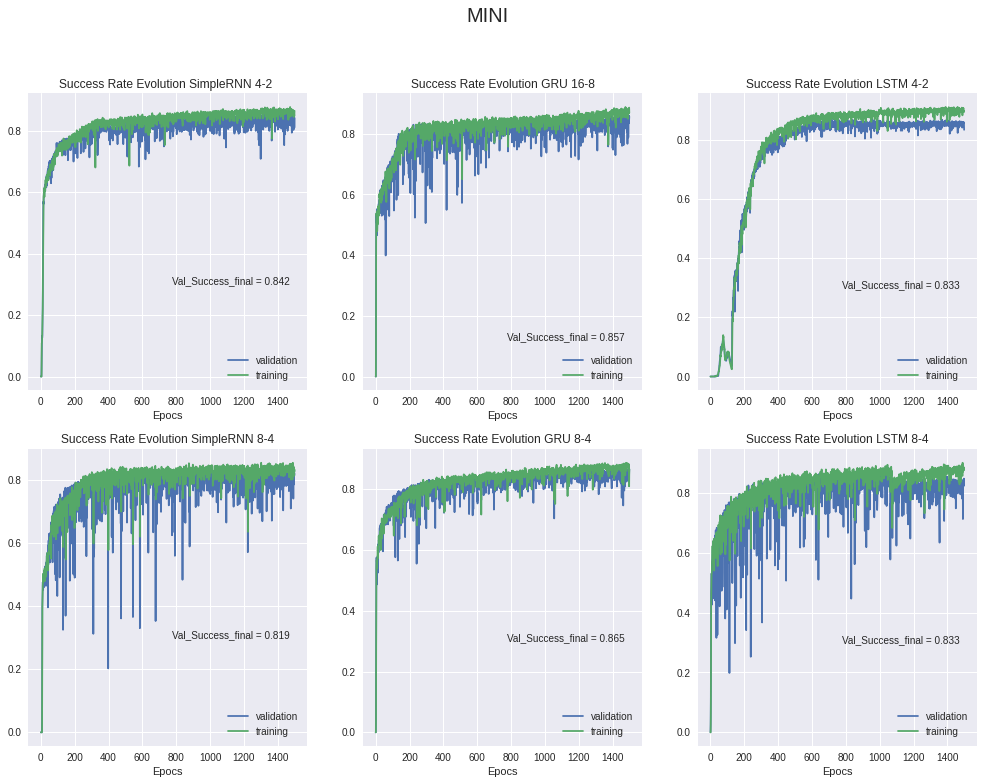

In [16]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 4-2
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['val_porcentaje_margen'],label='validation')
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['porcentaje_margen'],label="training")
axes[0,0].legend()
axes[0,0].set_title('Success Rate Evolution SimpleRNN 4-2 ')
axes[0,0].set_xlabel('Epocs')
axes[0,0].annotate('Val_Success_final = %.3f'% history_RNN84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 18-4
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['val_porcentaje_margen'],label='validation')
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['porcentaje_margen'],label="training")
axes[1,0].legend()
axes[1,0].set_title('Success Rate Evolution SimpleRNN 8-4')
axes[1,0].set_xlabel('Epocs')
axes[1,0].annotate('Val_Success_final = %.3f'% history_RNN168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 4-2
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['val_porcentaje_margen'],label='validation')
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['porcentaje_margen'],label="training")
axes[0,1].legend()
axes[0,1].set_title('Success Rate Evolution GRU 16-8')
axes[0,1].set_xlabel('Epocs')
axes[0,1].annotate('Val_Success_final = %.3f'% history_GRU168.history['val_porcentaje_margen'][-1], (1250, 0.12), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 8-4
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['val_porcentaje_margen'],label='validation')
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['porcentaje_margen'],label="training")
axes[1,1].legend()
axes[1,1].set_title('Success Rate Evolution GRU 8-4')
axes[1,1].set_xlabel('Epocs')
axes[1,1].annotate('Val_Success_final = %.3f'% history_GRU1684.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 4-2
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['val_porcentaje_margen'],label='validation')
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['porcentaje_margen'],label="training")
axes[0,2].legend()
axes[0,2].set_title('Success Rate Evolution LSTM 4-2')
axes[0,2].set_xlabel('Epocs')
axes[0,2].annotate('Val_Success_final = %.3f'% history_LSTM84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 8-4
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['val_porcentaje_margen'],label='validation')
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['porcentaje_margen'],label="training")
axes[1,2].legend()
axes[1,2].set_title('Success Rate Evolution LSTM 8-4')
axes[1,2].set_xlabel('Epocs')
axes[1,2].annotate('Val_Success_final = %.3f'% history_LSTM168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

In [35]:
# Calculo la prediccion para mi conjunto test
predictedRNN84 = pd.DataFrame(modelRNN84.predict(Xtt))
predictedRNN168 = pd.DataFrame(modelRNN168.predict(Xtt))
predictedGRU168 = pd.DataFrame(modelGRU168.predict(Xtt))
predictedGRU1684 = pd.DataFrame(modelGRU1684.predict(Xtt))
predictedLSTM84 = pd.DataFrame(modelLSTM84.predict(Xtt))
predictedLSTM168 = pd.DataFrame(modelLSTM168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseRNN84 = sqrt(mean_squared_error(ytt, predictedRNN84))
rmseRNN168 = sqrt(mean_squared_error(ytt, predictedRNN168))
rmseGRU168 = sqrt(mean_squared_error(ytt, predictedGRU168))
rmseGRU1684 = sqrt(mean_squared_error(ytt, predictedGRU1684))
rmseLSTM84 = sqrt(mean_squared_error(ytt, predictedLSTM84))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseRNN84,rmseRNN168,rmseGRU168,rmseGRU1684,rmseLSTM84,rmseLSTM168)

0.9762696482546231 1.0758987274137923 0.9653937486553453 1.0152958555643332 1.1106428192620743 1.1391370929077342


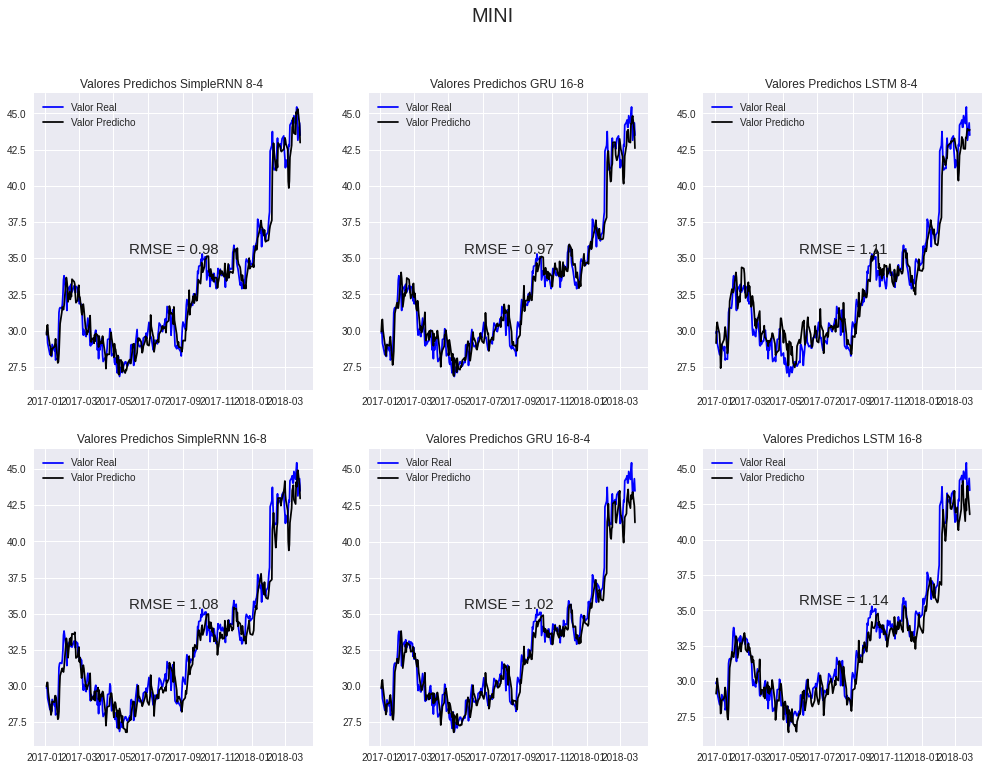

In [18]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)


# Plot de la RNN 8-4
axes[0,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,0].plot(index_time_t,predictedRNN84, label="Valor Predicho", color = "black")
axes[0,0].legend()
axes[0,0].set_title('Valores Predichos SimpleRNN 8-4 ')
axes[0,0].annotate('RMSE = %.2f'% rmseRNN84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)


# Plot de la RNN 16-8
axes[1,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,0].plot(index_time_t,predictedRNN168, label="Valor Predicho", color = "black")
axes[1,0].legend()
axes[1,0].set_title('Valores Predichos SimpleRNN 16-8 ')
axes[1,0].annotate('RMSE = %.2f'% rmseRNN168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8
axes[0,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,1].plot(index_time_t,predictedGRU168, label="Valor Predicho", color = "black")
axes[0,1].legend()
axes[0,1].set_title('Valores Predichos GRU 16-8 ')
axes[0,1].annotate('RMSE = %.2f'% rmseGRU168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8-4
axes[1,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,1].plot(index_time_t,predictedGRU1684, label="Valor Predicho", color = "black")
axes[1,1].legend()
axes[1,1].set_title('Valores Predichos GRU 16-8-4')
axes[1,1].annotate('RMSE = %.2f'% rmseGRU1684, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 8-4
axes[0,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,2].plot(index_time_t,predictedLSTM84, label="Valor Predicho", color = "black")
axes[0,2].legend()
axes[0,2].set_title('Valores Predichos LSTM 8-4 ')
axes[0,2].annotate('RMSE = %.2f'% rmseLSTM84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,2].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1,2].legend()
axes[1,2].set_title('Valores Predichos LSTM 16-8')
axes[1,2].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [83]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedRNN84
# Es un margen movil, segun lo que busquemos
margen = 0.0
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 159, -1.0: 149})


In [75]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26     94830.4        0      0  44.35  42.4547   0
Valor Final = 94830.41
Ganancia con margen = -5169.59


In [21]:
print(movimientos_alza)

           presupuesto acciones estado    valor     pred  dif
2017-01-03      100000        0      0  29.8328  29.9375  NaN
2017-01-04     18.1585     3335      1  29.9796  30.7159    1
2017-01-05     97227.3        0     -1  29.1482  30.7745   -1
2017-01-06     97227.3        0      0  28.9525  30.0481   -1
2017-01-09     97227.3        0      0  28.3657   29.142   -1
2017-01-10     97227.3        0      0  28.3167  28.9288   -1
2017-01-11     21.9732     3386      1   28.708  28.2596    1
2017-01-12     21.9732     3386      0  28.2189  28.5634    1
2017-01-13     98386.4        0     -1  29.0503  29.0372   -1
2017-01-17     24.6141     3438      1  28.6102  28.9531    1
2017-01-18     24.6141     3438      0  28.9036  29.3182    1
2017-01-19     96200.6        0     -1  27.9744   29.587   -1
2017-01-20     96200.6        0      0  28.0722  29.1112   -1
2017-01-23     24.6141     3432      1  28.0233  27.6295    1
2017-01-24     24.6141     3432      0   29.735   27.929    1
2017-01-

In [76]:
movimientos_alza.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/MINI/Alza3GRU-1684.csv")

In [84]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      230377        0          2669      0  44.35  44.1541  -1
Valor Final = 112006.76
Ganancia con margen = 12006.76


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [85]:
movimientos_ab.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/MINI/AlzaBaja0RNN-84.csv")

In [79]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      121434        0          1415      0  44.35  42.4547   0
Valor Final = 58678.55
Ganancia con margen = -41321.45


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [80]:
movimientos_baja.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/MINI/Baja3GRU-1684.csv")